<h1>NYC Rent Affordability Investigation:<br>Extract Transform Load & Exploratory Data Analysis</h1>

This is an investigation of rent affordability in NYC using neighborhood-level and borough-level from 2012-2022. 

I am using median rent data from the [Streeteasy Dashboard](https://streeteasy.com/blog/data-dashboard/), and median income data from the [U.S. Census American Community Survey](https://www.census.gov/programs-surveys/acs/data.html).

# Importing python packages and modules

In [1]:
# loading packages and modules (utils)
from utils.streeteasy_data_tools import tidy_asking_rent
from utils.us_census_data_tools import Import_ACS_Table
from utils.EDA_tools import find_continuous_periods
from utils.psql_connection_tools import get_engine

In [2]:
# data acquisition, stats, & plotting
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
# estimators/models
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
# preprocessing & engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# model scoring
from sklearn.metrics import silhouette_score
# organization
import warnings
warnings.filterwarnings('ignore')

# Importing, Visualizing, and Understanding Rent Data

In [3]:
# 1. Downloading the latest streeteasy data of rental prices

# Median asking rent for All APT sizes
df_rent_all = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                          "All/medianAskingRent_All.zip", compression='zip')

# Median asking rent for 1-Bedroom APTs
df_rent_1bdr = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                           "OneBd/medianAskingRent_OneBd.zip", compression='zip')

# Median asking rent for APTs with 3 Bedrooms or More
df_rent_3bdr = pd.read_csv("https://cdn-charts.streeteasy.com/rentals/"
                           "ThreePlusBd/medianAskingRent_ThreePlusBd.zip",
                            compression='zip')

df_rent_all.head()

areaName    Borough   areaType  2010-01  2010-02  2010-03  \
0         All Downtown  Manhattan  submarket   3200.0   3200.0   3015.0   
1          All Midtown  Manhattan  submarket   2875.0   2800.0   2800.0   
2  All Upper East Side  Manhattan  submarket   2450.0   2450.0   2400.0   
3  All Upper Manhattan  Manhattan  submarket   1825.0   1800.0   1795.0   
4  All Upper West Side  Manhattan  submarket   2895.0   2800.0   2750.0   

   2010-04  2010-05  2010-06  2010-07  ...  2024-11  2024-12  2025-01  \
0   3100.0   3100.0   3200.0   3195.0  ...   4895.0   4900.0   4998.0   
1   2850.0   2895.0   2950.0   3000.0  ...   4400.0   4500.0   4504.0   
2   2500.0   2565.0   2570.0   2595.0  ...   3950.0   3950.0   3950.0   
3   1800.0   1823.0   1850.0   1875.0  ...   2850.0   2850.0   2895.0   
4   2800.0   2800.0   2795.0   2800.0  ...   4295.0   4400.0   4432.0   

   2025-02  2025-03  2025-04  2025-05  2025-06  2025-07  2025-08  
0   5000.0   5000.0   5158.0   5250.0   5300.0   5437.0   5450.0  
1   4595.0   4586.0   4683.0   4750.0   4850.0   4875.0   4844.0  
2   4000.0   3995.0   4000.0   4156.0   4200.0   4200.0   4250.0  
3   2875.0   2900.0   3000.0   3195.0   3236.0   3300.0   3225.0  
4   4450.0   4500.0   4500.0   4500.0   4700.0   4800.0   4850.0  

[5 rows x 191 columns]

Let's ensure we're working with only relevant data

In [4]:
cols = df_rent_all.columns.to_numpy(dtype='str')
# looking at the first 3 columns
for i in range(1,3):
    print(f'{cols[i]} values = {np.unique(df_rent_all[cols[i]].to_numpy(dtype='str'))}')

print("\nWE ARE ONLY INTERESTED IN DATA AT THE NEIGHBORHOOD & BOROUGH LEVEL, SO WE'RE GOING TO REMOVE ALL OTHER areaTypes\n")

df_rent_all = df_rent_all[(df_rent_all['areaType'] == 'neighborhood')|(df_rent_all['areaType'] == 'borough')]
df_rent_3bdr = df_rent_1bdr[(df_rent_1bdr['areaType'] == 'neighborhood')|(df_rent_1bdr['areaType'] == 'borough')]
df_rent_3bdr = df_rent_3bdr[(df_rent_3bdr['areaType'] == 'neighborhood')|(df_rent_3bdr['areaType'] == 'borough')]
cols = df_rent_all.columns.to_numpy(dtype='str')
for i in range(1,3):
    print(f'{cols[i]} values = {np.unique(df_rent_all[cols[i]].to_numpy(dtype='str'))}')

print('-' * 25)

print('We have monthly rent data for these years:')
print([re.sub('-\d*','',date) for date in cols[3::12]])
print("\nThe 2025 data is incomplete, so we're going to remove it from the analysis\n")
df_rent_all = df_rent_all.iloc[:,:-8]
df_rent_1bdr = df_rent_1bdr.iloc[:,:-8]
df_rent_3bdr = df_rent_3bdr.iloc[:,:-8]
cols = df_rent_all.columns.to_numpy(dtype='str')
print([re.sub('-\d*','',date) for date in cols[3::12]])

Borough values = ['Bronx' 'Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'nan']
areaType values = ['borough' 'city' 'neighborhood' 'submarket']

WE ARE ONLY INTERESTED IN DATA AT THE NEIGHBORHOOD & BOROUGH LEVEL, SO WE'RE GOING TO REMOVE ALL OTHER areaTypes

Borough values = ['Bronx' 'Brooklyn' 'Manhattan' 'Queens' 'Staten Island']
areaType values = ['borough' 'neighborhood']
-------------------------
We have monthly rent data for these years:
['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', '2025']

The 2025 data is incomplete, so we're going to remove it from the analysis

['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


## Let's get familiar with our Rent data!

### Analyzing rent data for All Apartments

Let's look at a histogram of rent prices, at the borough level

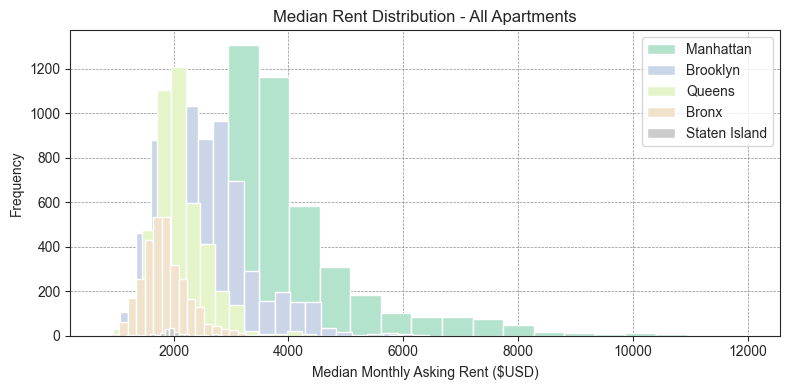

In [ ]:
boroughs = ['Manhattan','Brooklyn','Queens','Bronx','Staten Island']
cmap = mpl.colormaps['Pastel2']
colors = cmap(np.linspace(0,1,5))
sns.set_style('ticks')

plt.figure(figsize=(8,4))
for i, borough in enumerate(boroughs):
    subset_df = df_rent_all[df_rent_all['Borough'] == borough].iloc[:,3:].stack()
    plt.hist(subset_df, bins=20, label=borough, color=colors[i])

plt.legend(loc='upper right')
plt.title('Median Rent Distribution - All Apartments')
plt.xlabel('Median Monthly Asking Rent ($USD)')
plt.ylabel('Frequency')
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Let's see how rent prices fluctuate monthly

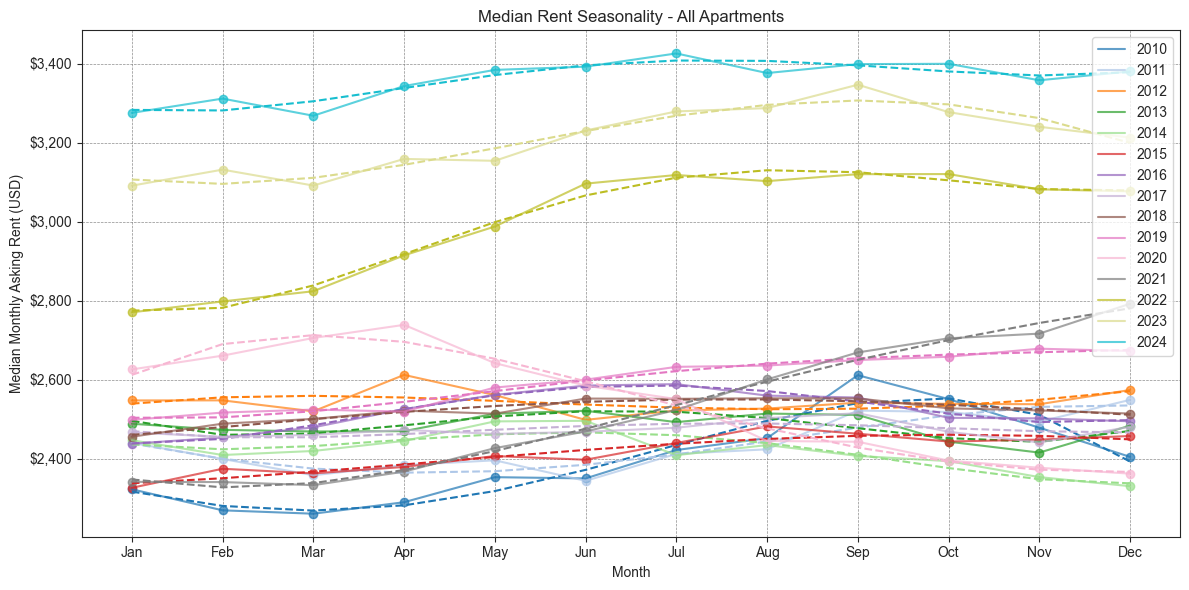

In [157]:
start_idx = np.arange(3,184,12)
end_idx = np.arange(15,184,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][:-1]
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_all.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right',)
plt.title('Median Rent Seasonality - All Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Median apartment rent prices ranged between $2300 and $2800 between 2010 and 2019.

Then, they shifted upwards ranging between $2800 and $3500 after 2021.

Let's take a closer look at this decadal shift.

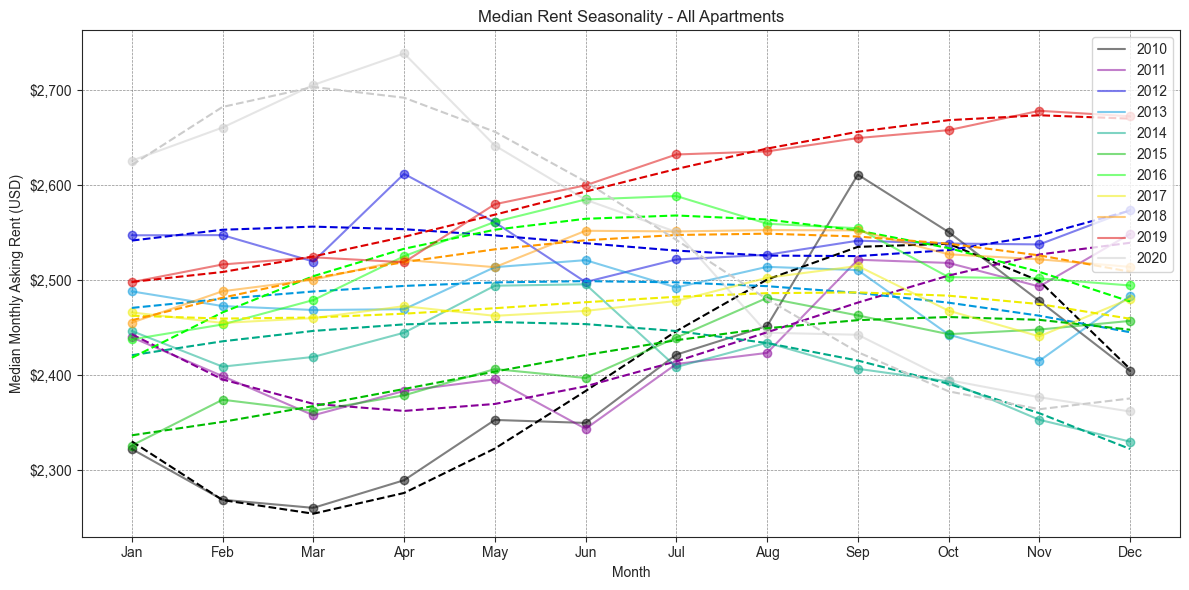

In [158]:
start_idx = np.arange(3,136,12)
end_idx = np.arange(15,136,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][:-5]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_all.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 3)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right')
plt.title('Median Rent Seasonality - All Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

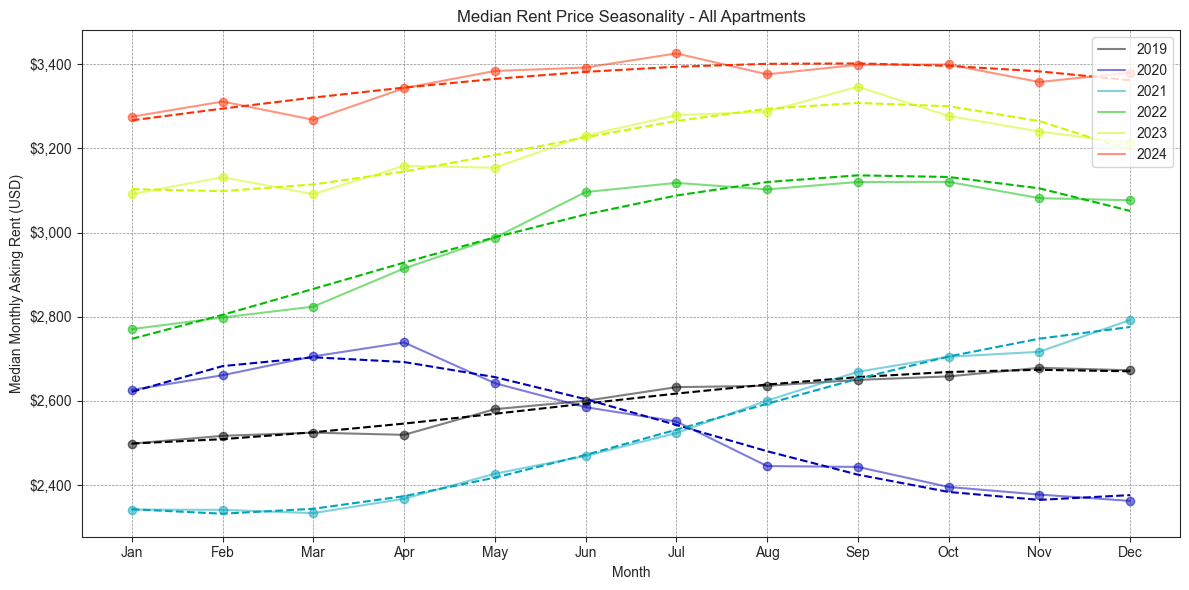

In [159]:
start_idx = np.arange(111,172,12)
end_idx = np.arange(123,184,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][9:-1]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_all.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 3)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right')
plt.title('Median Rent Price Seasonality - All Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Here are descriptive statistics for all date columns median rent data

In [160]:
df_rent_all.convert_dtypes().describe()

2010-01      2010-02      2010-03      2010-04      2010-05  \
count         74.0         76.0         73.0         74.0         69.0   
mean   2322.324324  2268.986842  2260.424658       2289.5  2352.942029   
std    1034.859399  1027.473218  1003.165572  1019.439898   989.008117   
min         1100.0       1098.0       1095.0       1095.0       1150.0   
25%         1612.5       1600.0       1597.0      1603.25       1695.0   
50%         2042.5       2044.0       2100.0       2025.0       2200.0   
75%        2671.25       2662.5       2650.0       2637.5       2790.0   
max         6925.0       6800.0       6500.0       6500.0       6500.0   

          2010-06      2010-07      2010-08      2010-09      2010-10  ...  \
count        70.0         67.0         68.0         65.0         70.0  ...   
mean       2349.8  2421.671642  2451.823529  2611.076923  2550.628571  ...   
std    973.893435   931.627452   943.535633  1111.555741  1164.008767  ...   
min        1050.0       1150.0       1150.0       1150.0       1150.0  ...   
25%       1664.75       1664.0       1675.0       1713.0       1650.0  ...   
50%        2250.0       2400.0       2425.0       2530.0       2385.0  ...   
75%        2777.5       2836.5      2896.25       2995.0       3000.0  ...   
max        6500.0       6000.0       6100.0       6500.0       7000.0  ...   

          2024-03      2024-04     2024-05      2024-06      2024-07  \
count       131.0        124.0       125.0        121.0        123.0   
mean   3268.10687  3343.290323    3384.184  3392.338843  3425.894309   
std      1261.165   1255.09031  1364.40331  1336.342194  1281.504698   
min        1750.0       1687.0      1713.0       1750.0       1875.0   
25%        2495.0       2500.0      2550.0       2600.0       2599.5   
50%        2950.0       2949.5      2950.0       2995.0       3000.0   
75%        3925.0       4048.0      3995.0       4102.0       4312.5   
max       10200.0       8900.0     11198.0      10000.0      10498.0   

           2024-08      2024-09      2024-10      2024-11     2024-12  
count        125.0        120.0        123.0        125.0       125.0  
mean      3376.184  3398.808333  3399.626016     3357.912    3380.368  
std    1249.020761  1253.415142  1297.912052  1321.617765  1397.01552  
min         1650.0       1795.0       1850.0       1800.0      1848.0  
25%         2550.0       2500.0       2518.5       2525.0      2500.0  
50%         3000.0       2978.0       2990.0       2903.0      2900.0  
75%         4000.0       4023.5       4000.0       4000.0      4150.0  
max         9830.0      10000.0      10000.0       9898.0     11450.0  

[8 rows x 180 columns]

### Analyzing rent data for 1-Bedroom Apartments

Let's look at a histogram of rent prices, at the borough level

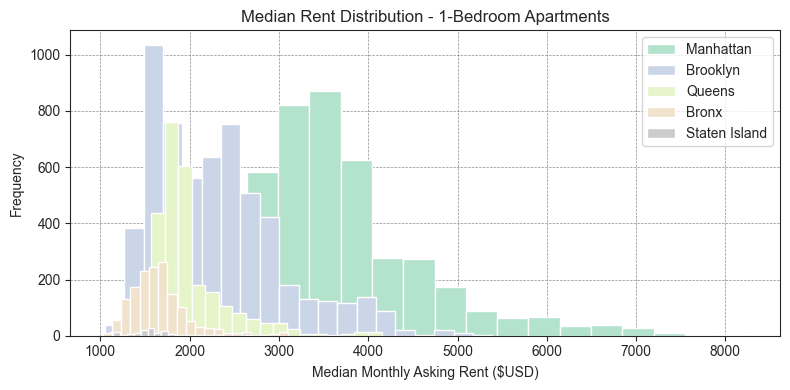

In [161]:
boroughs = ['Manhattan','Brooklyn','Queens','Bronx','Staten Island']
cmap = mpl.colormaps['Pastel2']
colors = cmap(np.linspace(0,1,5))

plt.figure(figsize=(8,4))
for i, borough in enumerate(boroughs):
    subset_df = df_rent_1bdr[df_rent_1bdr['Borough'] == borough].iloc[:,3:].stack()
    plt.hist(subset_df, bins=20, label=borough, color=colors[i])

plt.legend(loc='upper right')
plt.title('Median Rent Distribution - 1-Bedroom Apartments')
plt.xlabel('Median Monthly Asking Rent ($USD)')
plt.ylabel('Frequency')
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Let's see how rent prices fluctuate monthly

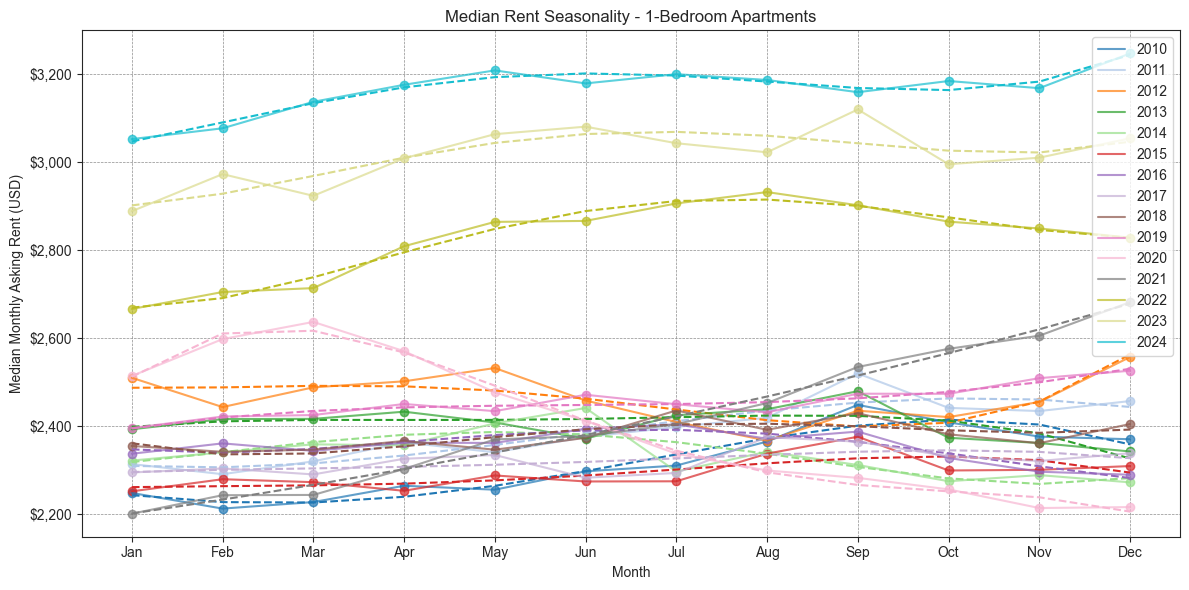

In [162]:
start_idx = np.arange(3,184,12)
end_idx = np.arange(15,184,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][:-1]
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_1bdr.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right',)
plt.title('Median Rent Seasonality - 1-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

We're seeing the same trend that we saw earlier while looking at all apartment data:

Median 1-bedroom apartment rent prices went through a decadal shift before and after 2021.

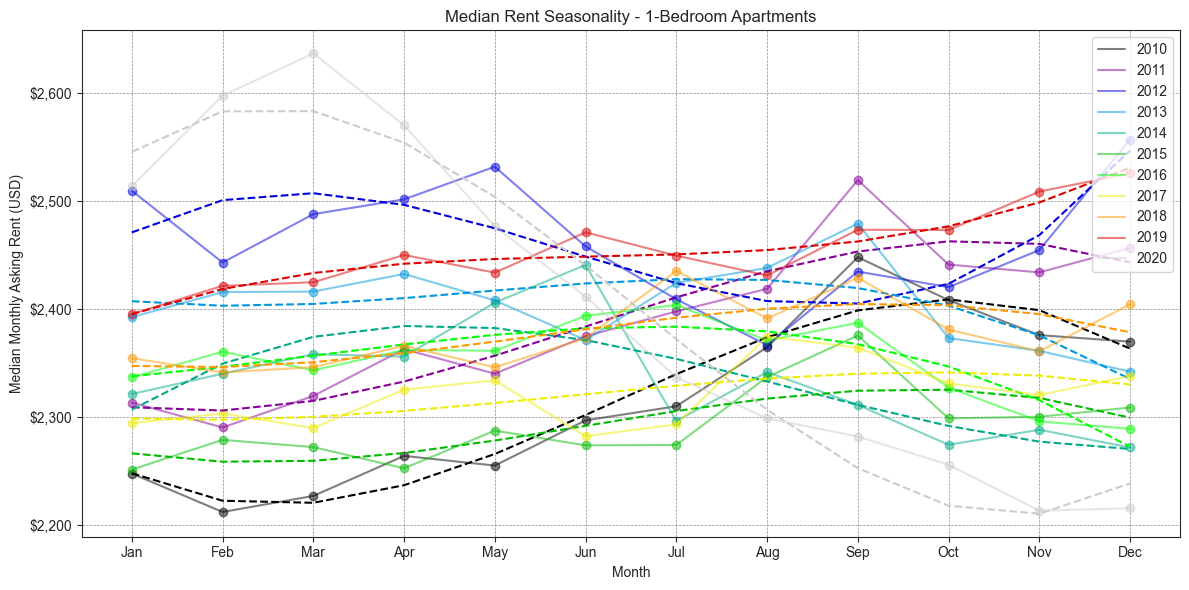

In [163]:
start_idx = np.arange(3,136,12)
end_idx = np.arange(15,136,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][:-5]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_1bdr.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 3)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right')
plt.title('Median Rent Seasonality - 1-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

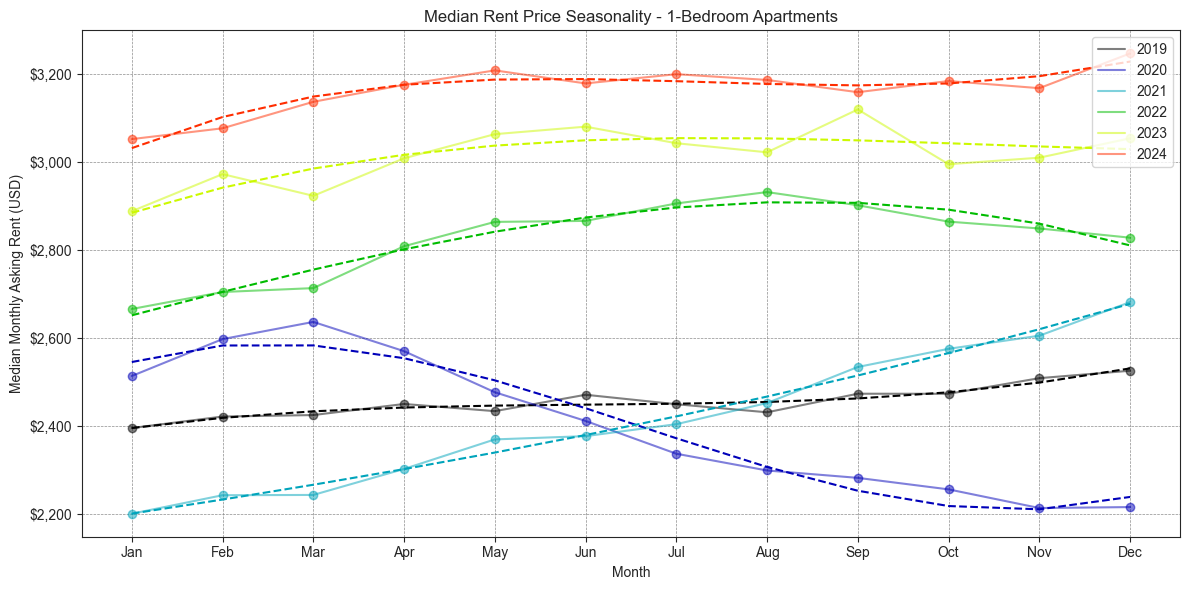

In [164]:
start_idx = np.arange(111,172,12)
end_idx = np.arange(123,184,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][9:-1]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_1bdr.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 3)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right')
plt.title('Median Rent Price Seasonality - 1-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Here are descriptive statistics for all date columns median rent data

In [165]:
df_rent_1bdr.convert_dtypes().describe()

2010-01      2010-02      2010-03      2010-04      2010-05  \
count         52.0         55.0         53.0         54.0         55.0   
mean   2247.692308  2212.090909  2226.962264  2264.018519  2255.072727   
std     841.212746    821.70591   794.220783   866.750111   791.456226   
min         1113.0       1175.0       1175.0       1188.0       1150.0   
25%         1600.0       1575.0       1600.0      1581.25       1522.5   
50%         2007.5       2025.0       2000.0       2025.0       2125.0   
75%        2818.75       2682.5       2700.0       2737.5       2747.0   
max         5500.0       5500.0       5300.0       5950.0       5000.0   

          2010-06     2010-07     2010-08    2010-09      2010-10  ...  \
count        53.0        54.0        50.0       53.0         54.0  ...   
mean   2296.90566      2310.0     2364.66     2448.0  2408.259259  ...   
std    831.275046  837.307207  833.786607  963.25448   958.894198  ...   
min        1150.0      1150.0      1150.0     1150.0       1150.0  ...   
25%        1550.0      1525.0      1800.0     1575.0       1559.5  ...   
50%        2200.0      2182.0      2312.5     2300.0       2300.0  ...   
75%        2800.0      2925.0      2950.0     3000.0      2993.25  ...   
max        5500.0      5395.0      5500.0     6500.0       6500.0  ...   

           2024-03      2024-04      2024-05      2024-06      2024-07  \
count         99.0         98.0        100.0         99.0         99.0   
mean   3137.373737  3176.071429      3208.83  3179.222222  3200.242424   
std    1177.013746  1126.247627  1134.662617  1126.353658  1106.705251   
min         1686.0       1495.0       1788.0       1773.0       1707.0   
25%         2199.5       2348.5       2351.5       2325.0       2366.5   
50%         2688.0       2732.5       2725.0       2750.0       2795.0   
75%         4059.5       4087.5       4000.0       4000.0       4000.0   
max         7200.0       6350.0       7000.0       6900.0       6995.0   

           2024-08      2024-09      2024-10      2024-11      2024-12  
count         97.0        100.0         98.0         98.0         94.0  
mean   3187.082474      3159.23  3184.663265  3168.387755   3247.43617  
std    1104.162594  1086.965732  1086.922516  1091.174168  1139.636393  
min         1698.0       1750.0       1749.0       1750.0       1750.0  
25%         2250.0       2300.0       2312.5       2300.0       2400.0  
50%         2800.0       2787.5       2800.0       2750.0       2772.5  
75%         4000.0      3979.75       3999.5      4060.25      4148.75  
max         6770.0       6595.0       6300.0       6200.0       7500.0  

[8 rows x 180 columns]

### Analyzing rent data for 3-Bedroom Apartments

Let's look at a histogram of rent prices, at the borough level

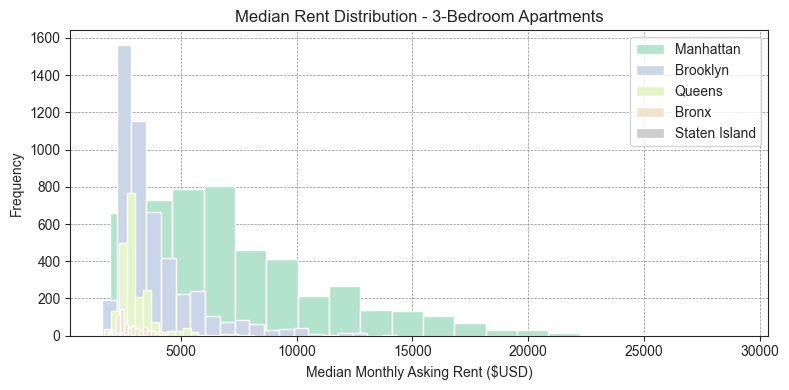

In [166]:
boroughs = ['Manhattan','Brooklyn','Queens','Bronx','Staten Island']
cmap = mpl.colormaps['Pastel2']
colors = cmap(np.linspace(0,1,5))

plt.figure(figsize=(8,4))
for i, borough in enumerate(boroughs):
    subset_df = df_rent_3bdr[df_rent_3bdr['Borough'] == borough].iloc[:,3:].stack()
    plt.hist(subset_df, bins=20, label=borough, color=colors[i])

plt.legend(loc='upper right')
plt.title('Median Rent Distribution - 3-Bedroom Apartments')
plt.xlabel('Median Monthly Asking Rent ($USD)')
plt.ylabel('Frequency')
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Let's see how rent prices fluctuate monthly

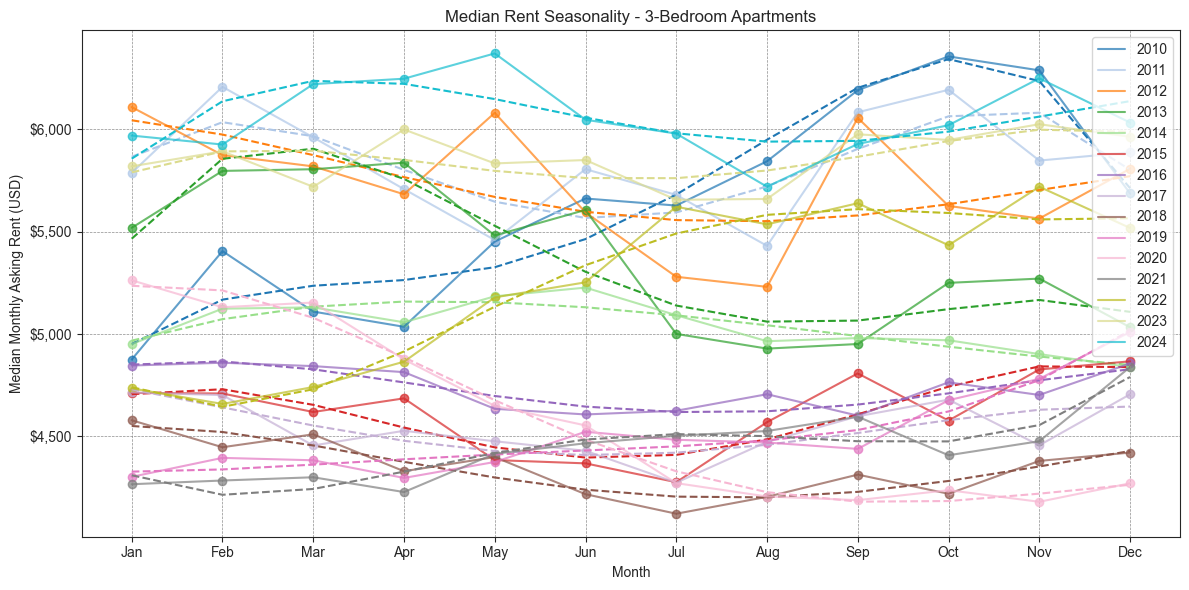

In [167]:
start_idx = np.arange(3,184,12)
end_idx = np.arange(15,184,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][:-1]
cmap = mpl.colormaps['tab20']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_3bdr.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.7)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.7)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 4)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right',)
plt.title('Median Rent Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

3-bedroom apartments have a more complex story regarding monthly price fluctuations over time.

It appears that the years 2010-2014 have higher asking rent prices than the 5 following years leading up to 2020.

Then, we see a similar shift to the 1-bedroom and all-apartment datasets, where prices shift higher in 2022 and beyond. In this case, 3-bedroom apartment prices return to similar levels as that of 2010-2014.

In the former part of the 2010s, streeteasy was a less popular website and apartments with 3 bedrooms or more hold a relatively smaller portion of the housing stock in NYC. Based on this information, we can infer that 3+ bedroom apartment prices in the early 2010s may have been affected by a smaller sample size. I may be wrong about this. 

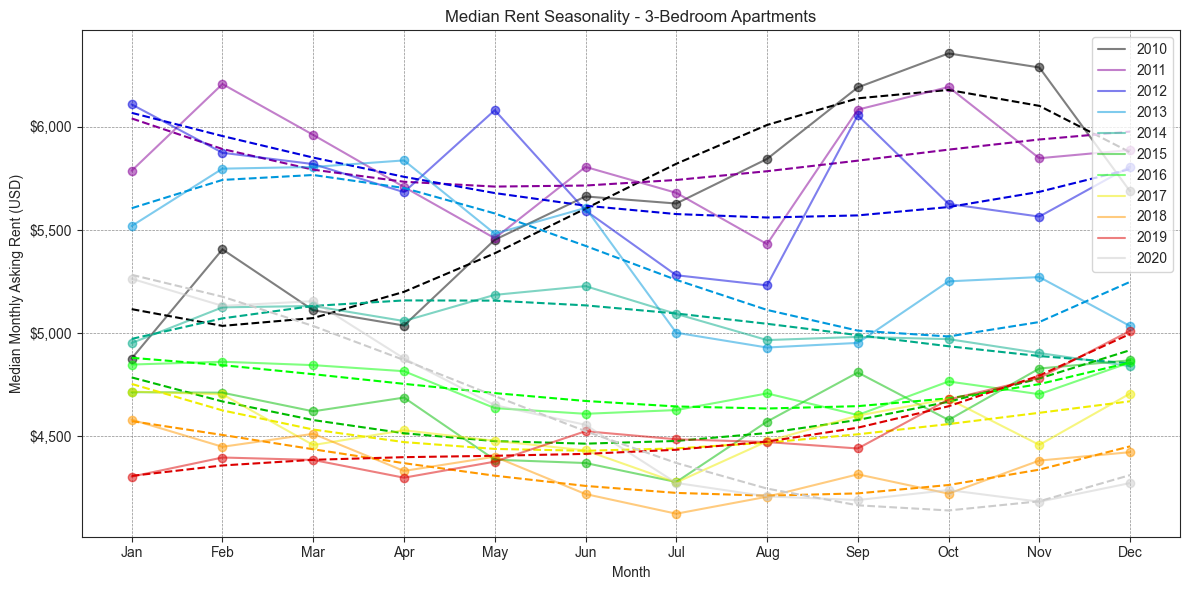

In [168]:
start_idx = np.arange(3,136,12)
end_idx = np.arange(15,136,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][:-5]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_3bdr.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 3)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right')
plt.title('Median Rent Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

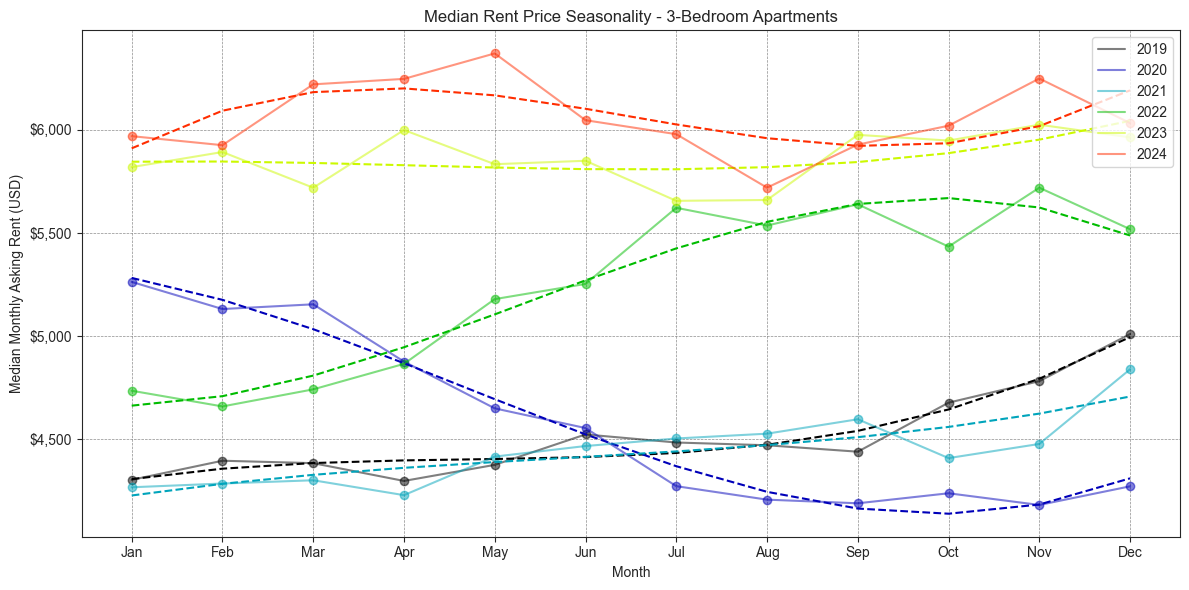

In [169]:
start_idx = np.arange(111,172,12)
end_idx = np.arange(123,184,12)

months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = [re.sub('-\d*','',date) for date in cols[3::12]][9:-1]
cmap = mpl.colormaps['nipy_spectral']
colors = cmap(np.linspace(0,1,len(years)+1))

plt.figure(figsize=(12,6))
for i in np.arange(len(years)):
    monthly_rent = df_rent_3bdr.iloc[:,start_idx[i]:end_idx[i]].mean()
    plt.plot(months, monthly_rent, color=colors[i], label=years[i], alpha=0.5)
    plt.scatter(months, monthly_rent, color=colors[i], alpha=0.5)
    # calculating a polynomial to fit the seasonal trend
    coeff = np.polyfit(np.arange(len(months)), monthly_rent, 3)
    trend_fx = np.poly1d(coeff)
    plt.plot(months, trend_fx(np.arange(len(months))), color=colors[i], ls='--')

plt.legend(loc='upper right')
plt.title('Median Rent Price Seasonality - 3-Bedroom Apartments')
plt.ylabel('Median Monthly Asking Rent (USD)')
plt.xlabel('Month')
# Format y-axis to show dollar signs
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
plt.grid(which='major',axis='both',color='gray',lw=0.5, ls='--', alpha=0.9)
plt.tight_layout() 
plt.show()

Here are descriptive statistics for all date columns median rent data

In [170]:
df_rent_3bdr.convert_dtypes().describe()

2010-01      2010-02      2010-03      2010-04      2010-05  \
count         38.0         39.0         39.0         36.0         33.0   
mean   4875.736842  5405.128205  5109.820513  5035.555556  5451.545455   
std    2884.176192  3608.803287  3060.627781   3080.16897  3534.974824   
min         1800.0       1800.0       2025.0       2050.0       1750.0   
25%         2775.0       2845.0       2747.5      2854.75       2690.0   
50%         3575.0       3925.0       3925.0       3562.5       4300.0   
75%         6875.0       7597.5       6375.0       6312.5       7500.0   
max        11750.0      17000.0      14225.0      13725.0      15000.0   

           2010-06      2010-07      2010-08      2010-09      2010-10  ...  \
count         34.0         36.0         35.0         32.0         31.0  ...   
mean   5661.823529  5627.527778  5843.714286   6190.84375  6355.580645  ...   
std    3905.430031  3646.050611  3971.000952  4010.849633  3884.479217  ...   
min         1750.0       1750.0       1750.0       1750.0       1750.0  ...   
25%        2505.75       2787.5       2732.5      2918.75       2900.0  ...   
50%         4347.5       4069.0       4095.0       4841.5       5300.0  ...   
75%        7406.25       7312.5       7525.0      7846.25       8202.5  ...   
max        16000.0      15000.0      15250.0      15313.0      15625.0  ...   

           2024-03      2024-04      2024-05      2024-06      2024-07  \
count         80.0         78.0         79.0         83.0         86.0   
mean     6220.3125  6246.820513  6370.227848  6046.445783   5978.72093   
std    3955.469895  4006.700812  4022.323499  3817.930081  3773.017852   
min         2950.0       2775.0       2850.0       2775.0       2800.0   
25%         3483.0       3546.0       3600.0       3600.0      3596.25   
50%         3862.5       4250.0       4500.0       4100.0       4350.0   
75%         7462.5      7761.25       7825.0       7272.5      6971.25   
max        20000.0      23500.0      21500.0      24000.0      25000.0   

           2024-08      2024-09      2024-10      2024-11      2024-12  
count         87.0         86.0         81.0         78.0         83.0  
mean   5719.367816  5928.127907  6019.716049  6248.602564  6032.590361  
std    3364.984219  3880.412858  3827.457345  4304.012973  4352.319738  
min         3000.0       2900.0       2925.0       2998.0       2848.0  
25%         3500.0       3500.0       3537.0       3500.0       3500.0  
50%         4175.0       4186.0       4200.0       4200.0       4000.0  
75%         6797.5      6718.75       6698.0       6599.5       6495.0  
max        21700.0      25000.0      19748.0      22995.0      27000.0  

[8 rows x 180 columns]

### Quantifying Missing Data at the Neighborhood & Borough level

In [172]:
def create_data_availability_heatmap(df_rent, borough='Manhattan', figsize=(30, 15), subtitle='All Apartments'):
    """
    This FX creates a heatmap of data availability (1s and 0s) for rent data
    by neighborhood and year-month date combos.
    
    Input:
        df_rent_all: pandas dataframe with neighborhoods and date columns
        borough: string representing the borough to filter for (default: 'Manhattan')
        figsize: tuple of the figure size for the plot
    """
    
    # Filter data for the specified borough and/or neighborhood type
    if borough == 'Staten Island':
        subset_df = df_rent[df_rent['Borough'] == borough]
    else:
        subset_df = df_rent[(df_rent['Borough'] == borough) & 
                            (df_rent['areaType'] == 'neighborhood')].copy()
        
    # Get date columns 
    date_cols = df_rent.columns[3:]
    subset_data = subset_df[date_cols].reset_index(drop=True)
    
    # Get neighborhood names for labeling
    neighborhood_names = subset_df['areaName'].reset_index(drop=True)
    
    # Create the availability matrix (1 for data present, 0 for missing)
    # Shape: (neighborhoods, dates)
    availability_matrix = np.zeros((len(subset_data), len(date_cols)))
    
    # Fill the matrix
    for row_idx in range(len(subset_data)):
        for col_idx, col_name in enumerate(date_cols):
            cell_value = subset_data.iloc[row_idx, col_idx]
            # Check if data is present (not NaN)
            if pd.notna(cell_value):
                availability_matrix[row_idx, col_idx] = 1
            else:
                availability_matrix[row_idx, col_idx] = 0

    # Create the heatmap
    plt.figure(figsize=figsize)
    
    # Use a custom colormap: white for missing (0), dark blue for present (1)
    colors = ['#FFFFFF', '#00008B'] 
    custom_cmap = mpl.colors.ListedColormap(colors)
    
    # Create heatmap
    ax = sns.heatmap(availability_matrix, 
                     cmap=custom_cmap,
                     cbar=False,
                     xticklabels=date_cols,
                     yticklabels=neighborhood_names,
                     linewidths=0.1,
                     linecolor='lightgray')
    
    # Customize the plot
    ax.set_title(f'Data Availability Heatmap: {borough} Neighborhoods - {subtitle}\n' + 
              'Dark Blue = Data Present, White = Data Missing', 
              fontsize=25, fontweight='bold', pad=20)
    ax.set_xlabel('Year-Month', fontsize=15, fontweight='bold')
    ax.set_ylabel('Neighborhoods', fontsize=15, fontweight='bold')
    ax.set_xticks(ticks=np.arange(0.5, len(date_cols)+0.5, 2), labels=date_cols[::2], rotation=75, ha='right',)
    ax.set_xticklabels(labels=date_cols[::2], fontdict={'fontsize': 15})
    ax.set_yticks(ticks=np.arange(0.5, len(neighborhood_names)+0.5))
    ax.set_yticklabels(labels=neighborhood_names, fontdict={'fontsize': 15})
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    total_cells = availability_matrix.size
    present_data = np.sum(availability_matrix)
    missing_data = total_cells - present_data
    
    print(f"Data Availability Summary for {borough}:")
    print(f"Total data points: {total_cells}")
    print(f"Data present: {present_data} ({present_data/total_cells*100:.1f}%)")
    print(f"Data missing: {missing_data} ({missing_data/total_cells*100:.1f}%)")
    print(f"Number of neighborhoods: {len(neighborhood_names)}")
    print(f"Number of time periods: {len(date_cols)}")
    
    return

#### All Apartments

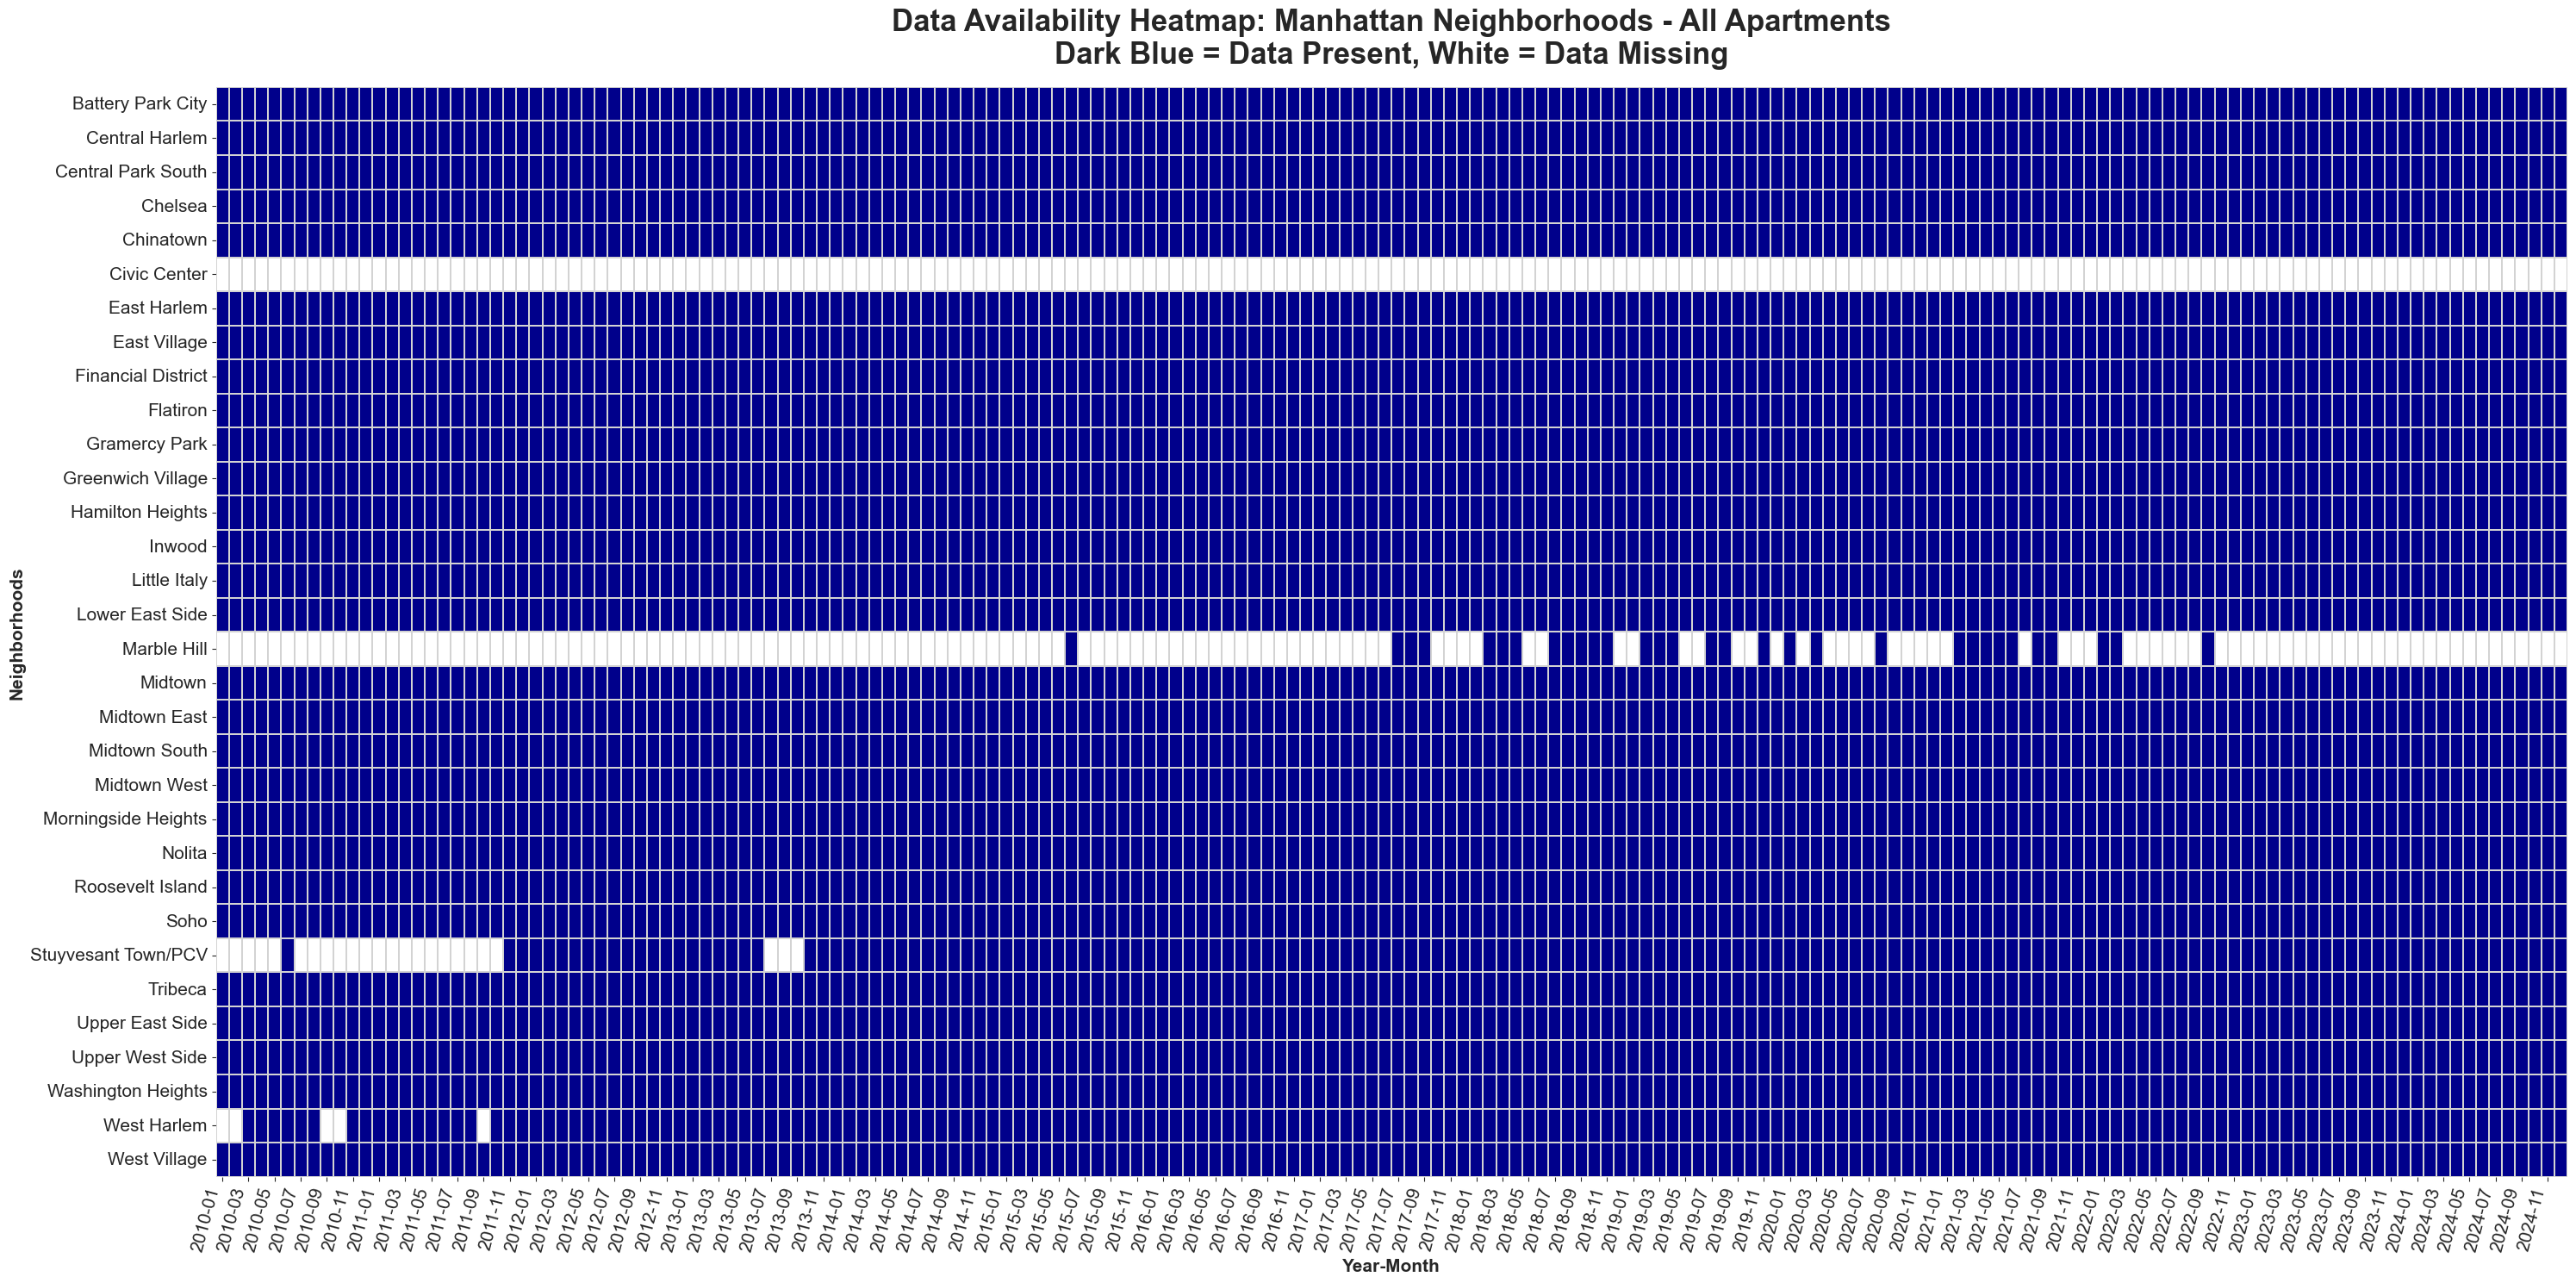

Data Availability Summary for Manhattan:
Total data points: 5760
Data present: 5402.0 (93.8%)
Data missing: 358.0 (6.2%)
Number of neighborhoods: 32
Number of time periods: 180


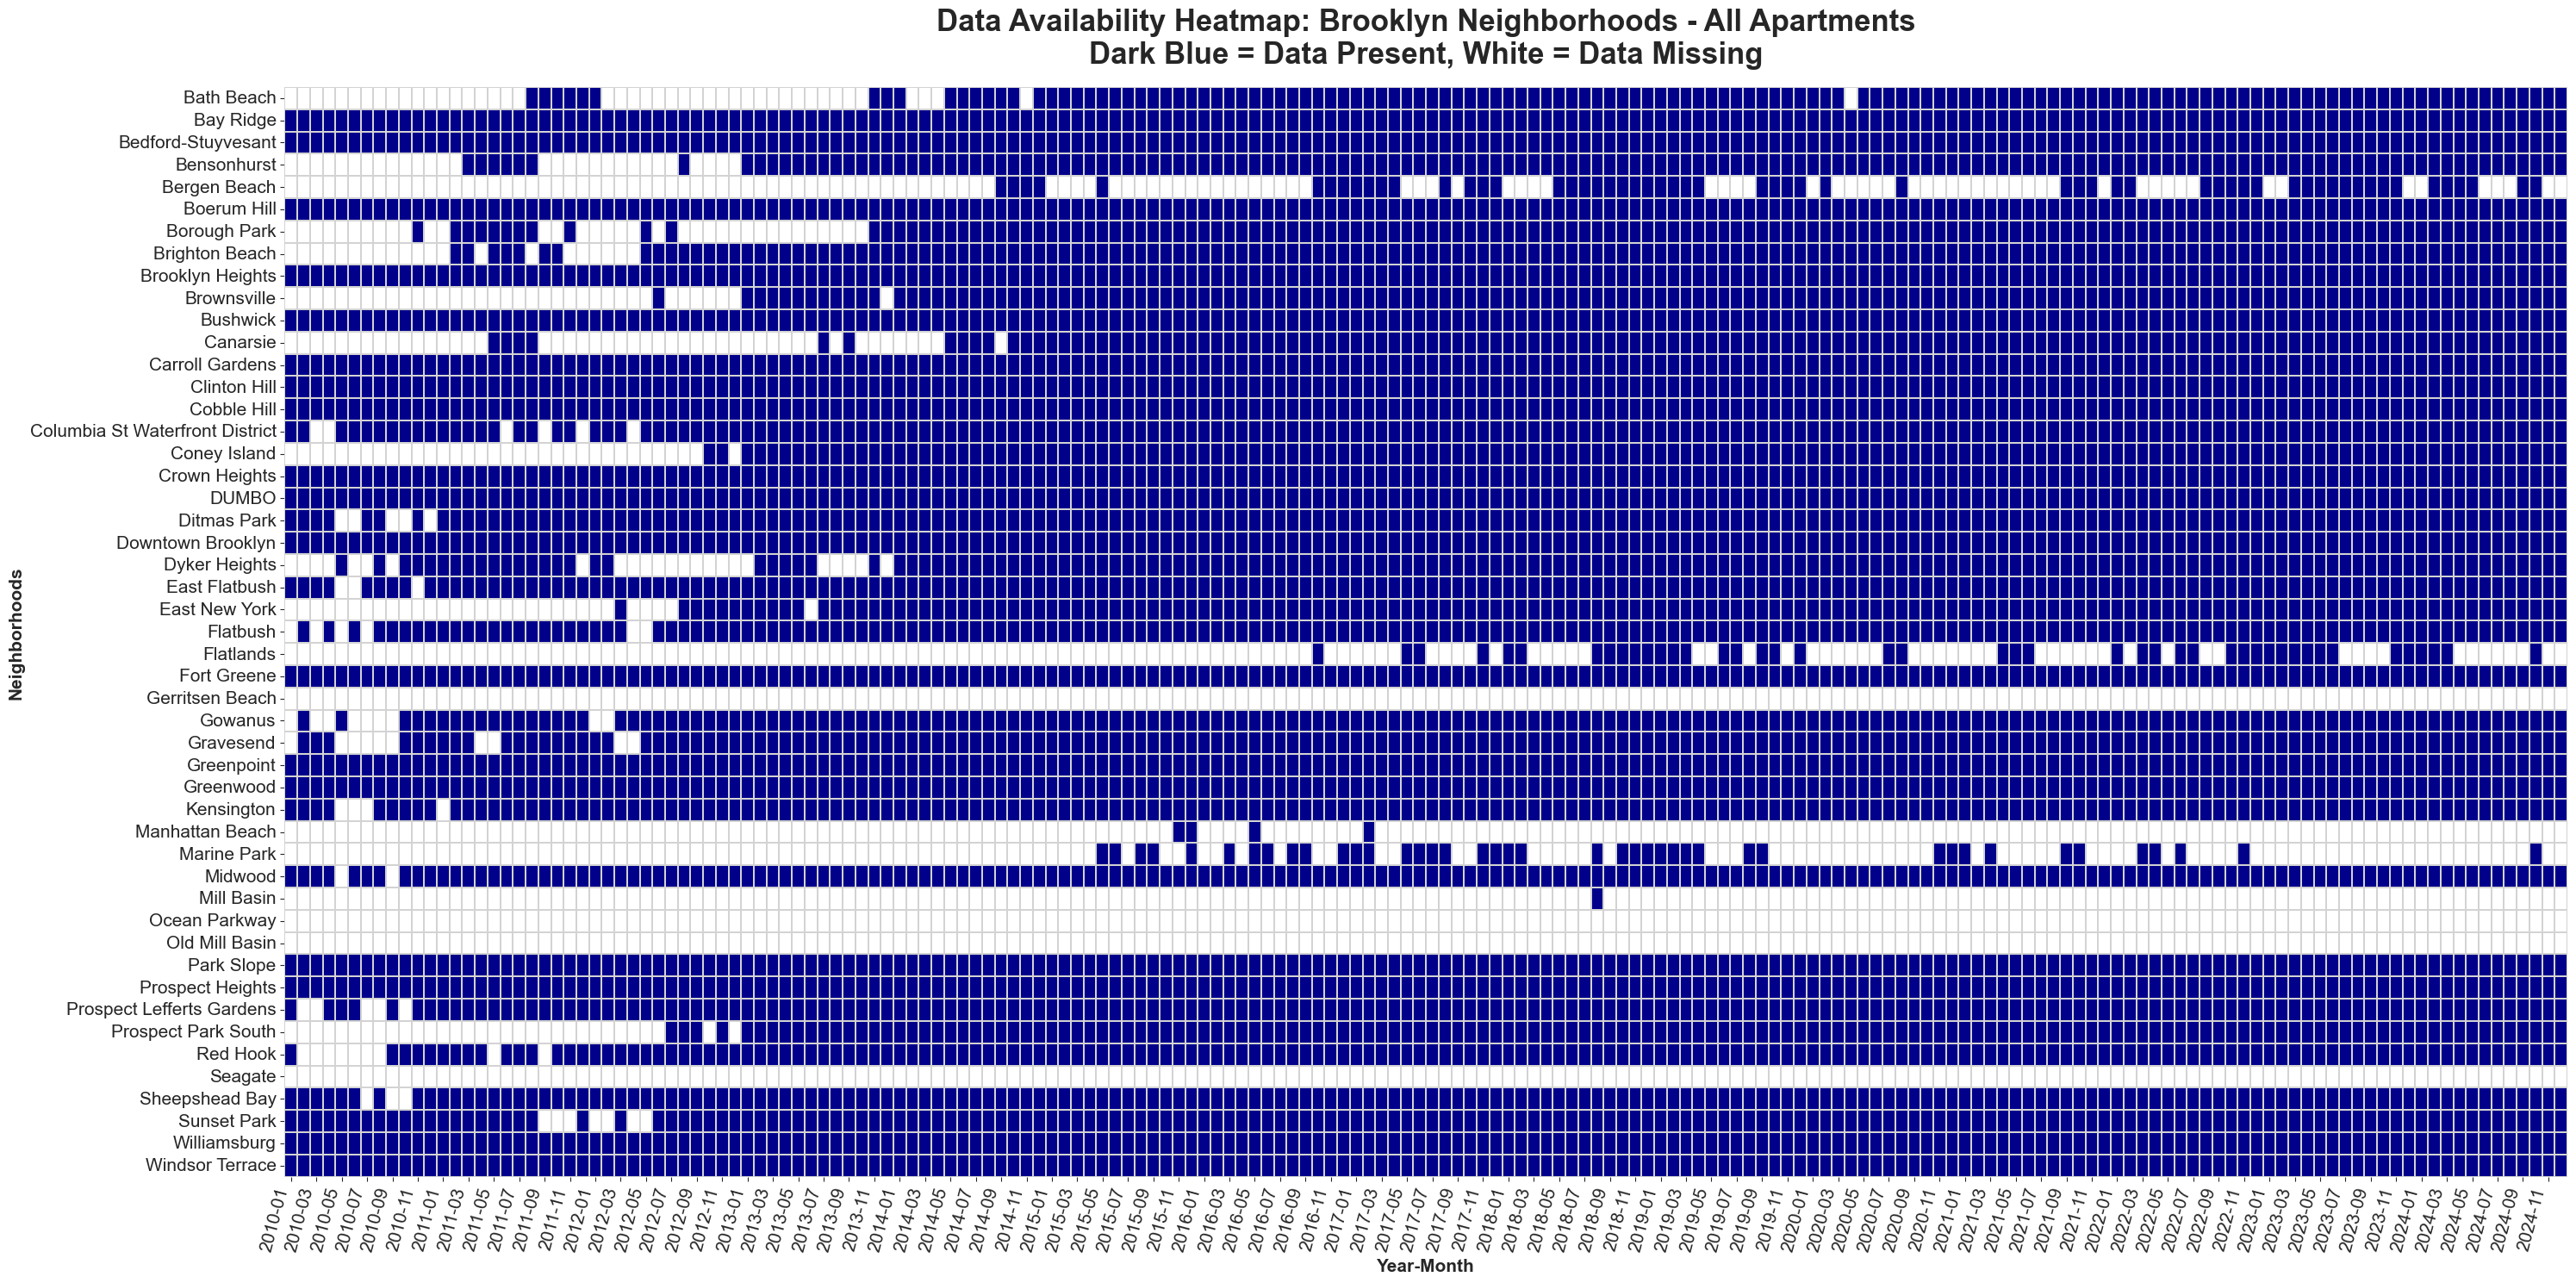

Data Availability Summary for Brooklyn:
Total data points: 8820
Data present: 6947.0 (78.8%)
Data missing: 1873.0 (21.2%)
Number of neighborhoods: 49
Number of time periods: 180


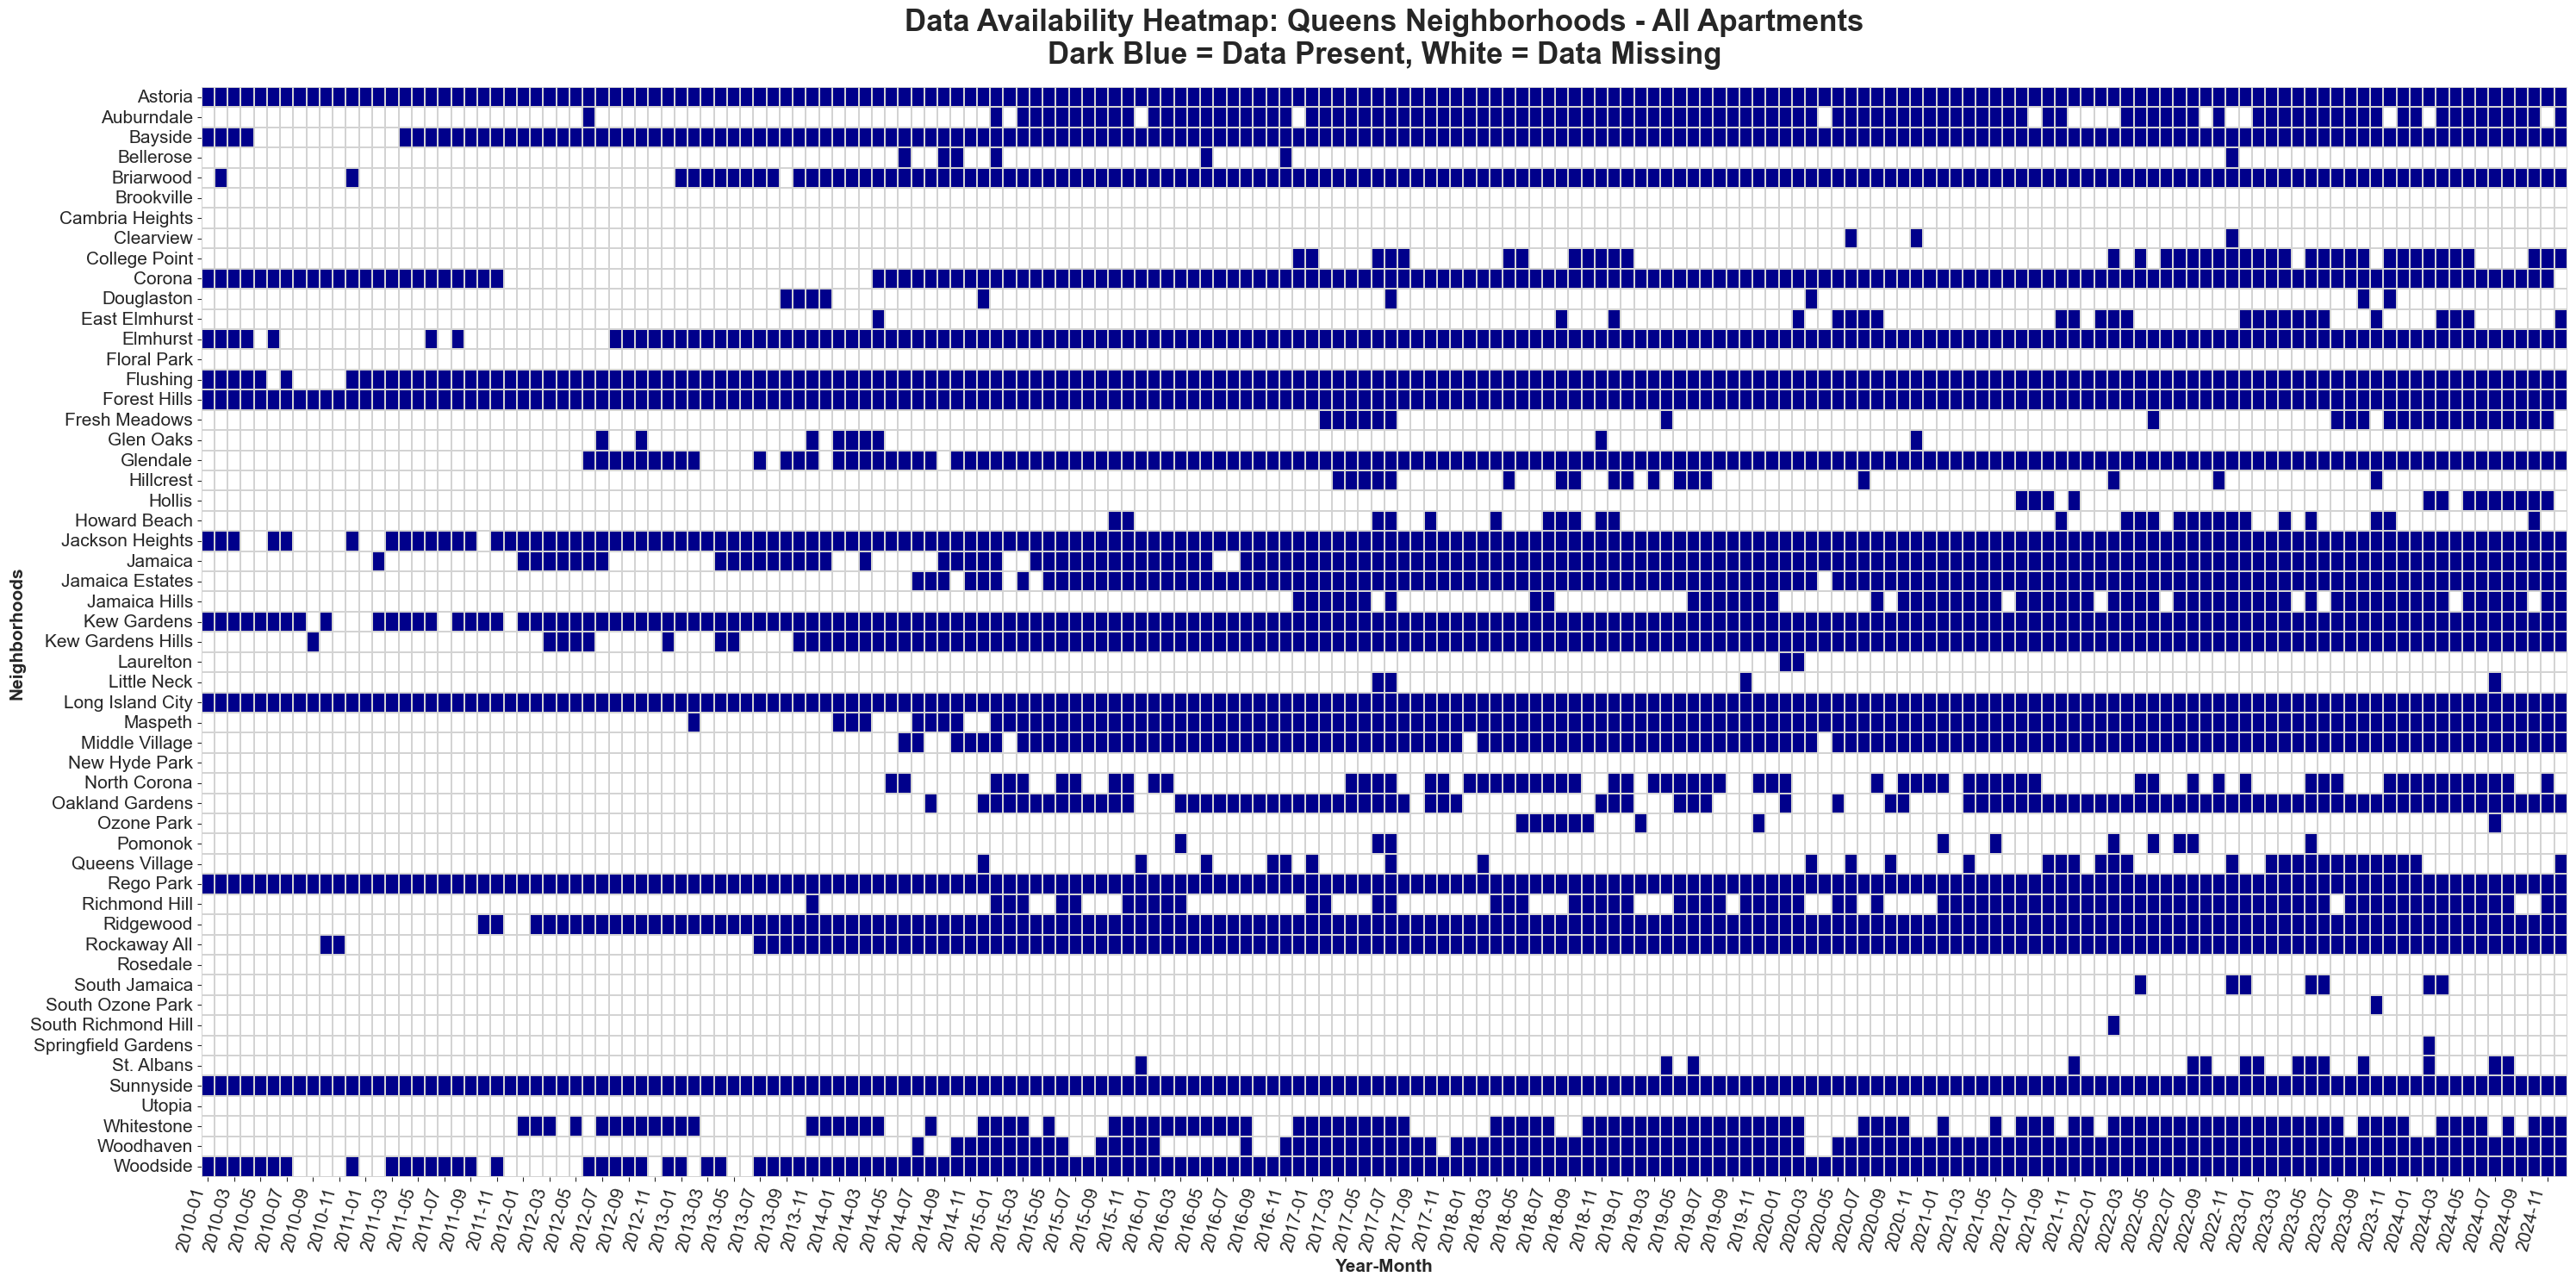

Data Availability Summary for Queens:
Total data points: 9720
Data present: 4175.0 (43.0%)
Data missing: 5545.0 (57.0%)
Number of neighborhoods: 54
Number of time periods: 180


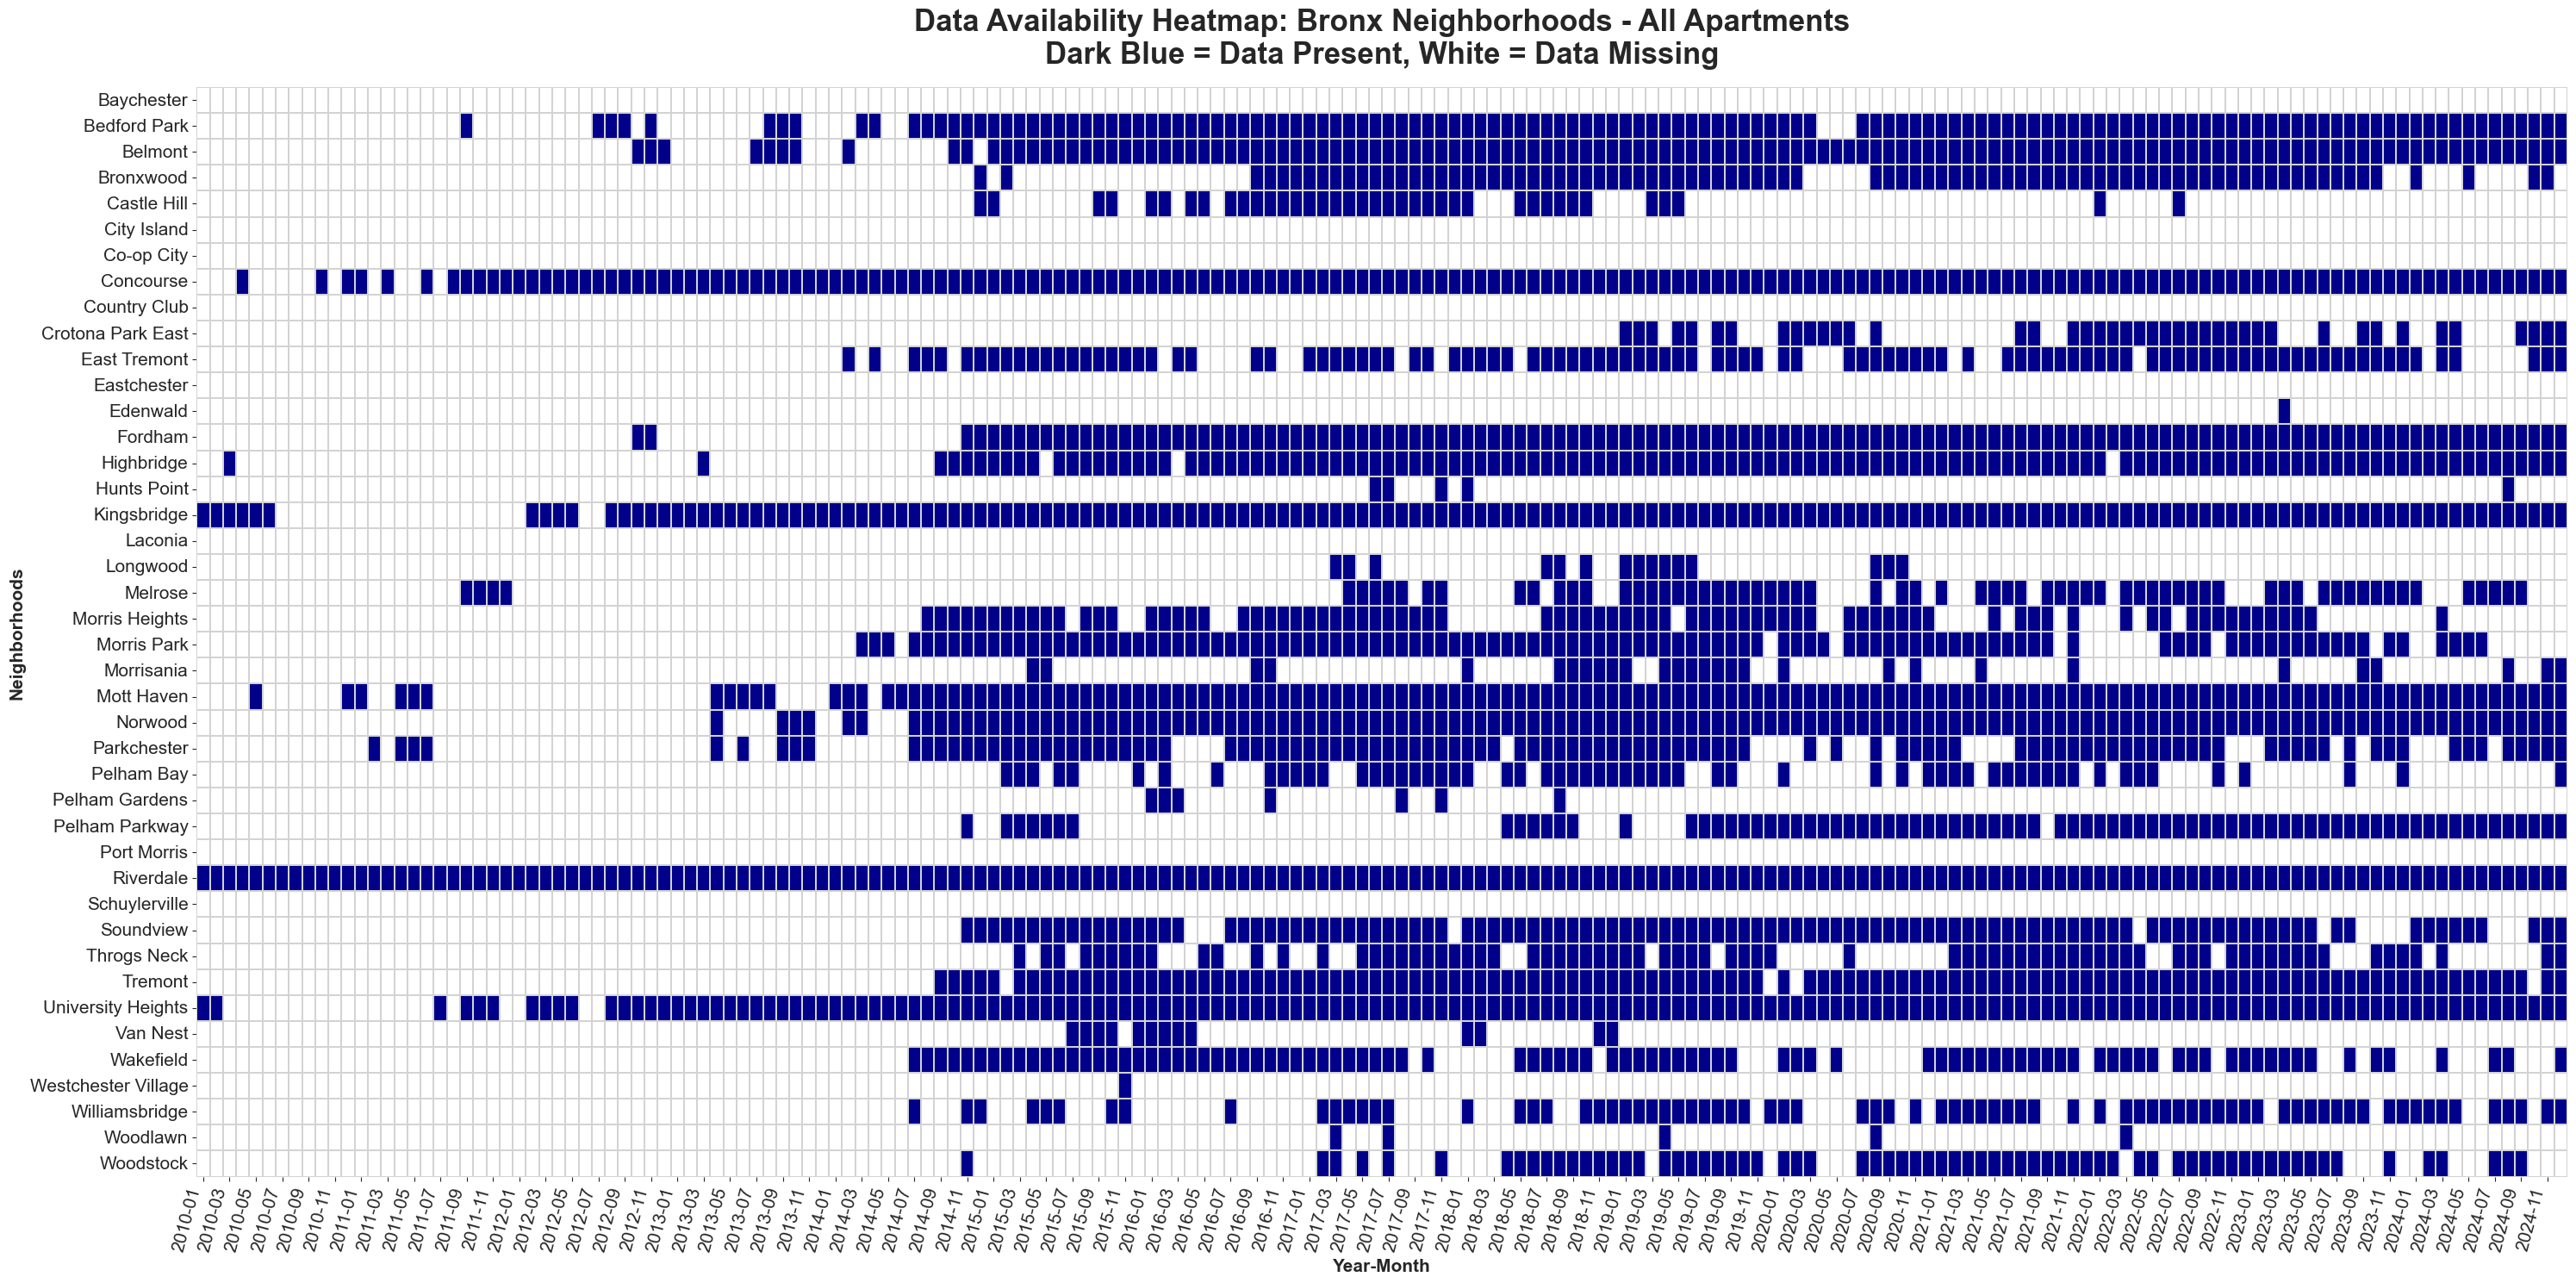

Data Availability Summary for Bronx:
Total data points: 7560
Data present: 2847.0 (37.7%)
Data missing: 4713.0 (62.3%)
Number of neighborhoods: 42
Number of time periods: 180


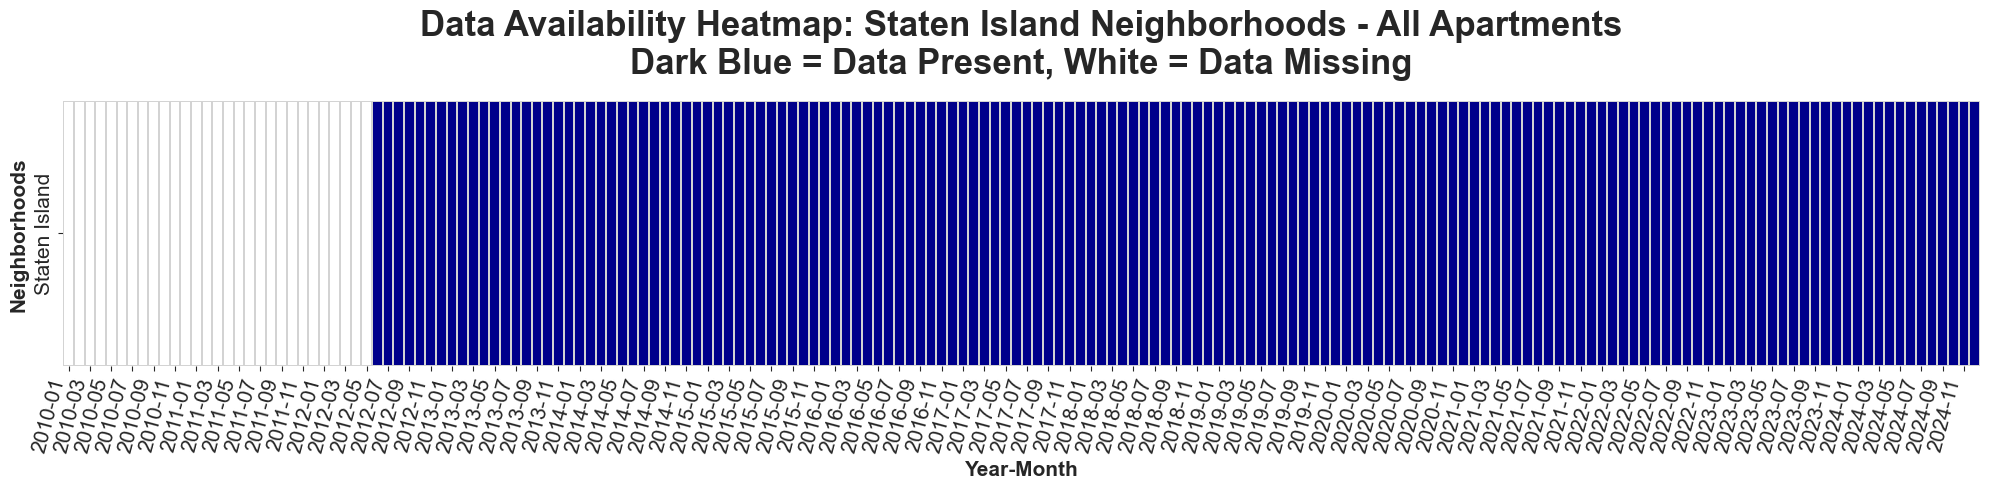

Data Availability Summary for Staten Island:
Total data points: 180
Data present: 151.0 (83.9%)
Data missing: 29.0 (16.1%)
Number of neighborhoods: 1
Number of time periods: 180


In [178]:
for borough in boroughs:
    if borough == 'Staten Island':
        create_data_availability_heatmap(df_rent_all, borough, figsize=(20,5), subtitle='All Apartments')
    else:
        create_data_availability_heatmap(df_rent_all, borough, subtitle='All Apartments')

#### 1-Bedroom Apartments

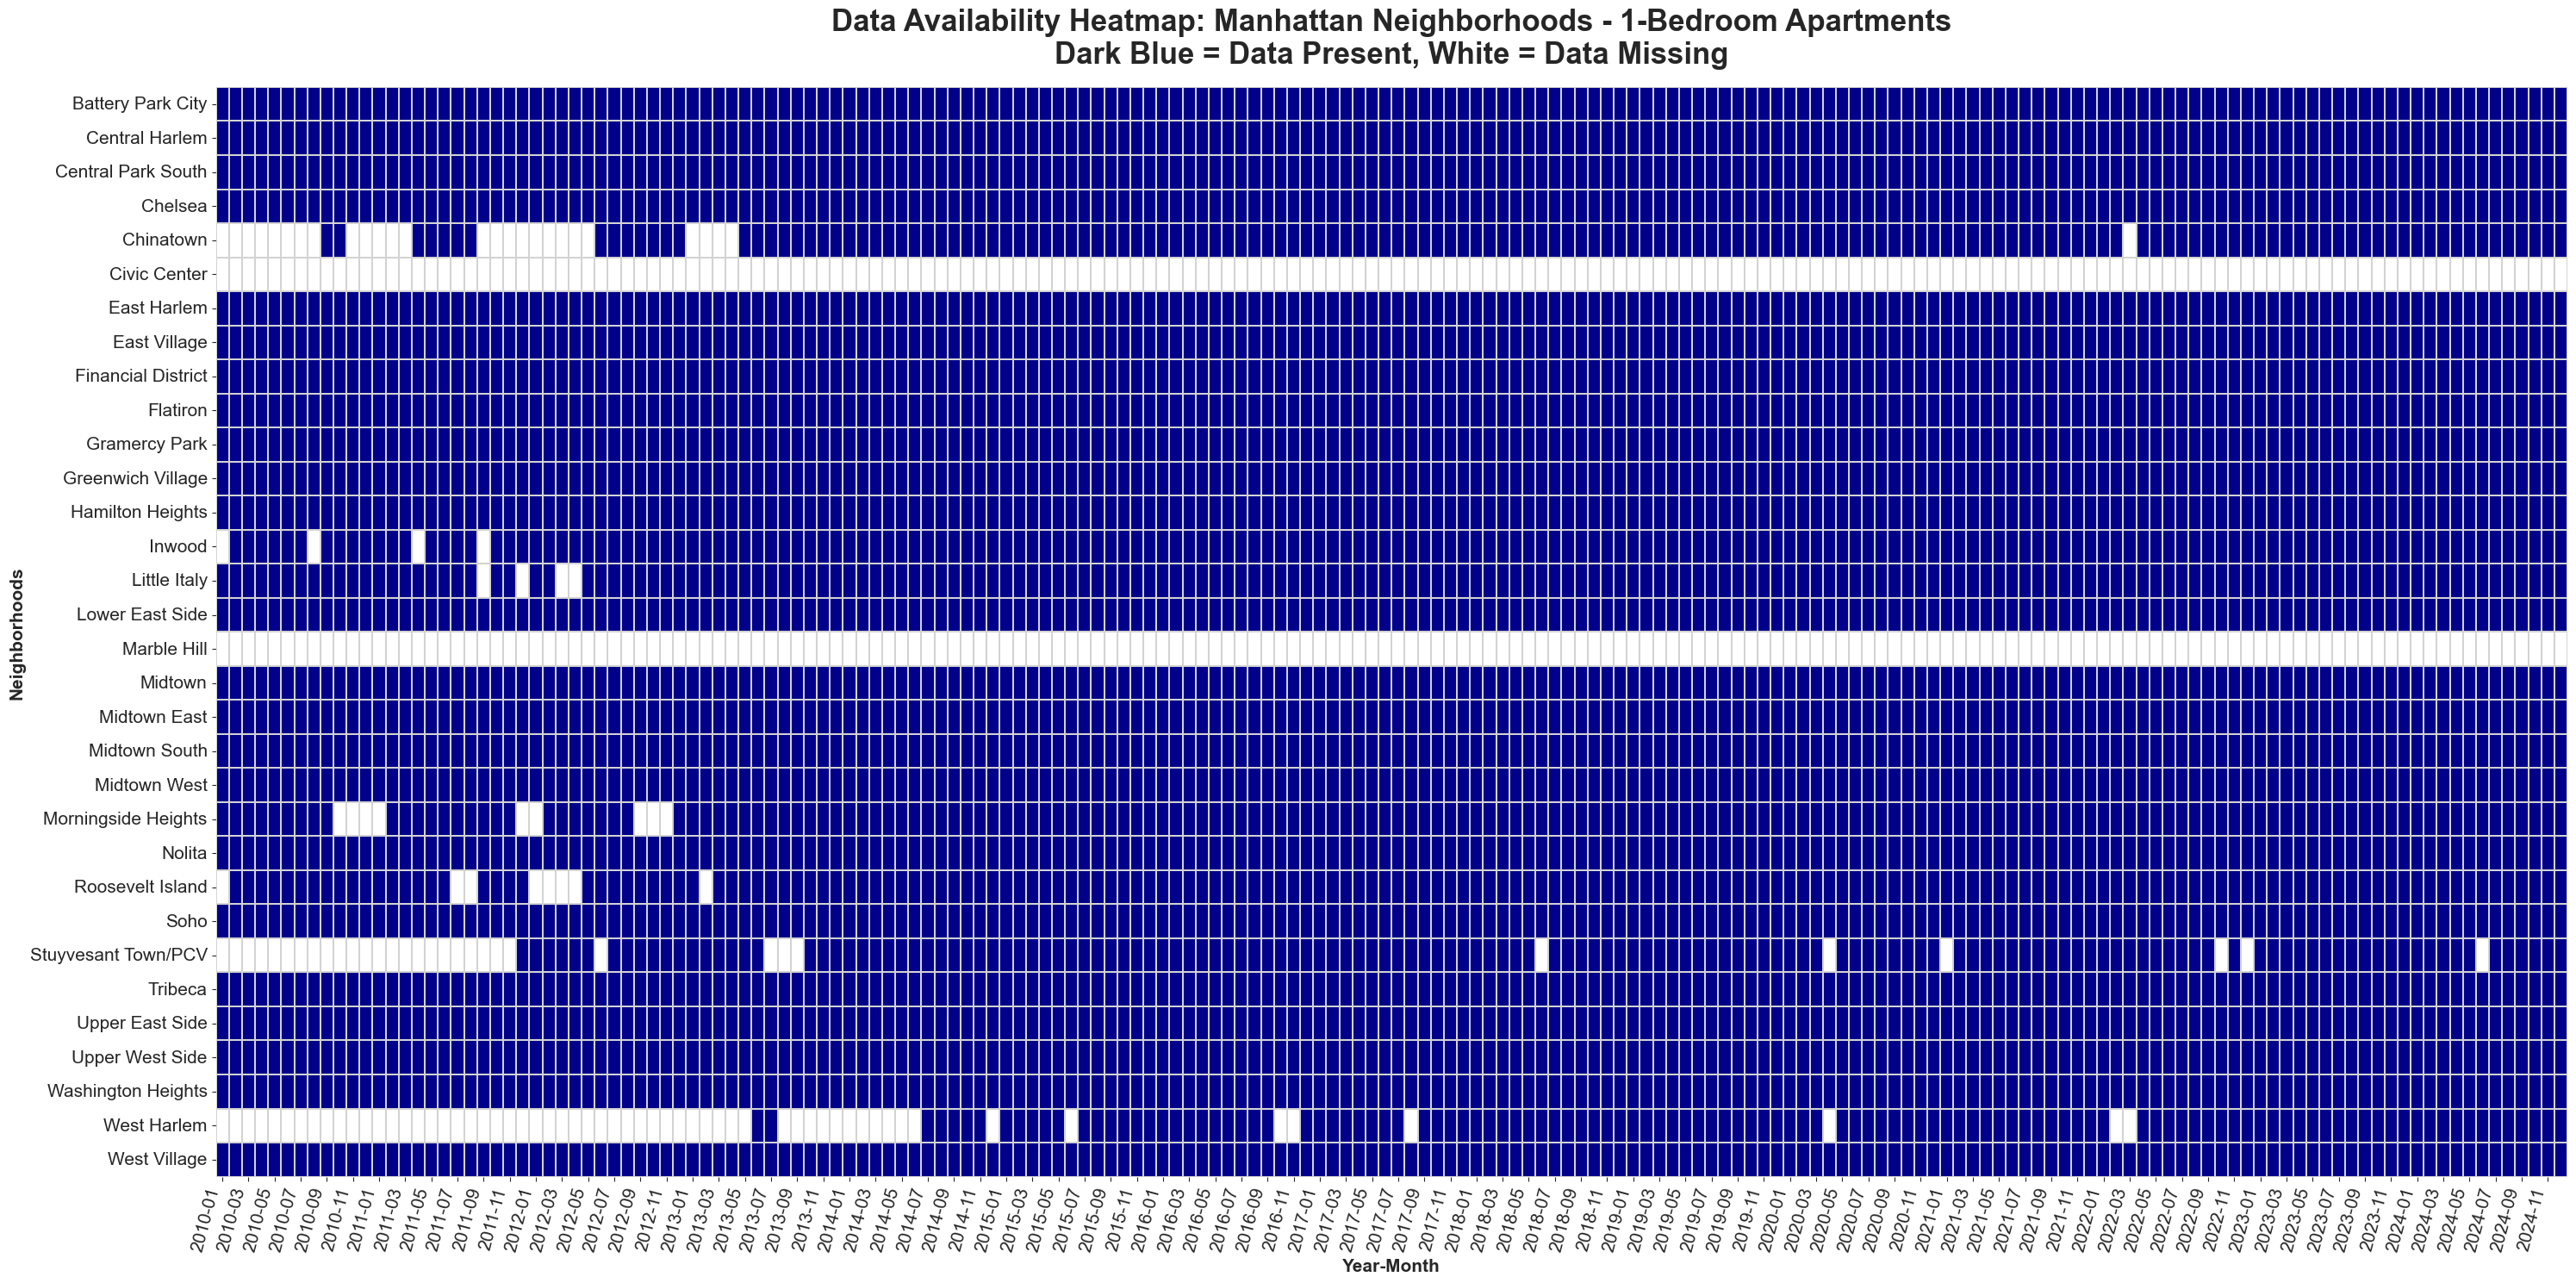

Data Availability Summary for Manhattan:
Total data points: 5760
Data present: 5255.0 (91.2%)
Data missing: 505.0 (8.8%)
Number of neighborhoods: 32
Number of time periods: 180


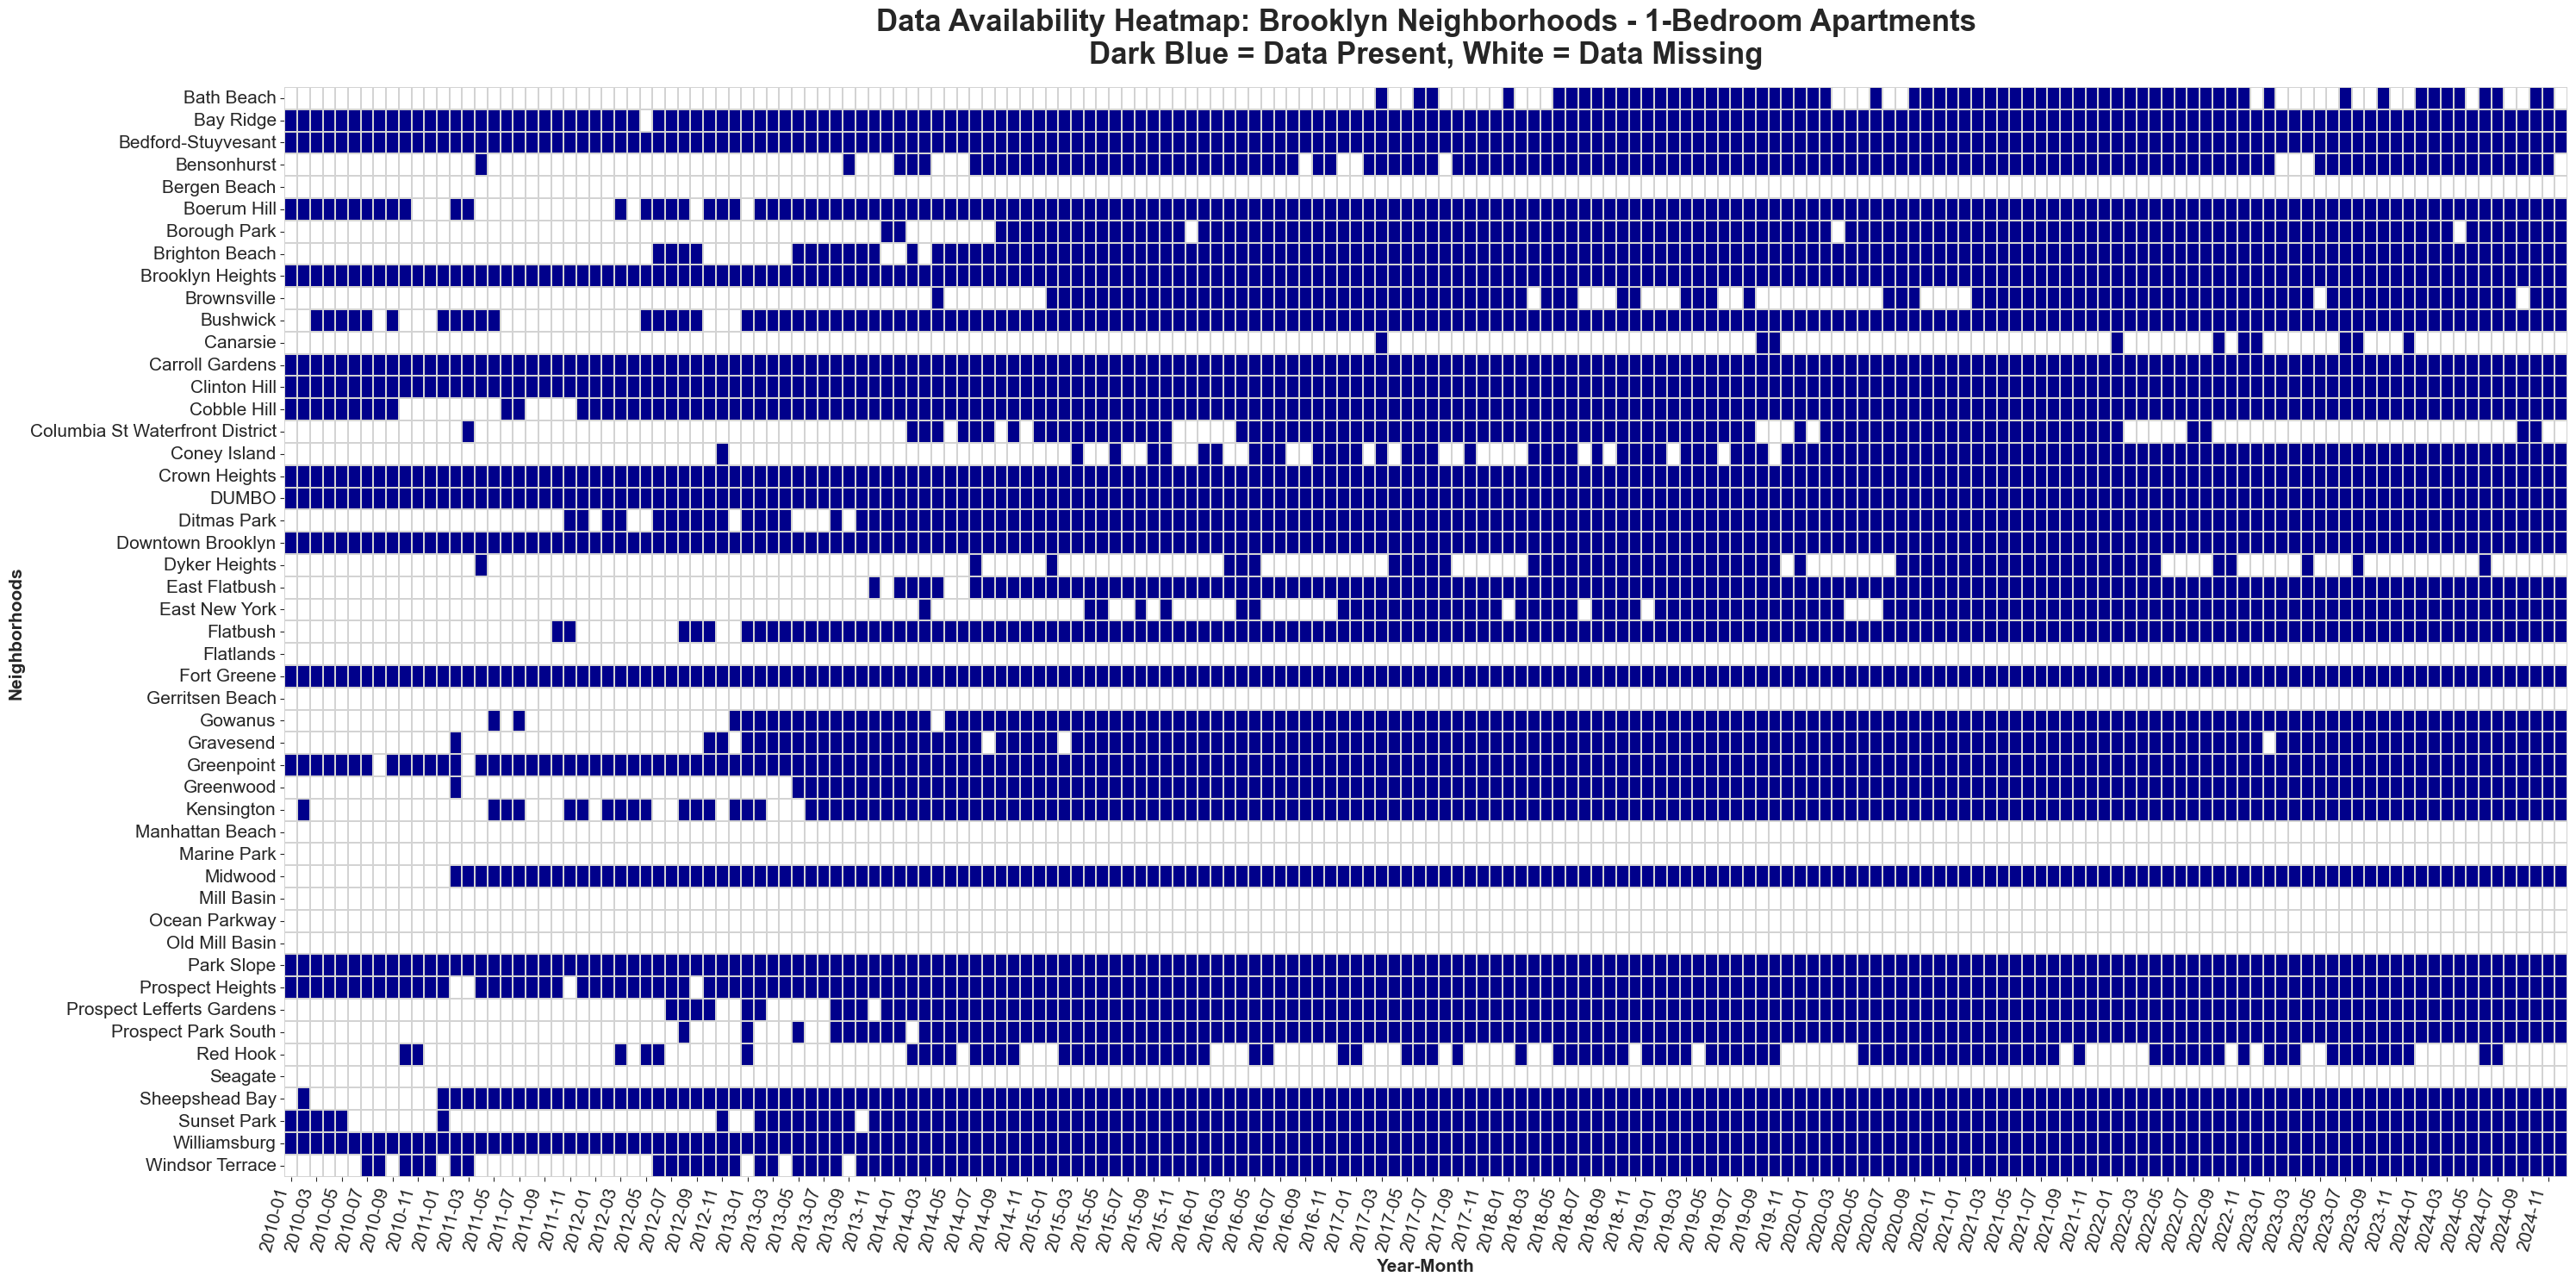

Data Availability Summary for Brooklyn:
Total data points: 8820
Data present: 5747.0 (65.2%)
Data missing: 3073.0 (34.8%)
Number of neighborhoods: 49
Number of time periods: 180


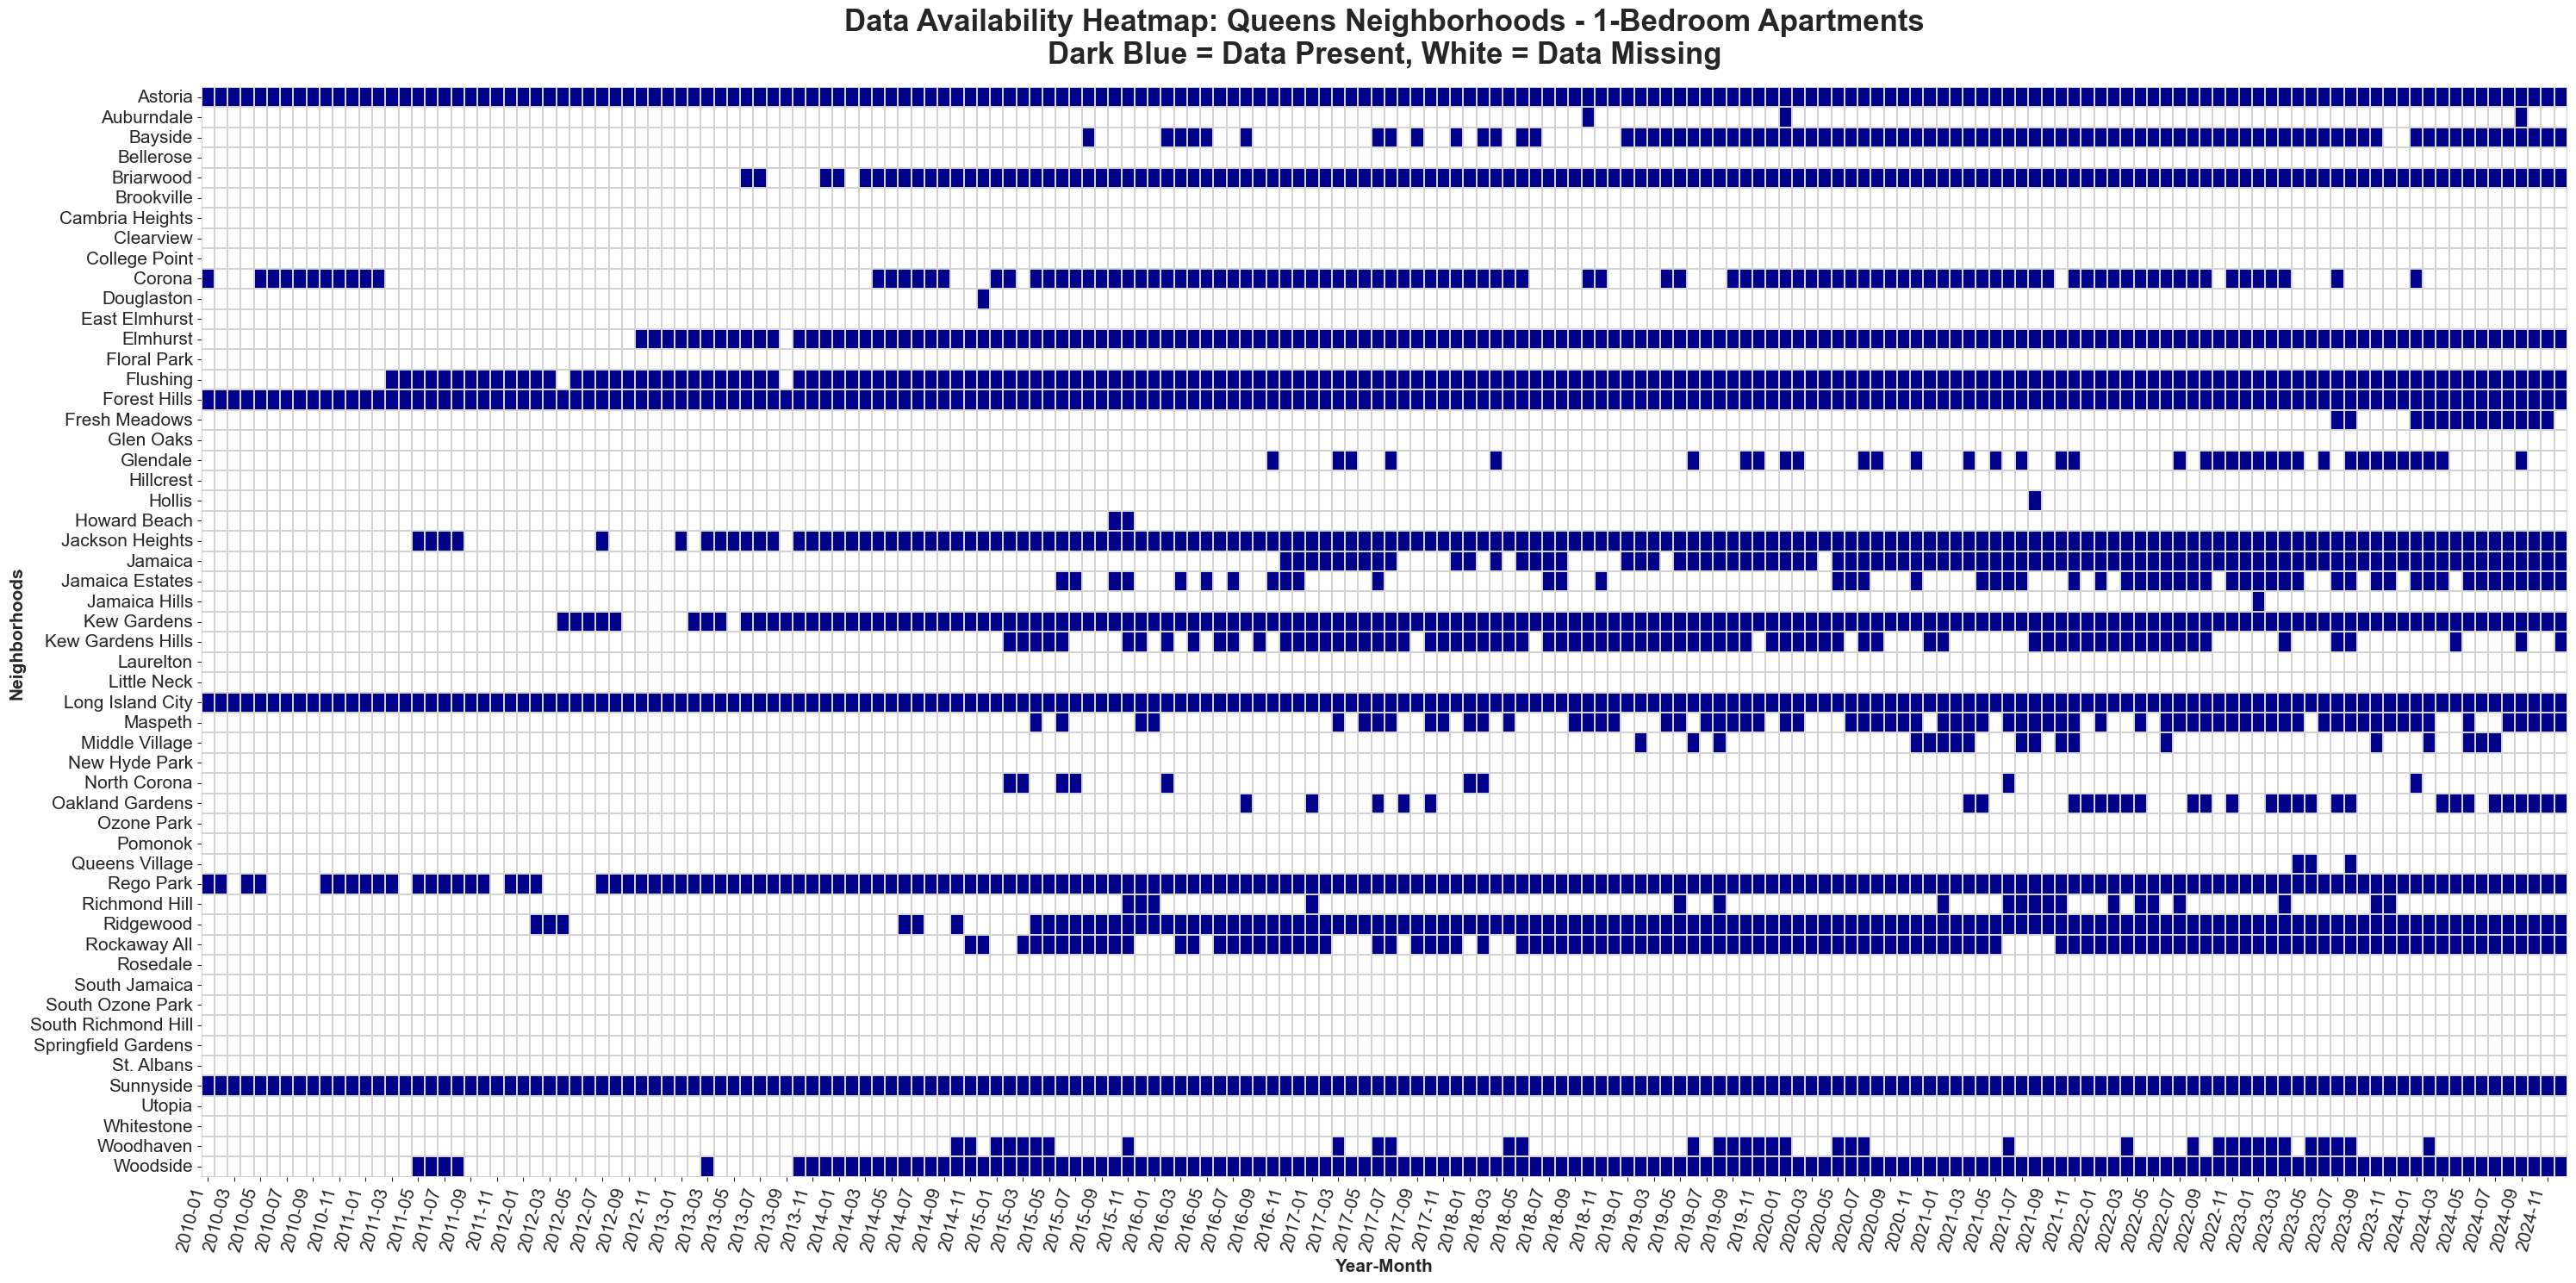

Data Availability Summary for Queens:
Total data points: 9720
Data present: 2642.0 (27.2%)
Data missing: 7078.0 (72.8%)
Number of neighborhoods: 54
Number of time periods: 180


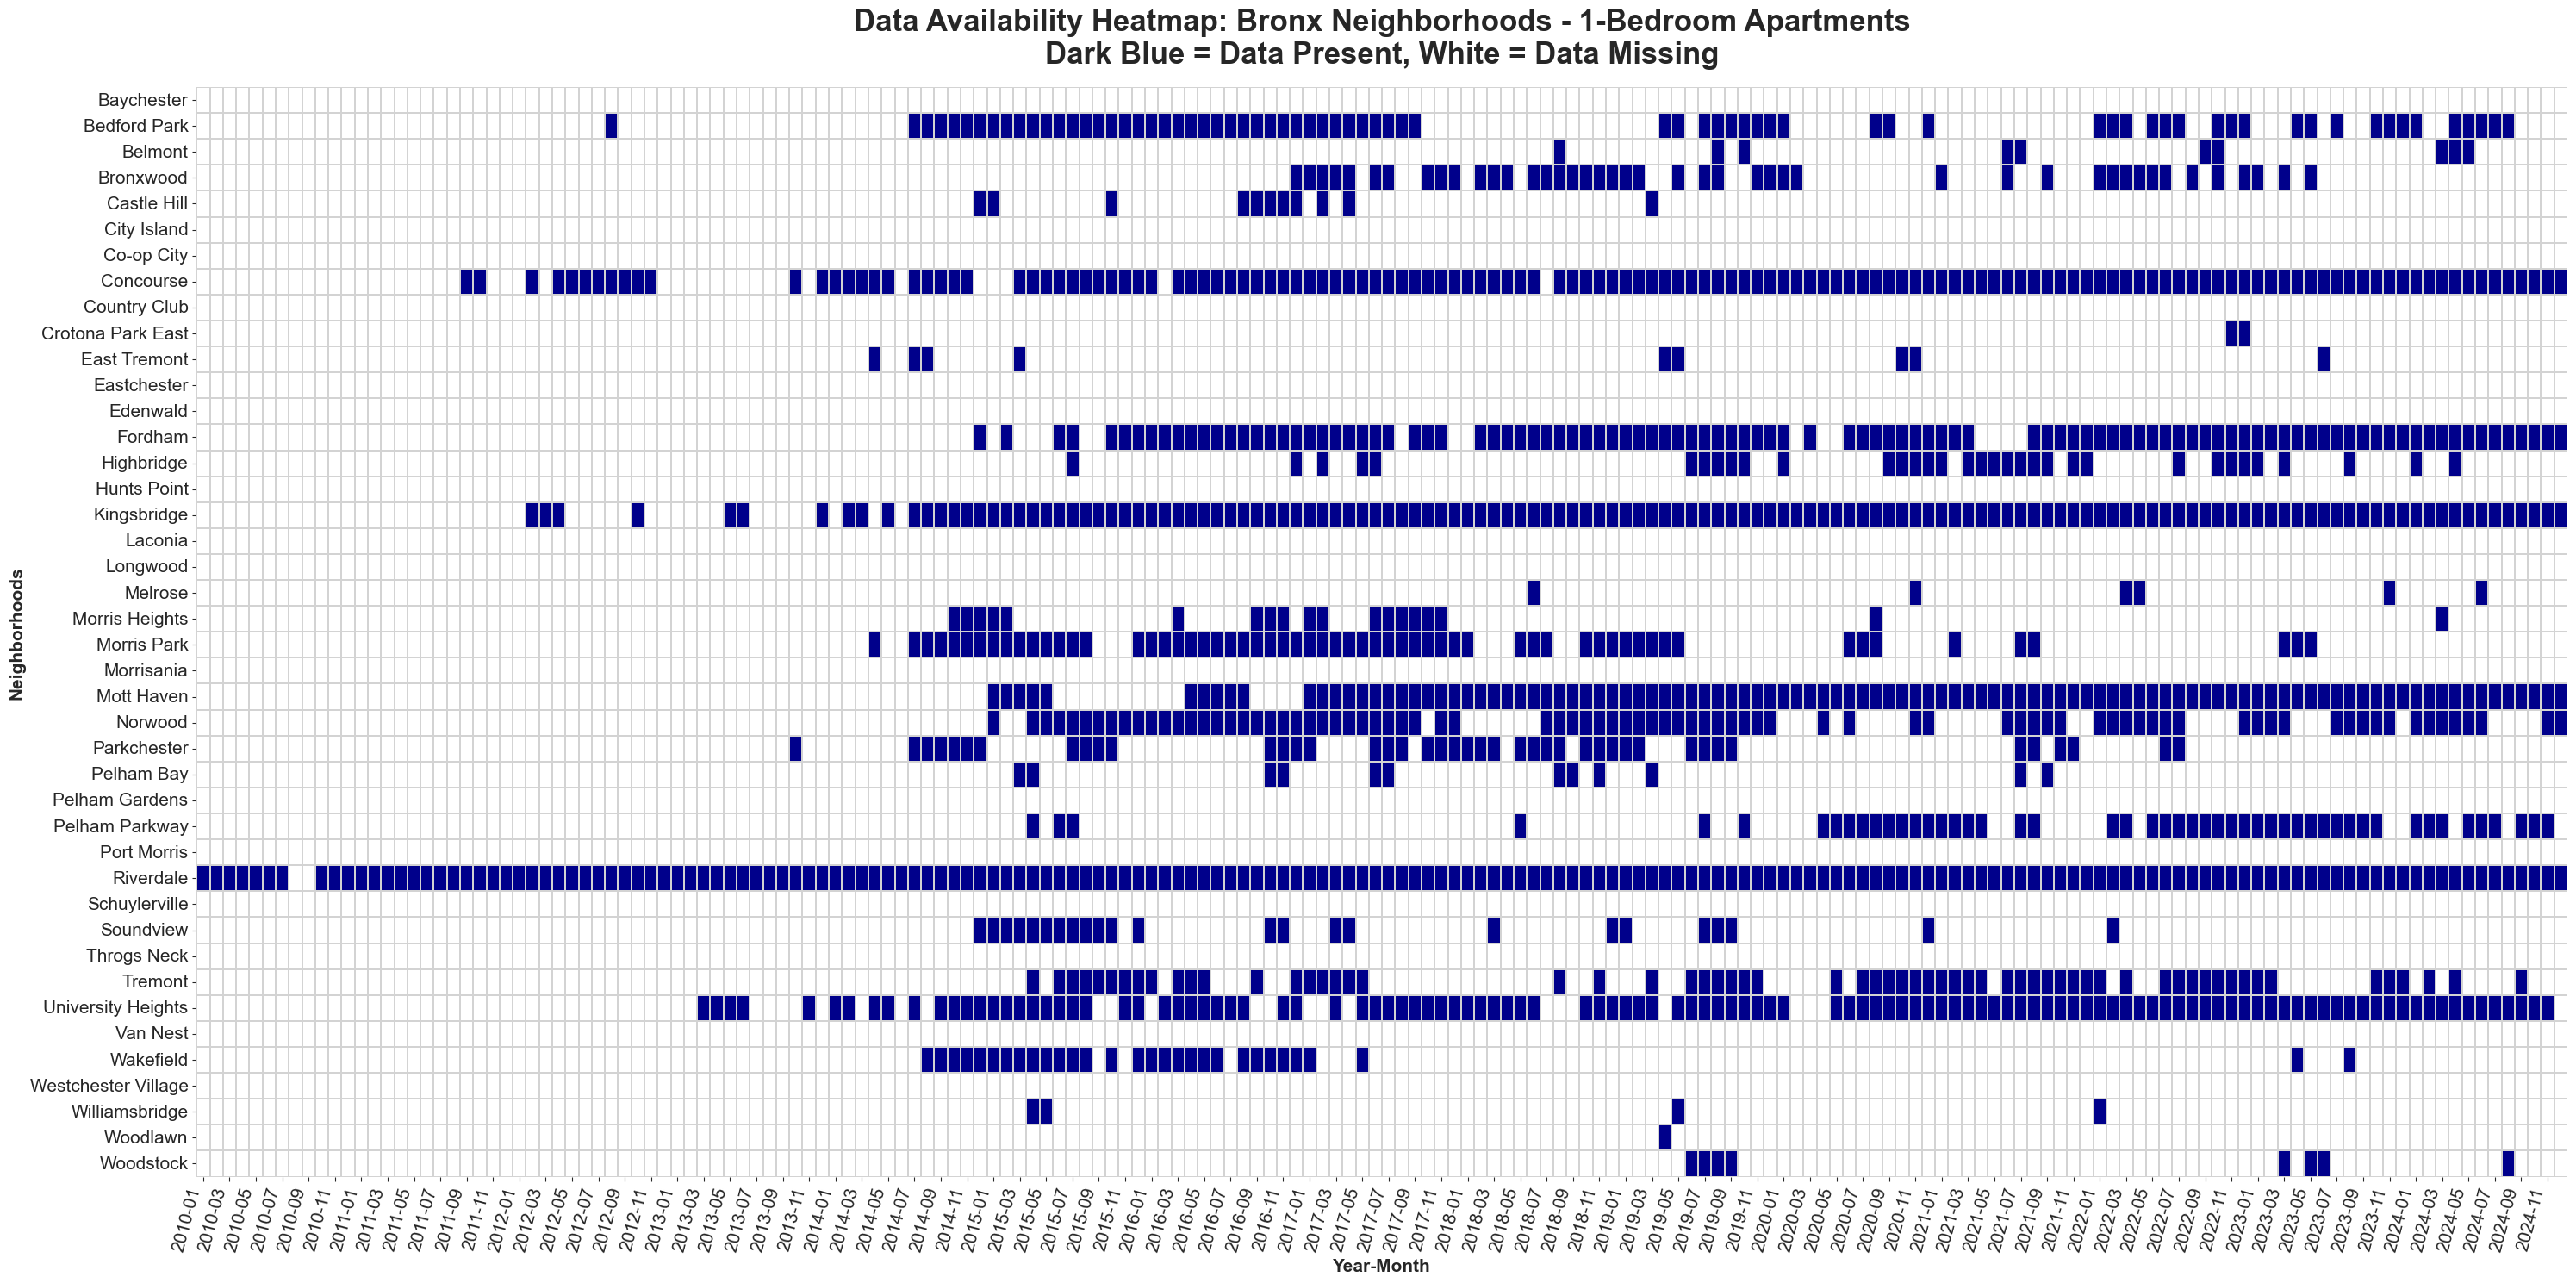

Data Availability Summary for Bronx:
Total data points: 7560
Data present: 1370.0 (18.1%)
Data missing: 6190.0 (81.9%)
Number of neighborhoods: 42
Number of time periods: 180


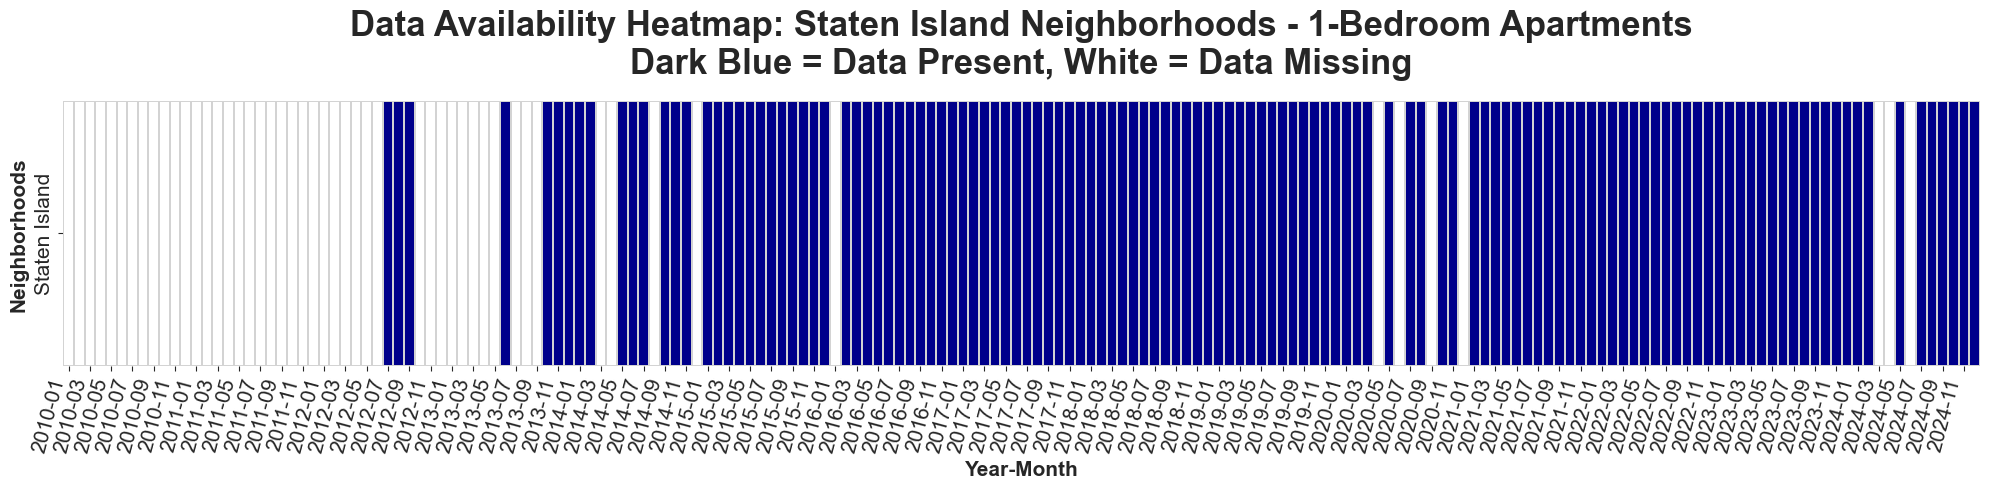

Data Availability Summary for Staten Island:
Total data points: 180
Data present: 127.0 (70.6%)
Data missing: 53.0 (29.4%)
Number of neighborhoods: 1
Number of time periods: 180


In [181]:
for borough in boroughs:
    if borough == 'Staten Island':
        create_data_availability_heatmap(df_rent_1bdr, borough, figsize=(20,5), subtitle='1-Bedroom Apartments')
    else:
        create_data_availability_heatmap(df_rent_1bdr, borough, subtitle='1-Bedroom Apartments')

#### 3-Bedroom Apartments

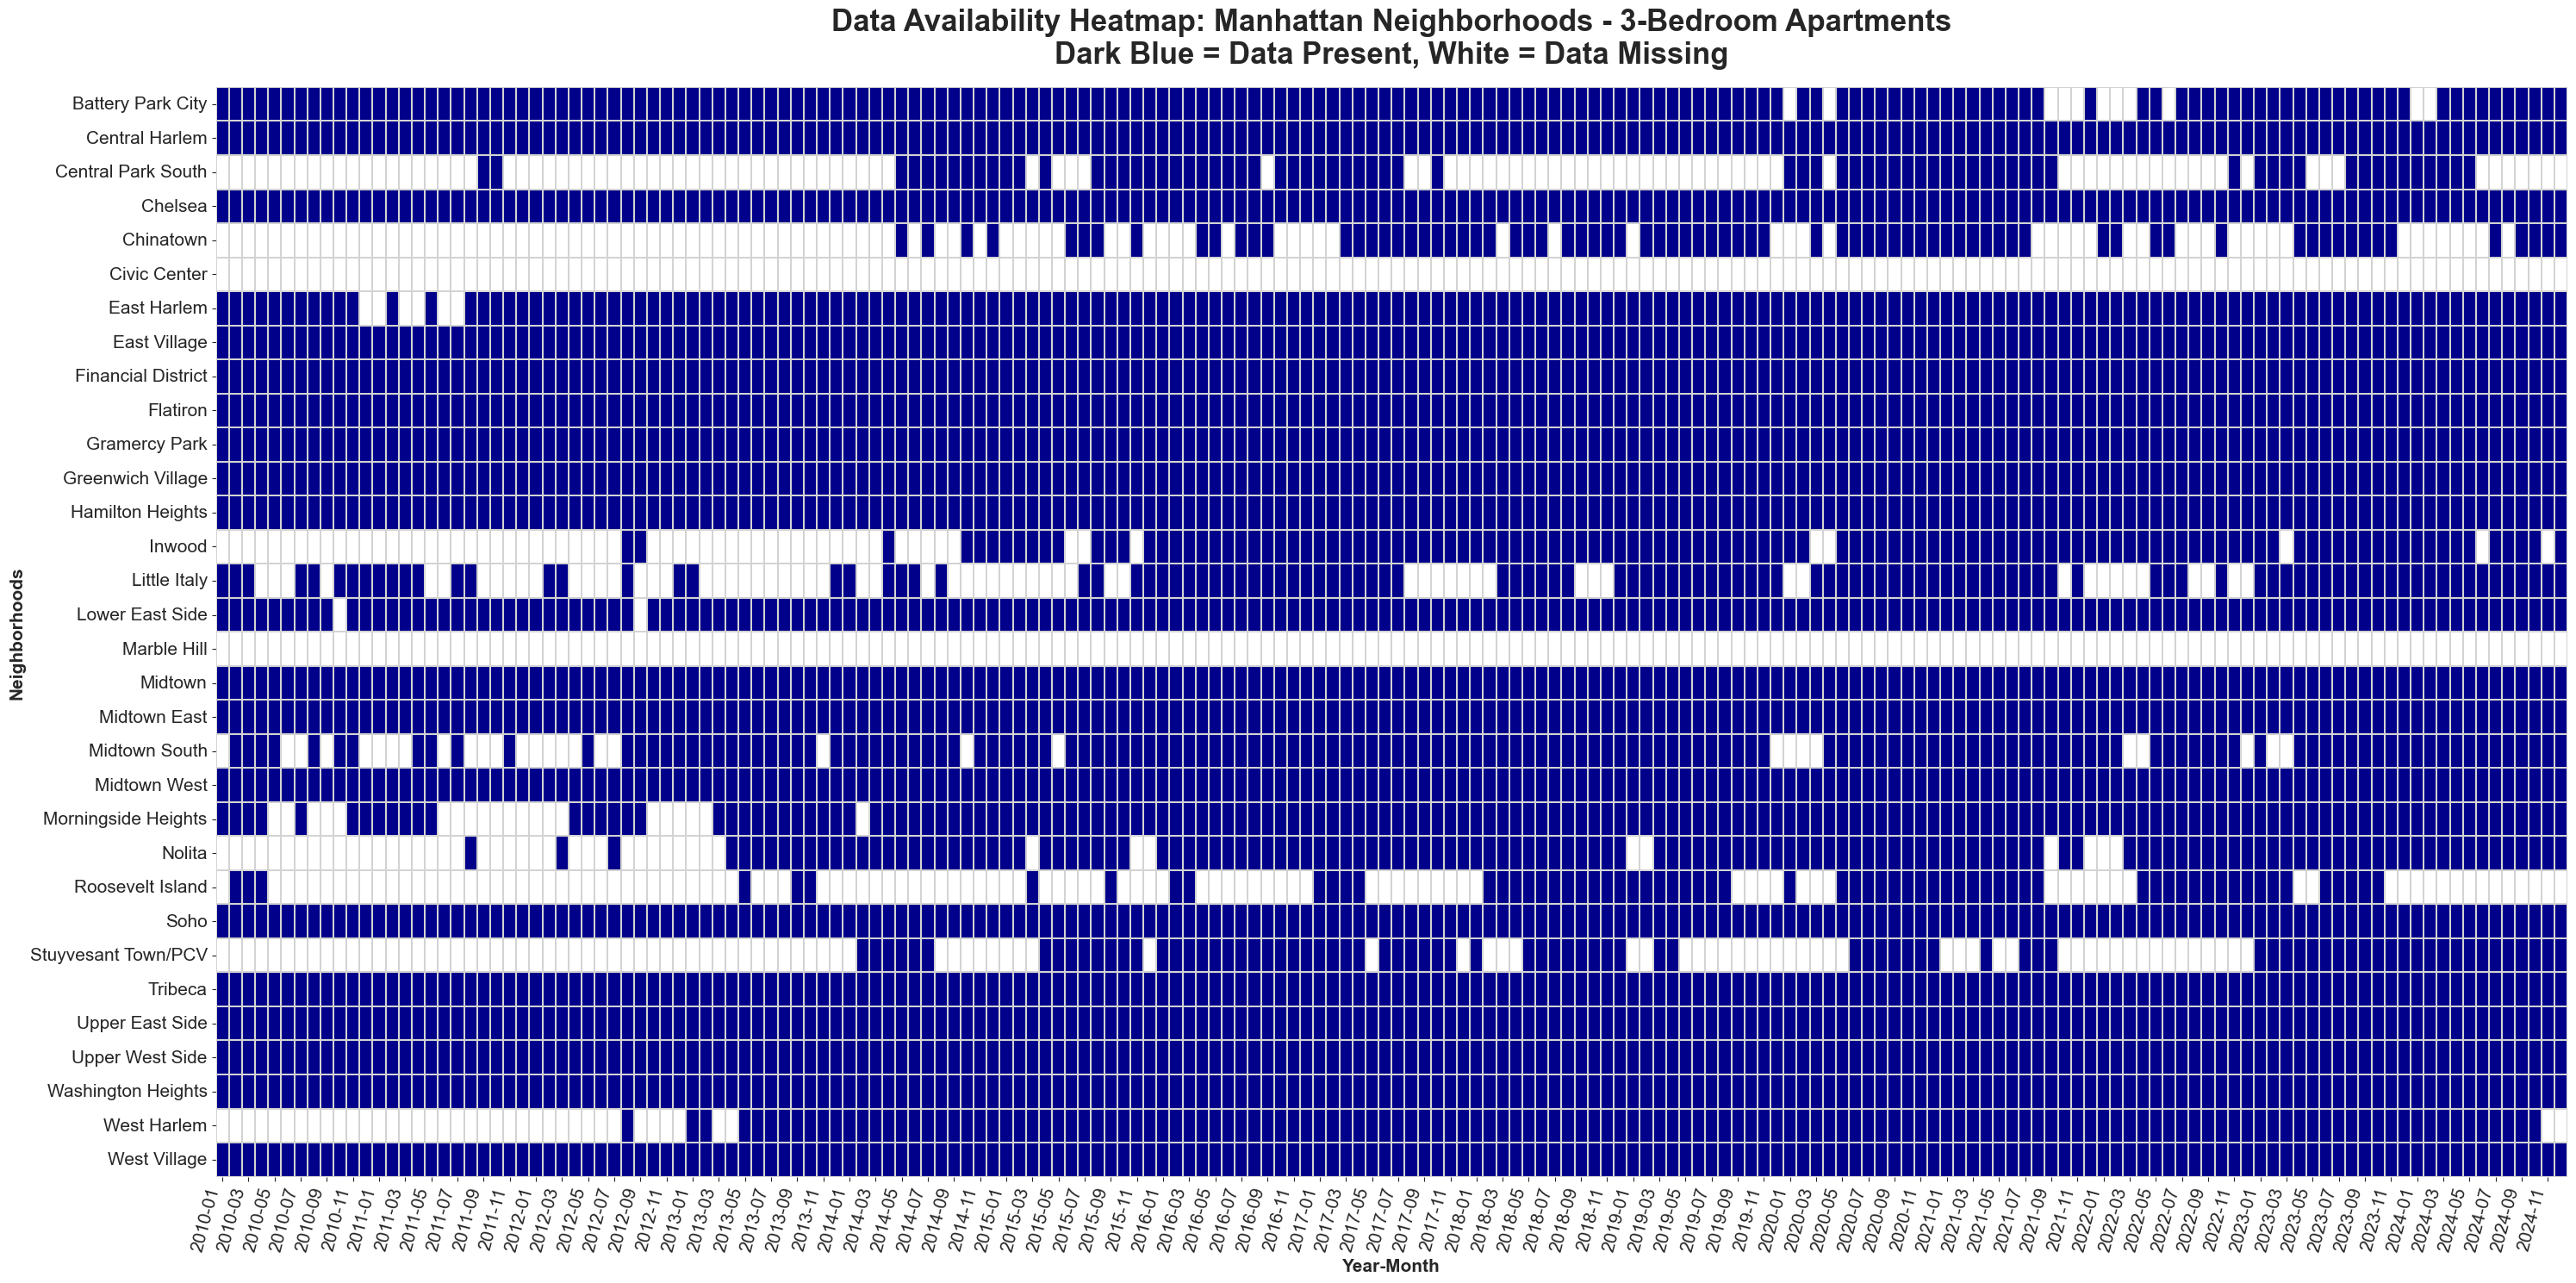

Data Availability Summary for Manhattan:
Total data points: 5760
Data present: 4696.0 (81.5%)
Data missing: 1064.0 (18.5%)
Number of neighborhoods: 32
Number of time periods: 180


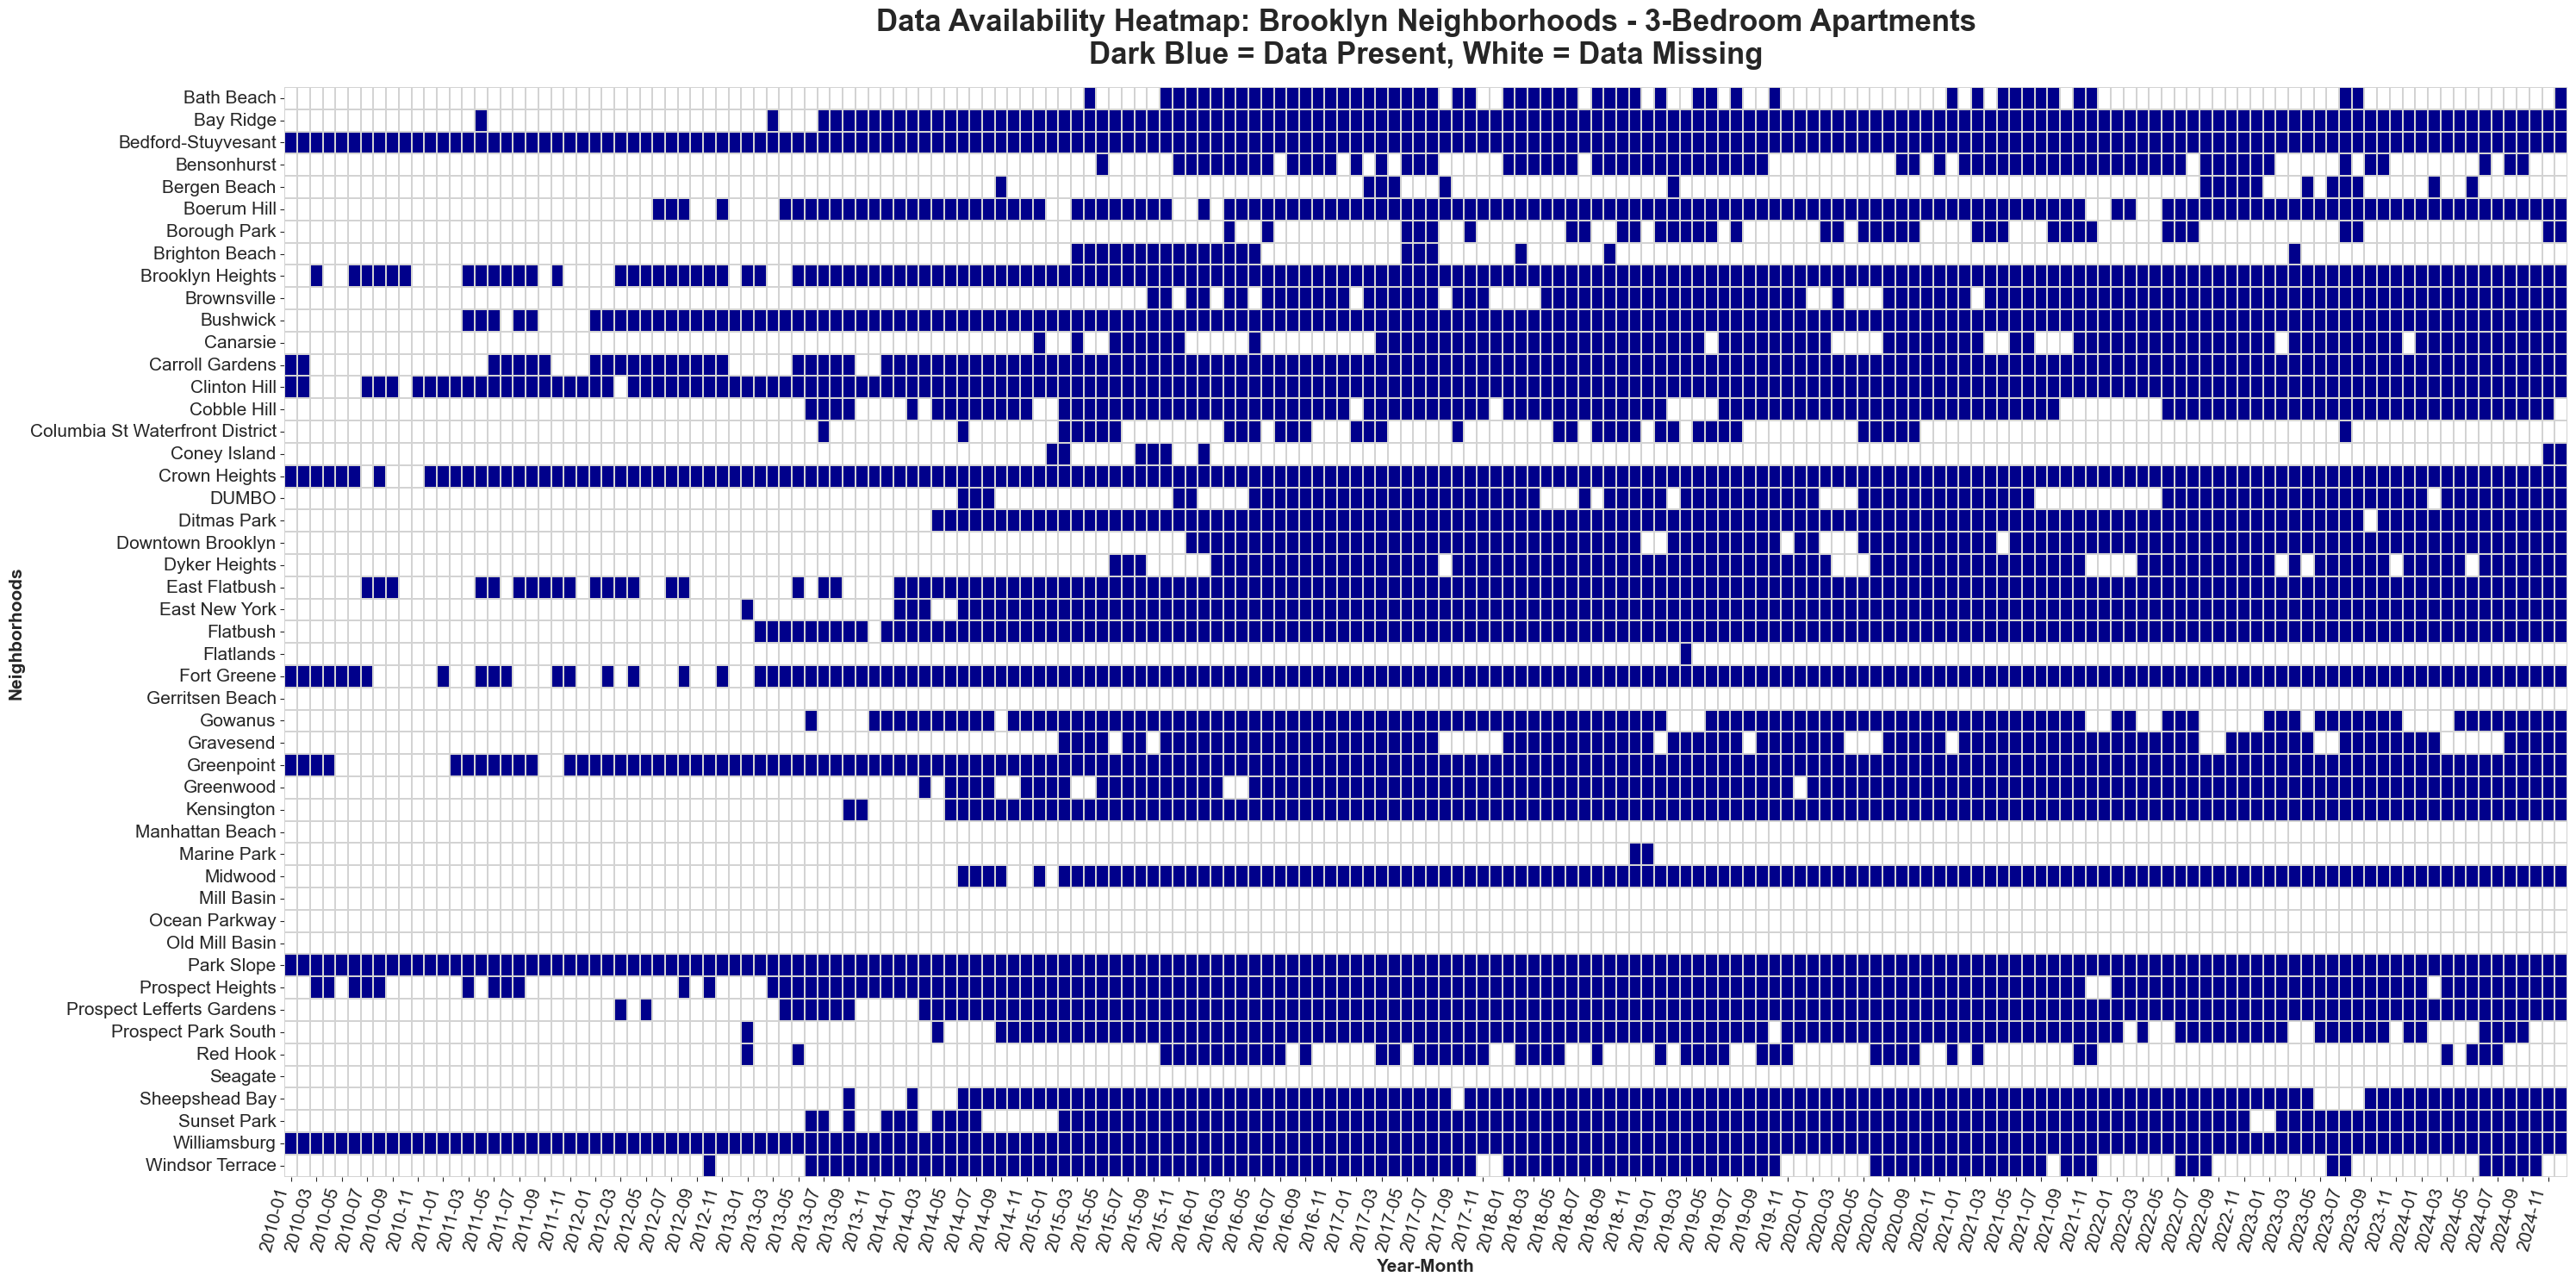

Data Availability Summary for Brooklyn:
Total data points: 8820
Data present: 4757.0 (53.9%)
Data missing: 4063.0 (46.1%)
Number of neighborhoods: 49
Number of time periods: 180


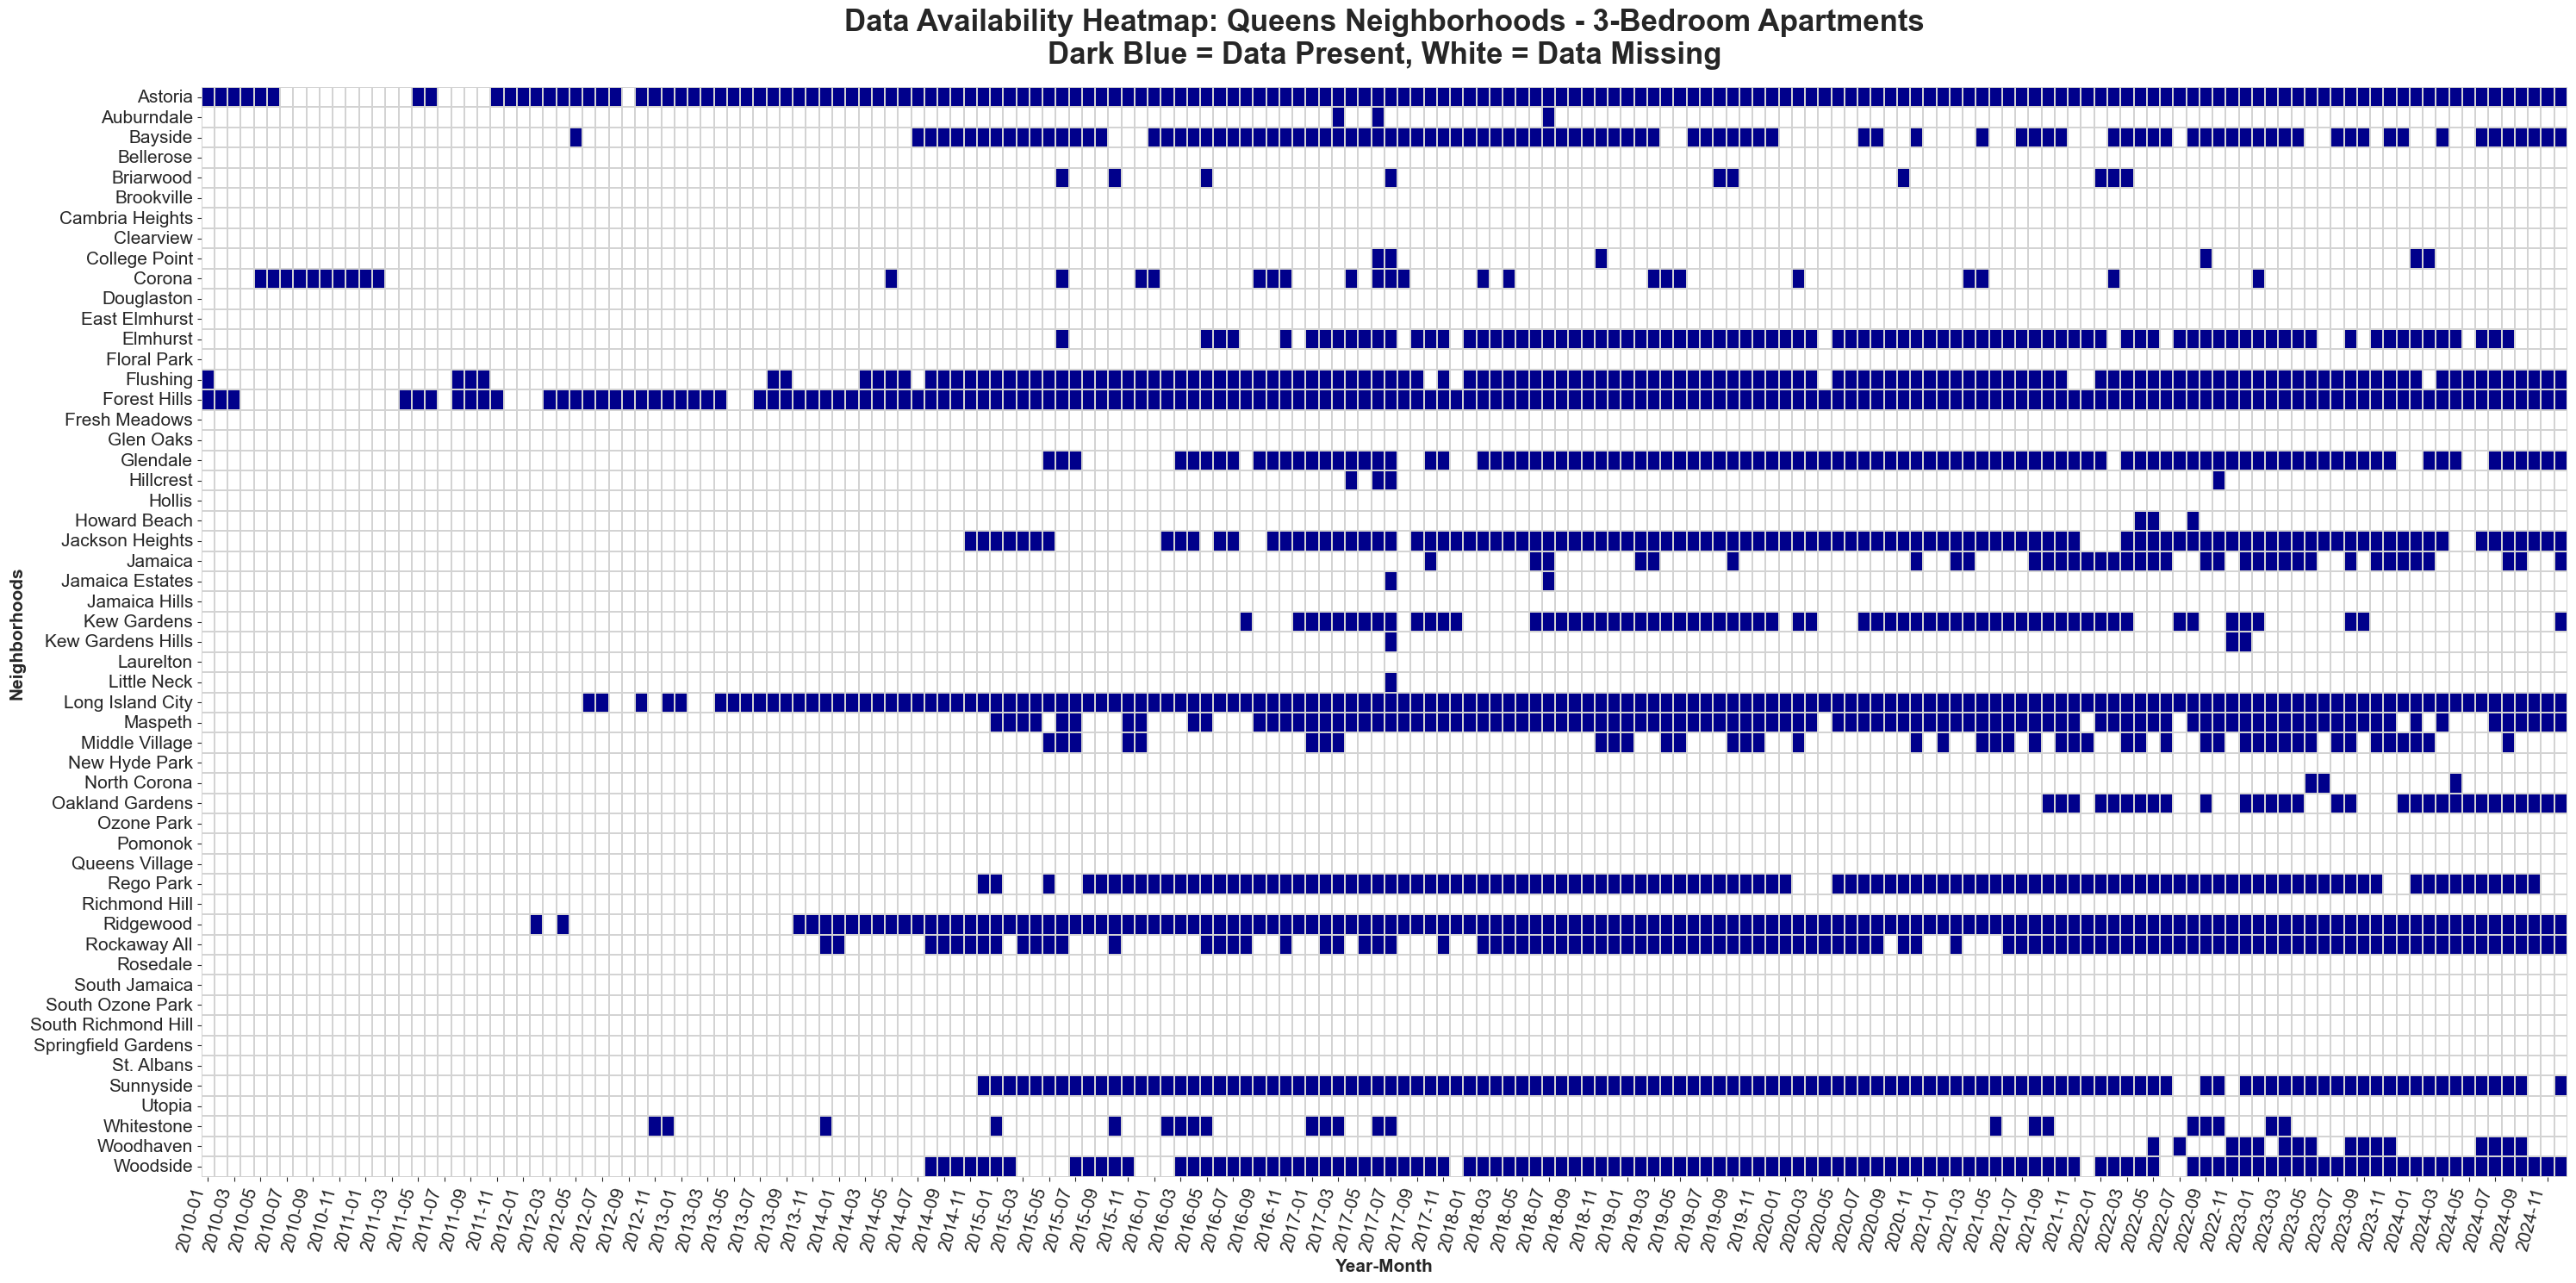

Data Availability Summary for Queens:
Total data points: 9720
Data present: 1949.0 (20.1%)
Data missing: 7771.0 (79.9%)
Number of neighborhoods: 54
Number of time periods: 180


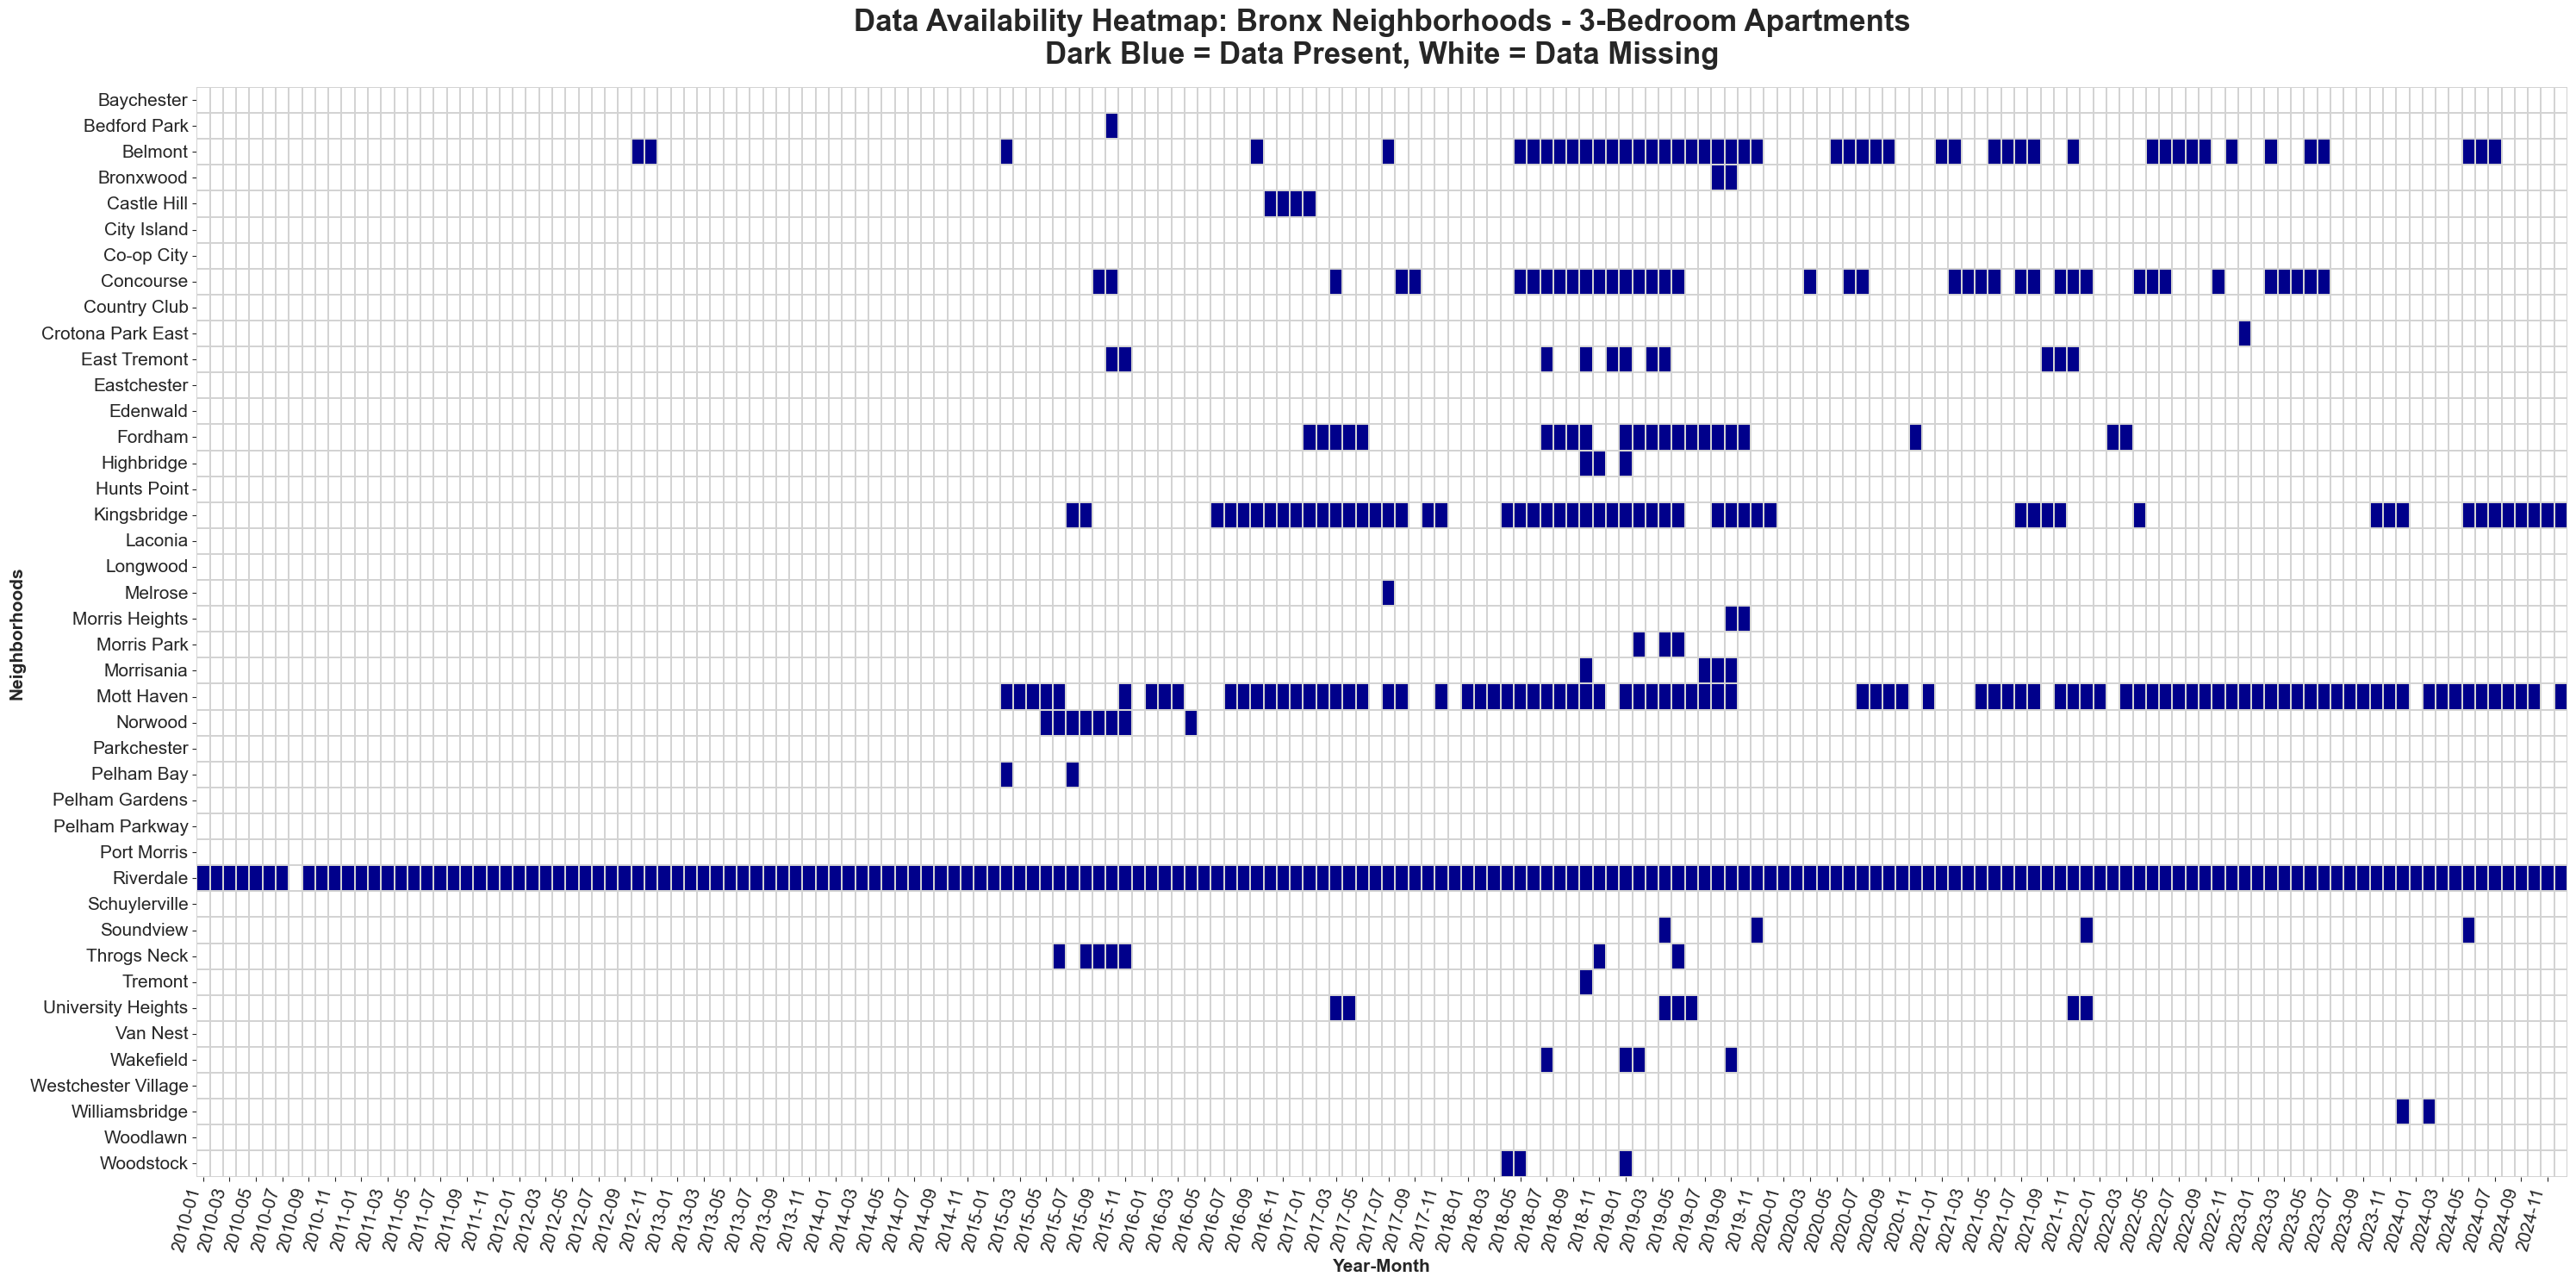

Data Availability Summary for Bronx:
Total data points: 7560
Data present: 501.0 (6.6%)
Data missing: 7059.0 (93.4%)
Number of neighborhoods: 42
Number of time periods: 180


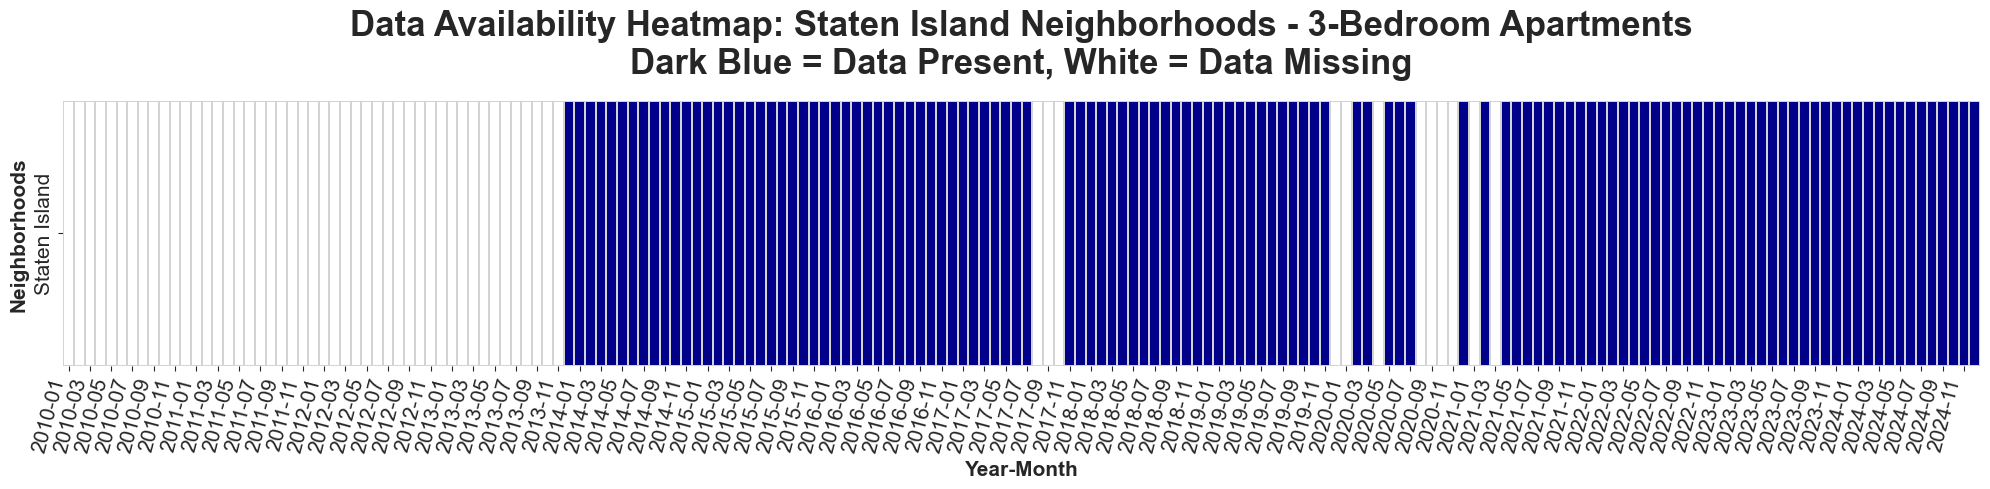

Data Availability Summary for Staten Island:
Total data points: 180
Data present: 121.0 (67.2%)
Data missing: 59.0 (32.8%)
Number of neighborhoods: 1
Number of time periods: 180


In [182]:
for borough in boroughs:
    if borough == 'Staten Island':
        create_data_availability_heatmap(df_rent_3bdr, borough, figsize=(20,5), subtitle='3-Bedroom Apartments')
    else:
        create_data_availability_heatmap(df_rent_3bdr, borough, subtitle='3-Bedroom Apartments')

# Importing, Visualizing, and Understanding Income Data

In [5]:
# 2. Downloading ACS data using Census API
ACS_Tables = [
    'B19013_001E',  # All HHs - median income
    'B19202_001E',  # 1-person HH - median income
    'B19131_002E',  # Married HHs w/ children - median income
    'B19131_005E',  # Other HHs w/ children - median income (foster, grandparents, etc.)
    ]

# Importing Median Income for All Households (B19013_001E)
median_HH_income_all = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                        ACS_Tables[0])

# Importing Median Income for Single Adult Households (B19202_001E)
median_HH_income_singles = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                            ACS_Tables[1])

# Importing Median Income for Married Households w/ Children (B19131_002E)
median_HH_income_married_kids = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                            ACS_Tables[2])

# Importing Median Income for Other Households w/ Children (B19131_005E)
median_HH_income_other_kids = Import_ACS_Table(os.getenv('CENSUS_API'), 36,
                                            ACS_Tables[3])

median_HH_income_all.head()

NAME B19013_001E state  \
0  NYC-Bronx Community District 1 & 2--Hunts Poin...       19122    36   
1  NYC-Bronx Community District 1 & 2--Hunts Poin...       20966    36   
2  NYC-Bronx Community District 1 & 2--Hunts Poin...       21116    36   
3  NYC-Bronx Community District 1 & 2--Hunts Poin...       23083    36   
4  NYC-Bronx Community District 1 & 2--Hunts Poin...       24408    36   

  public use microdata area  year  
0                     03710  2012  
1                     03710  2017  
2                     03710  2014  
3                     03710  2013  
4                     03710  2015

## Let's get familiar with our Income data!

### Time series of Median Household Income

#### All Households

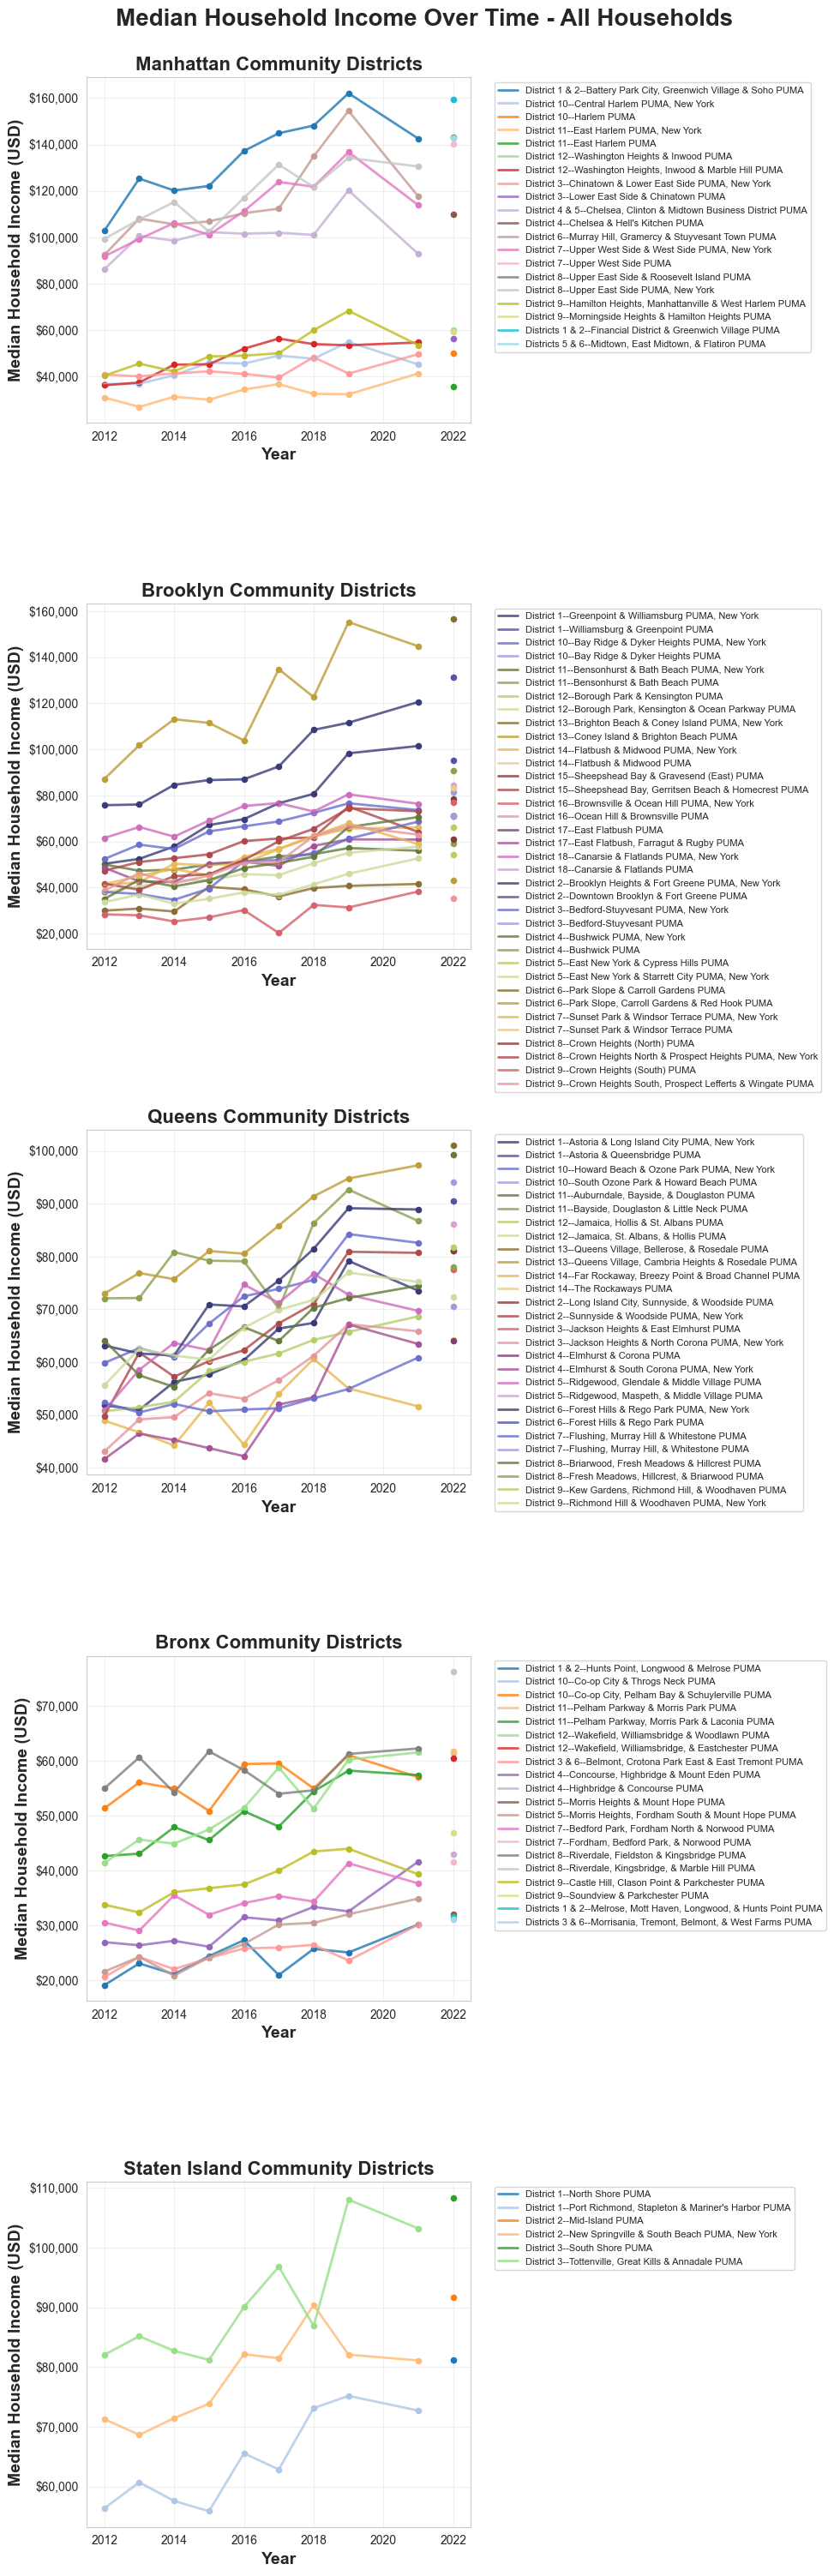

Data Summary by Borough:
--------------------------------------------------
Manhattan: 20 districts, $81,532 avg income (2012-2022)
Brooklyn: 36 districts, $60,276 avg income (2012-2022)
Queens: 28 districts, $66,335 avg income (2012-2022)
Bronx: 20 districts, $40,384 avg income (2012-2022)
Staten Island: 6 districts, $79,335 avg income (2012-2022)


In [5]:
# Ensuring data is in numeric format
median_HH_income_all['B19013_001E'] = pd.to_numeric(median_HH_income_all['B19013_001E'], errors='coerce')
median_HH_income_all['year'] = pd.to_numeric(median_HH_income_all['year'], errors='coerce')
# Remove any rows where conversion failed (NaN values)
median_HH_income_all = median_HH_income_all.dropna(subset=['B19013_001E', 'year'])

# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = median_HH_income_all[median_HH_income_all['NAME'].str.contains(borough, case=False)]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['NAME'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['NAME'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['B19013_001E'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['B19013_001E'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - All Households', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = median_HH_income_all[median_HH_income_all['NAME'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['B19013_001E'].mean()
        num_districts = borough_data['NAME'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts, ${avg_income:,.0f} avg income ({year_range})")

#### Single Adults

In [7]:
median_HH_income_singles.head()

NAME B19202_001E state  \
0  NYC-Bronx Community District 1 & 2--Hunts Poin...       11516    36   
1  NYC-Bronx Community District 1 & 2--Hunts Poin...       11638    36   
2  NYC-Bronx Community District 1 & 2--Hunts Poin...       11660    36   
3  NYC-Bronx Community District 1 & 2--Hunts Poin...       12355    36   
4  NYC-Bronx Community District 1 & 2--Hunts Poin...       12739    36   

  public use microdata area  year  
0                     03710  2015  
1                     03710  2016  
2                     03710  2017  
3                     03710  2012  
4                     03710  2014

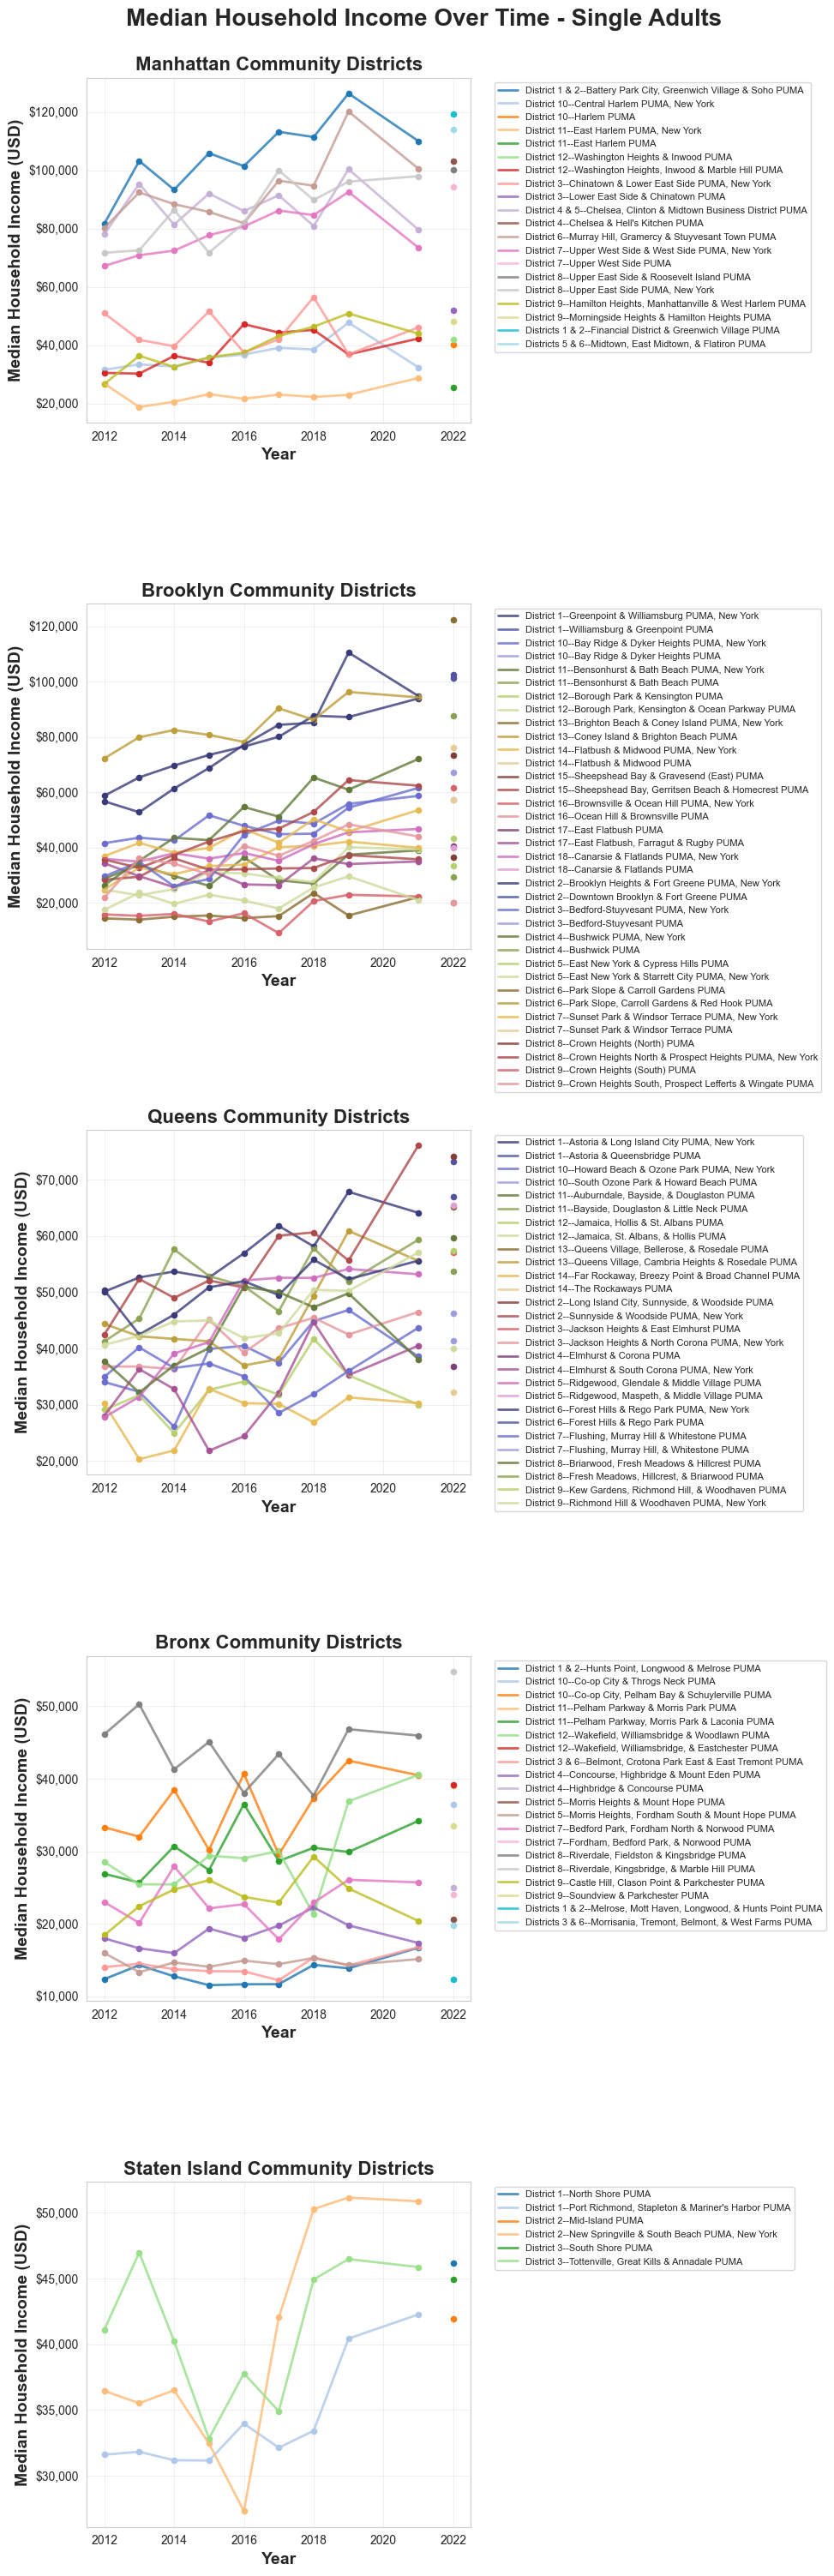

Data Summary by Borough:
--------------------------------------------------
Manhattan: 20 districts, $64,238 avg income (2012-2022)
Brooklyn: 36 districts, $44,013 avg income (2012-2022)
Queens: 28 districts, $44,241 avg income (2012-2022)
Bronx: 20 districts, $25,275 avg income (2012-2022)
Staten Island: 6 districts, $39,159 avg income (2012-2022)


In [9]:
# Ensuring data is in numeric format
median_HH_income_singles['B19202_001E'] = pd.to_numeric(median_HH_income_singles['B19202_001E'], errors='coerce')
median_HH_income_singles['year'] = pd.to_numeric(median_HH_income_singles['year'], errors='coerce')
# Remove any rows where conversion failed (NaN values)
median_HH_income_singles = median_HH_income_singles.dropna(subset=['B19202_001E', 'year'])

# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = median_HH_income_singles[median_HH_income_singles['NAME'].str.contains(borough, case=False)]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['NAME'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['NAME'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['B19202_001E'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['B19202_001E'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - Single Adults', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = median_HH_income_singles[median_HH_income_singles['NAME'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['B19202_001E'].mean()
        num_districts = borough_data['NAME'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts, ${avg_income:,.0f} avg income ({year_range})")

#### Married Families with Children

In [10]:
median_HH_income_married_kids.head()

NAME B19131_002E state  \
0  NYC-Bronx Community District 1 & 2--Hunts Poin...       11047    36   
1  NYC-Bronx Community District 1 & 2--Hunts Poin...        9559    36   
2  NYC-Bronx Community District 1 & 2--Hunts Poin...        9861    36   
3  NYC-Bronx Community District 1 & 2--Hunts Poin...        None    36   
4  NYC-Bronx Community District 1 & 2--Hunts Poin...        None    36   

  public use microdata area  year  
0                     03710  2015  
1                     03710  2014  
2                     03710  2012  
3                     03710  2013  
4                     03710  2016

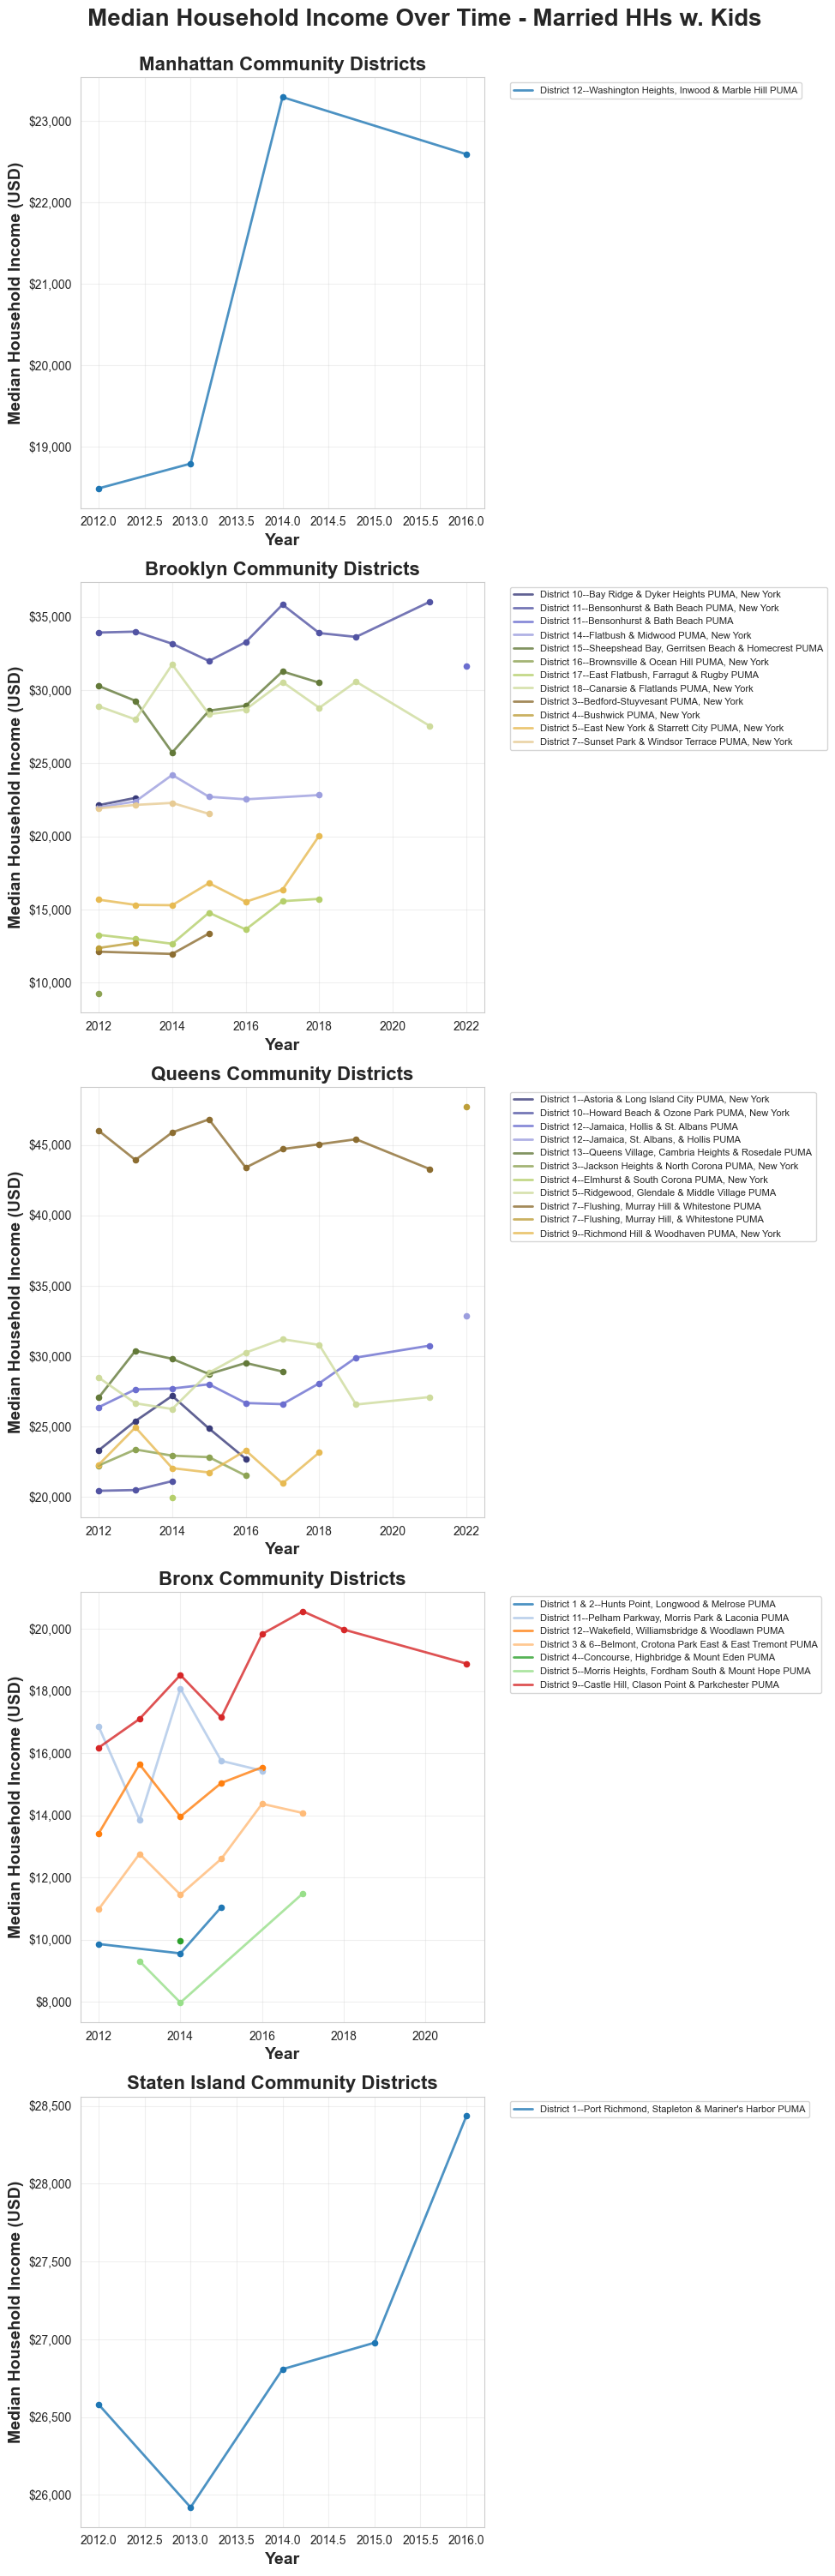

Data Summary by Borough:
--------------------------------------------------
Manhattan: 1 districts, $20,793 avg income (2012-2016)
Brooklyn: 12 districts, $23,449 avg income (2012-2022)
Queens: 11 districts, $29,355 avg income (2012-2022)
Bronx: 7 districts, $14,427 avg income (2012-2021)
Staten Island: 1 districts, $26,944 avg income (2012-2016)


In [12]:
# Ensuring data is in numeric format
median_HH_income_married_kids['B19131_002E'] = pd.to_numeric(median_HH_income_married_kids['B19131_002E'], errors='coerce')
median_HH_income_married_kids['year'] = pd.to_numeric(median_HH_income_married_kids['year'], errors='coerce')
# Remove any rows where conversion failed (NaN values)
median_HH_income_married_kids = median_HH_income_married_kids.dropna(subset=['B19131_002E', 'year'])

# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = median_HH_income_married_kids[median_HH_income_married_kids['NAME'].str.contains(borough, case=False)]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['NAME'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['NAME'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['B19131_002E'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['B19131_002E'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - Married HHs w. Kids', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = median_HH_income_married_kids[median_HH_income_married_kids['NAME'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['B19131_002E'].mean()
        num_districts = borough_data['NAME'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts, ${avg_income:,.0f} avg income ({year_range})")

#### Other Families with Children

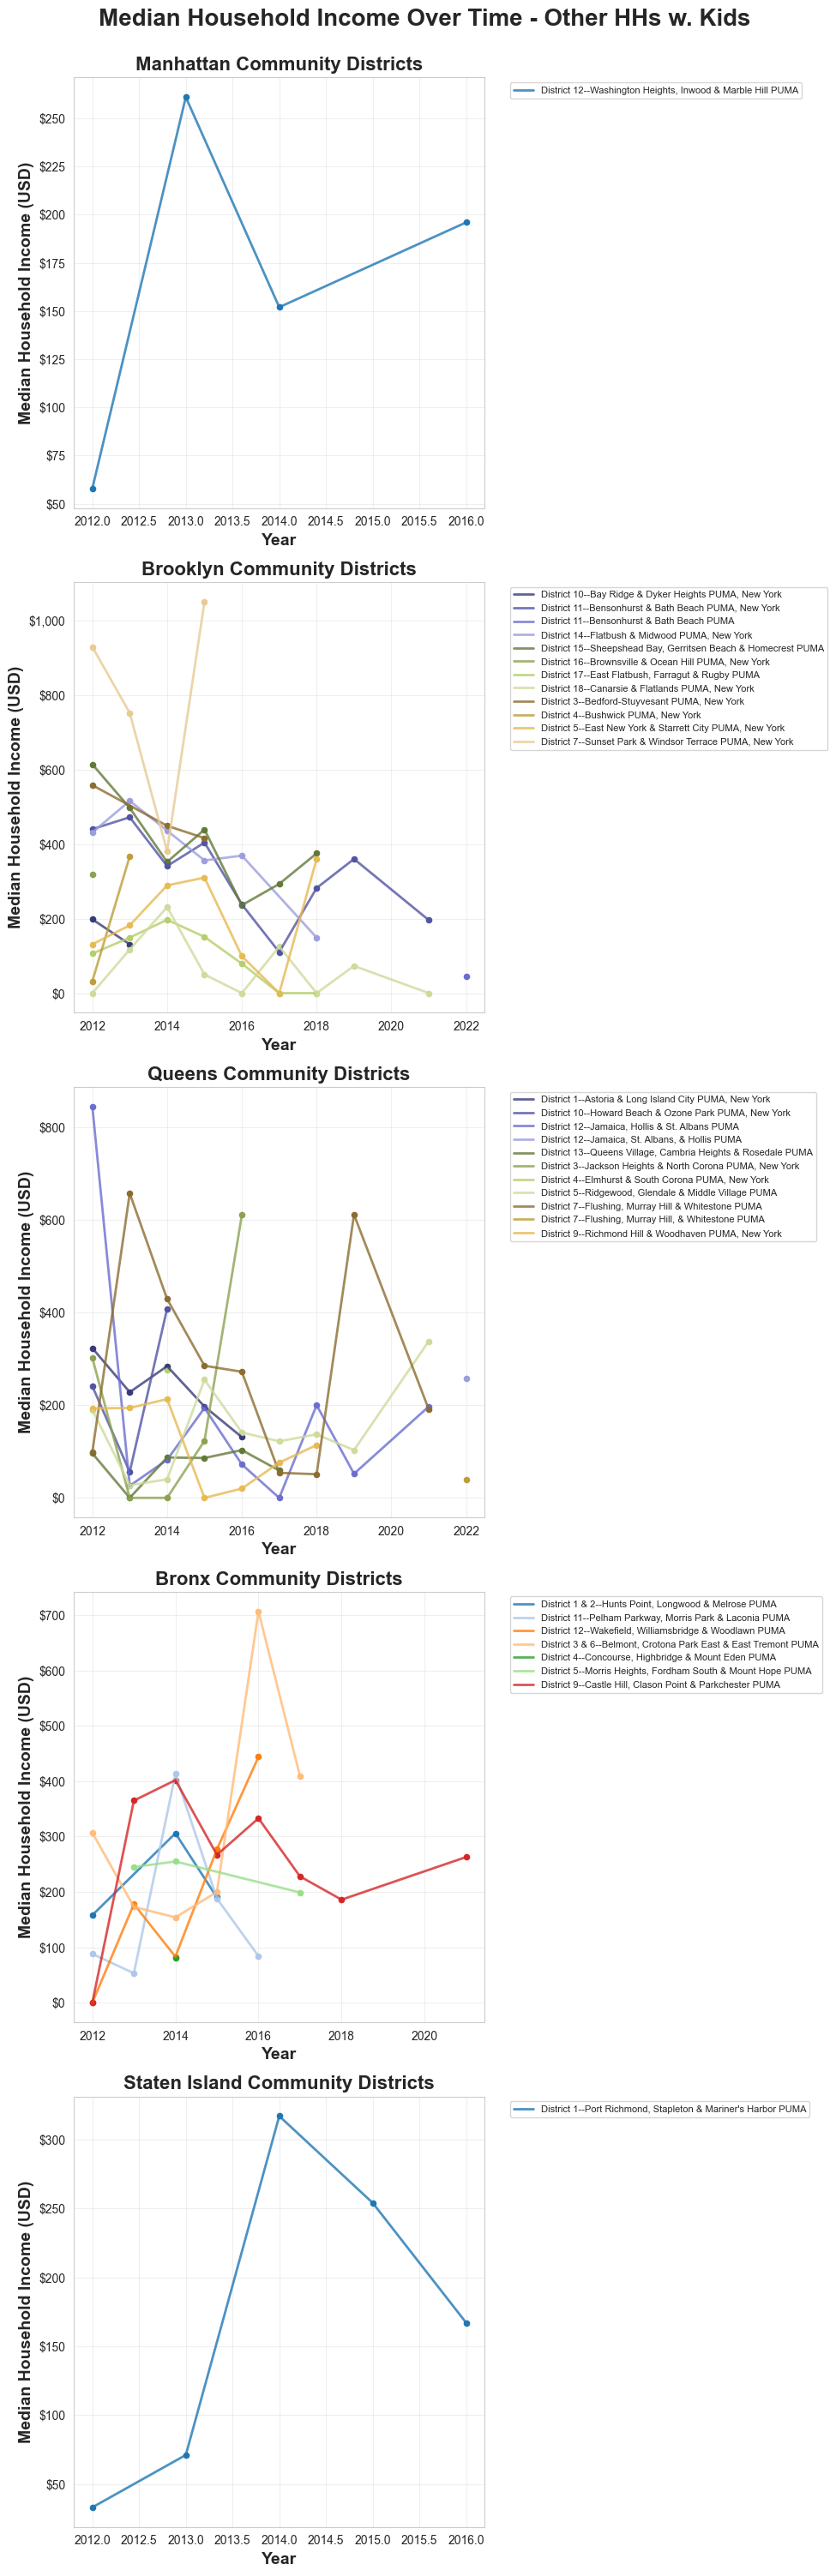

Data Summary by Borough:
--------------------------------------------------
Manhattan: 1 districts, $167 avg income (2012-2016)
Brooklyn: 12 districts, $279 avg income (2012-2022)
Queens: 11 districts, $185 avg income (2012-2022)
Bronx: 7 districts, $233 avg income (2012-2021)
Staten Island: 1 districts, $168 avg income (2012-2016)


In [14]:
# Ensuring data is in numeric format
median_HH_income_other_kids['B19131_005E'] = pd.to_numeric(median_HH_income_other_kids['B19131_005E'], errors='coerce')
median_HH_income_other_kids['year'] = pd.to_numeric(median_HH_income_other_kids['year'], errors='coerce')
# Remove any rows where conversion failed (NaN values)
median_HH_income_other_kids = median_HH_income_other_kids.dropna(subset=['B19131_005E', 'year'])

# Set up the plot style
sns.set_style("whitegrid")

# Get all NYC boroughs
boroughs = ['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']

# Create separate plot for each borough
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
axes = axes.flatten()  # Flatten for easier indexing

for i, borough in enumerate(boroughs):
    ax = axes[i]
    
    # Filter data for the current borough
    borough_data = median_HH_income_other_kids[median_HH_income_other_kids['NAME'].str.contains(borough, case=False)]
    
    if not borough_data.empty:
        # Get unique districts for this borough
        districts = borough_data['NAME'].unique()
        
        # Create color palette for districts in this borough
        if (borough == 'Brooklyn')|(borough == 'Queens'):
            district_colors = sns.color_palette("tab20b", len(districts))
        else:
            district_colors = sns.color_palette("tab20", len(districts))
        
        # Plot each district as a separate line with unique color
        for j, district_name in enumerate(districts):
            district_data = borough_data[borough_data['NAME'] == district_name]
            # Sort by year to ensure proper line connections
            district_sorted = district_data.sort_values('year')
            
            ax.plot(district_sorted['year'], district_sorted['B19131_005E'], 
                   color=district_colors[j], linewidth=2, alpha=0.8,
                   label=district_name[district_name.find('District'):].split(';')[0] if '--' in district_name else district_name)
            ax.scatter(district_sorted['year'], district_sorted['B19131_005E'], 
                   color=district_colors[j], s=20)
        
        # Customize each subplot
        ax.set_xlabel('Year', fontsize=14, fontweight='bold')
        ax.set_ylabel('Median Household Income (USD)', fontsize=14, fontweight='bold')
        ax.set_title(f'{borough} Community Districts', fontsize=16, fontweight='bold')
        
        # Format y-axis to show dollar signs
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
        
        # Add legend (truncated district names for readability)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    else:
        # Hide empty subplot
        ax.set_visible(False)

# Hide the extra subplot (since we have 5 boroughs but 6 subplot spaces)
#axes[5].set_visible(False)

# Improve overall layout
plt.suptitle('Median Household Income Over Time - Other HHs w. Kids', 
             fontsize=20, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

# Optional: Print summary statistics
print("Data Summary by Borough:")
print("-" * 50)
for borough in boroughs:
    borough_data = median_HH_income_other_kids[median_HH_income_other_kids['NAME'].str.contains(borough, case=False)]
    if not borough_data.empty:
        avg_income = borough_data['B19131_005E'].mean()
        num_districts = borough_data['NAME'].nunique()
        year_range = f"{borough_data['year'].min()}-{borough_data['year'].max()}"
        print(f"{borough}: {num_districts} districts, ${avg_income:,.0f} avg income ({year_range})")

### Let's Visualize Present/Missing Data


Processing Bronx...
  All Households: 100.0/120 data points (83.3% coverage)
  Single Adults: 100.0/120 data points (83.3% coverage)
  Married Families w. Children: 31.0/120 data points (25.8% coverage)
  Other Families w. Children: 31.0/120 data points (25.8% coverage)


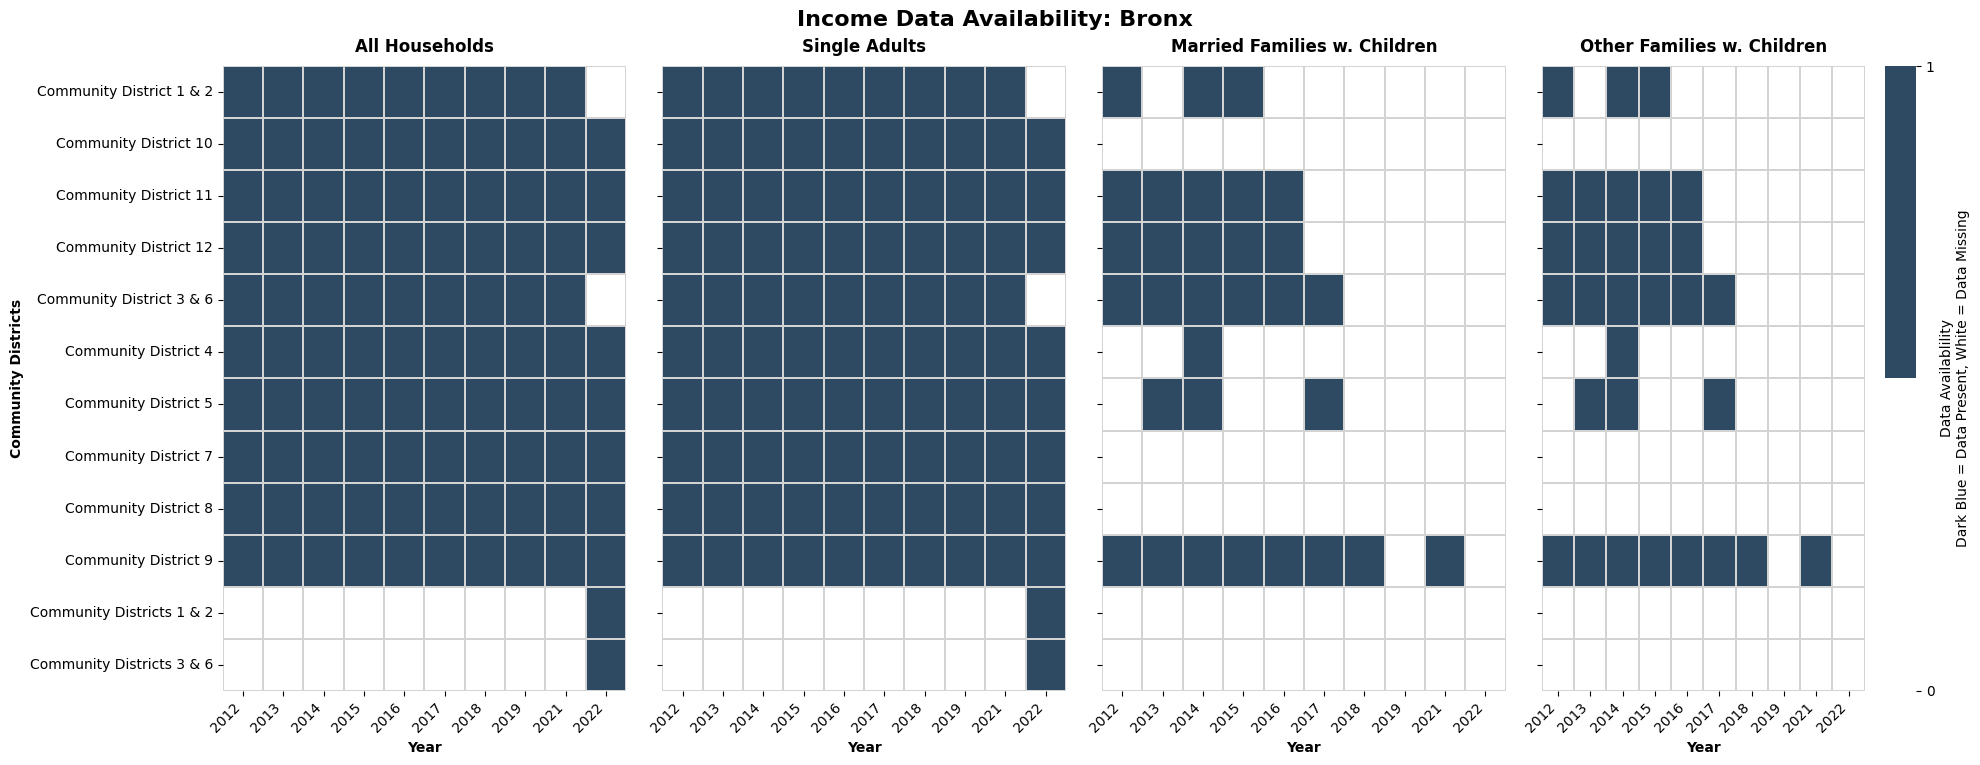


Processing Brooklyn...
  All Households: 180.0/180 data points (100.0% coverage)
  Single Adults: 180.0/180 data points (100.0% coverage)
  Married Families w. Children: 58.0/180 data points (32.2% coverage)
  Other Families w. Children: 58.0/180 data points (32.2% coverage)


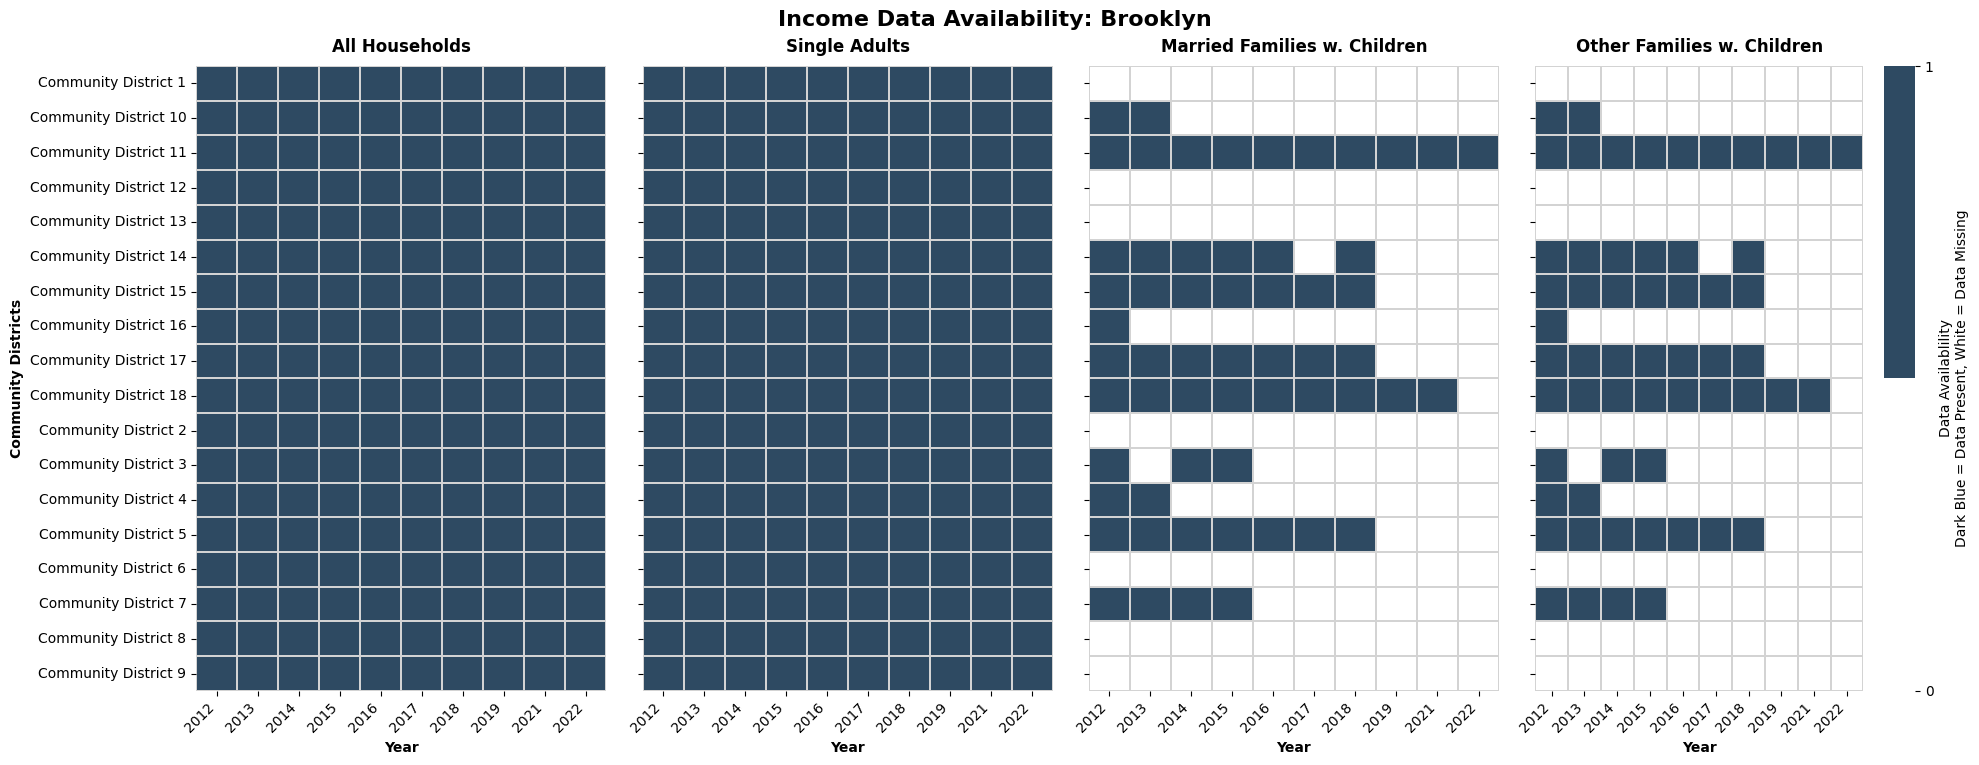


Processing Manhattan...
  All Households: 100.0/130 data points (76.9% coverage)
  Single Adults: 100.0/130 data points (76.9% coverage)
  Married Families w. Children: 4.0/130 data points (3.1% coverage)
  Other Families w. Children: 4.0/130 data points (3.1% coverage)


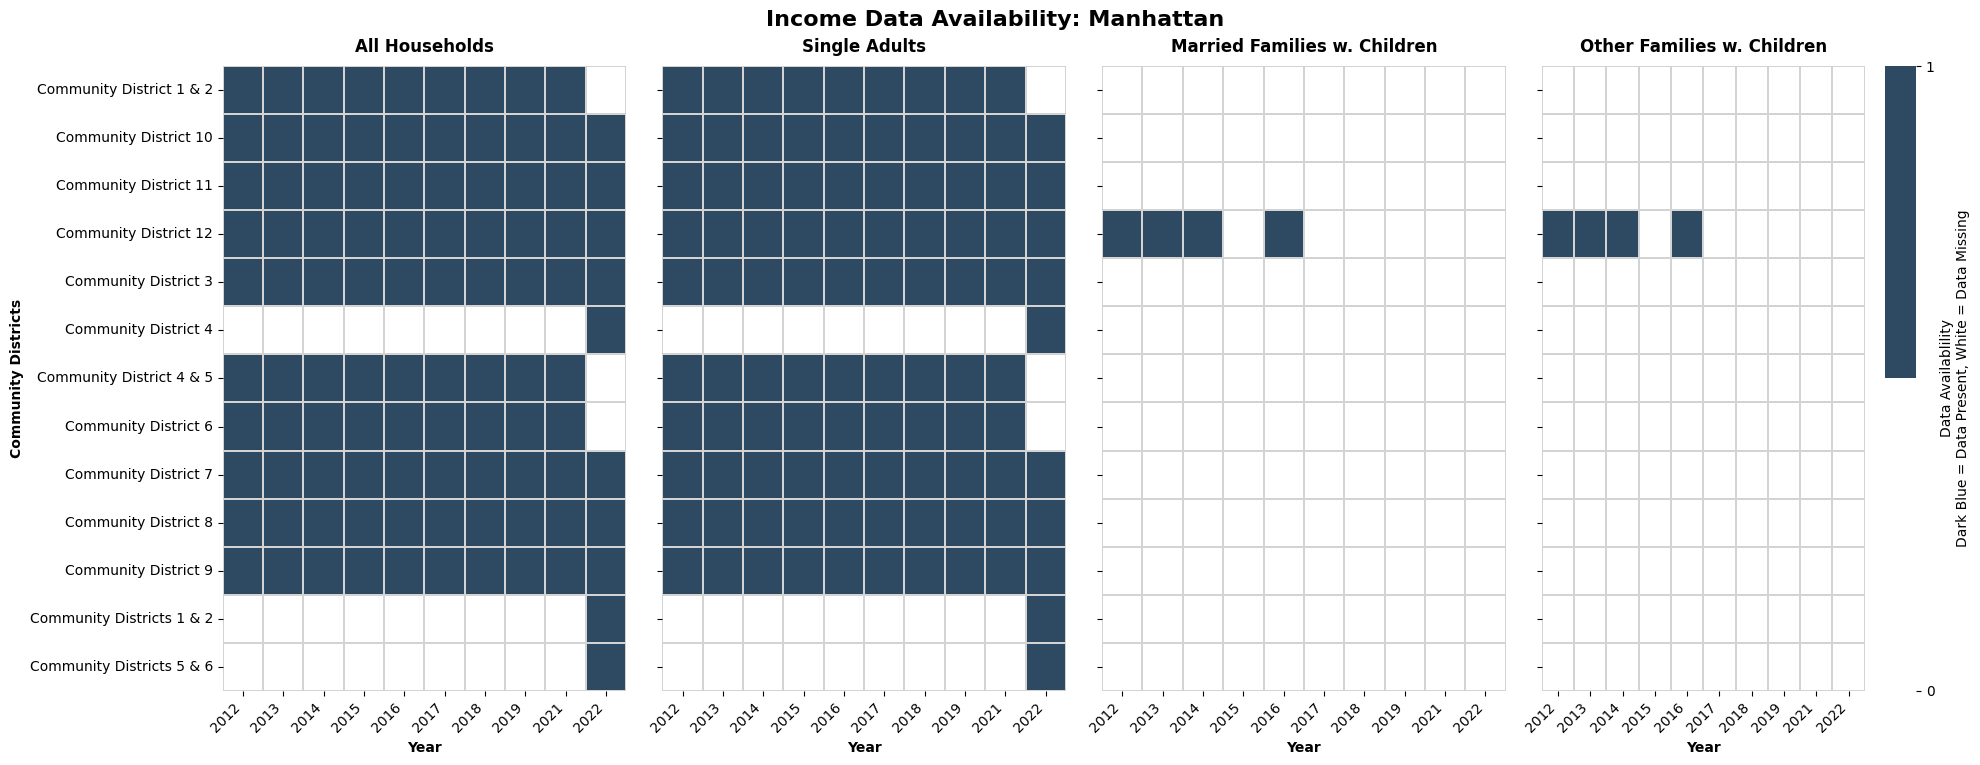


Processing Queens...
  All Households: 140.0/140 data points (100.0% coverage)
  Single Adults: 140.0/140 data points (100.0% coverage)
  Married Families w. Children: 56.0/140 data points (40.0% coverage)
  Other Families w. Children: 56.0/140 data points (40.0% coverage)


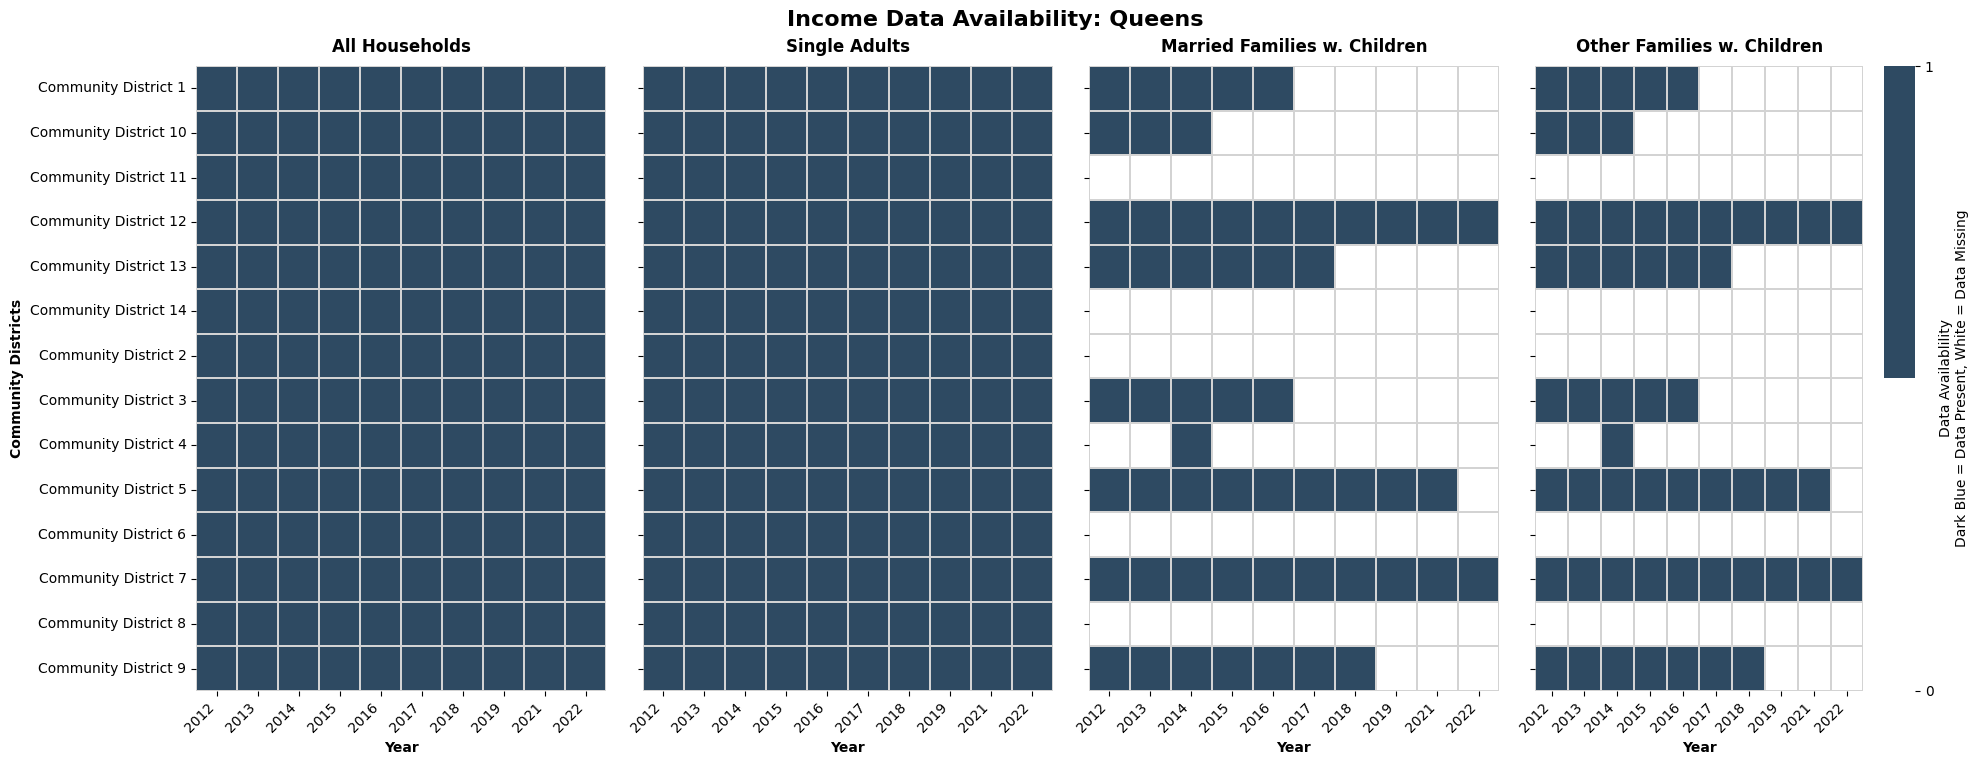


Processing Staten Island...
  All Households: 30.0/30 data points (100.0% coverage)
  Single Adults: 30.0/30 data points (100.0% coverage)
  Married Families w. Children: 5.0/30 data points (16.7% coverage)
  Other Families w. Children: 5.0/30 data points (16.7% coverage)


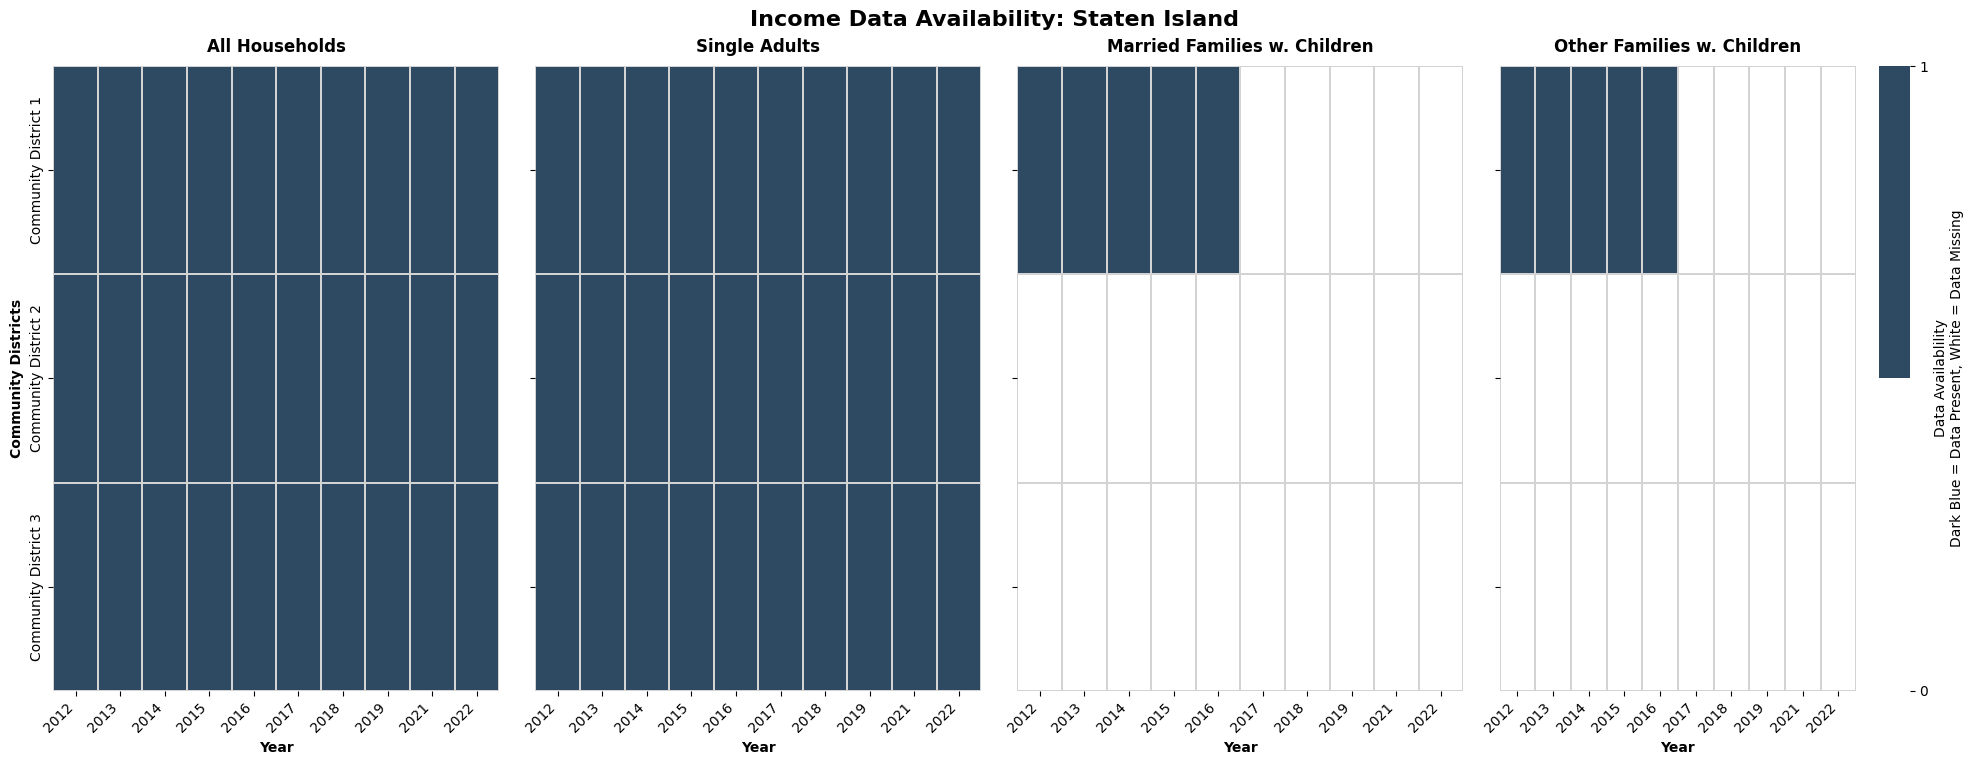

In [ ]:
def create_income_data_availability_heatmaps(median_income_df, figsize_per_borough=(20, 8)):
    """
    Creates data availability heatmaps for income data across all boroughs and household types.
    
    Parameters:
    ------
    median_income_df : pandas.DataFrame
        The income dataframe with columns: NAME, All_HHs, state, public use microdata area, 
        year, Single_HHs, Married_Families, Other_Families
    figsize_per_borough : tuple
        Figure size for each borough's plot
    """
    
    # Define the household type columns
    household_types = ['All_HHs', 'Single_HHs', 'Married_Families', 'Other_Families']
    household_labels = ['All Households', 'Single Adults', 'Married Families w. Children', 'Other Families w. Children']
    
    # Extract borough from NAME column 
    median_income_df['Borough'] = median_income_df['NAME'].str.extract(r'NYC-([^-]+)')[0].str.split(' Community ', expand=True)[0]
    
    # Get unique boroughs and years
    boroughs = median_income_df['Borough'].unique()
    years = sorted(median_income_df['year'].unique())
    
    # Custom colormap: white for missing, dark blue for present
    colors = ['white', '#2E4A62']
    custom_cmap = mpl.colors.ListedColormap(colors)
    
    # Create a figure for each borough
    for borough in boroughs:
        if pd.isna(borough):
            continue
            
        print(f"\nProcessing {borough}...")
        
        # Filter data for current borough
        borough_data = median_income_df[median_income_df['Borough'] == borough].copy()
        
        # Get unique districts for this borough
        districts = sorted(borough_data['NAME'].unique())
        
        # Create figure with 4 subplots (one for each household type)
        fig, axes = plt.subplots(1, 4, figsize=figsize_per_borough, sharey=True)
        fig.suptitle(f'Income Data Availability: {borough}', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        # Create availability matrix for each household type
        for idx, (hh_type, hh_label) in enumerate(zip(household_types, household_labels)):
            # Initialize availability matrix (districts x years)
            availability_matrix = np.zeros((len(districts), len(years)))
            
            # Fill the matrix
            for district_idx, district in enumerate(districts):
                for year_idx, year in enumerate(years):
                    # Find the row for this district and year
                    mask = (borough_data['NAME'] == district) & (borough_data['year'] == year)
                    matching_rows = borough_data[mask]
                    
                    if len(matching_rows) > 0:
                        value = matching_rows[hh_type].iloc[0]
                        if pd.notna(value) and str(value).lower() != 'none':
                            availability_matrix[district_idx, year_idx] = 1
                    # If no matching row or value is NaN/None, it remains 0
            
            # Create heatmap for this household type
            ax = axes[idx]
            
            # Create the heatmap
            sns.heatmap(availability_matrix,
                       cmap=custom_cmap,
                       ax=ax,
                       cbar_kws={'label': 'Data Availablility\nDark Blue = Data Present, White = Data Missing',
                                  'ticks': [0, 1]} if idx == 3 else {'ticks': [0, 1]},
                       xticklabels=years,
                       yticklabels=['Community'+district.split(' Community')[1] for district in districts],
                       linewidths=0.1,
                       linecolor='lightgray',
                       cbar=idx == 3, # Only show colorbar on the last subplot
                       vmin=0,  # Explicitly set color range
                       vmax=1)  
            
            # Customize subplot
            ax.set_title(hh_label, fontsize=12, fontweight='bold', pad=10)
            ax.set_xlabel('Year', fontsize=10, fontweight='bold')
            if idx == 0:
                ax.set_ylabel('Community Districts', fontsize=10, fontweight='bold')
            
            # Rotate x-axis labels
            ax.set_xticklabels(years, rotation=45, ha='right')
            
            # Calculate and print summary for this subplot
            total_cells = availability_matrix.size
            present_data = np.sum(availability_matrix)
            coverage_pct = (present_data / total_cells * 100) if total_cells > 0 else 0
            
            print(f"  {hh_label}: {present_data}/{total_cells} data points ({coverage_pct:.1f}% coverage)")
        
        # Adjust layout
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Make room for suptitle
        
        # Show the plot
        plt.show()
    
    return

create_income_data_availability_heatmaps(median_income_df)


We can see that it's going to be easy to calculate affordability metrics for 'All Huseholds' and 'Single Adult' populations, however, there is limited coverage of median income for both groups of family populations. The Bronx, Brooklyn, and Queens are boroughs with the best data for those populations, so we will assess affordability for families based on the income and rent data for those 3 boroughs and their respective neighborhoods solely.

# Preprocess and Tidy both datasets

Let's convert all of the rent datasets into tidy format, and ensure columns names and contents are optimized for usability.

In [18]:
# melting DFs and splitting the month-year column into separate columns
rent_all_clean = tidy_asking_rent(df_rent_all)
rent_1bdr_clean = tidy_asking_rent(df_rent_1bdr)
rent_3bdr_clean = tidy_asking_rent(df_rent_3bdr)

# merging datasets to create one median_rent DF
merged_table = pd.merge(rent_all_clean.rename(columns={"median_rent":"all_apts"}), 
                        rent_1bdr_clean.rename(columns={"median_rent":"1bdr_apts"}), 
                        how='inner', on=["area_name", "borough", "area_type","year","month"]
                        )

median_rent_table = pd.merge(merged_table, 
                        rent_3bdr_clean.rename(columns={"median_rent":"3bdr_apts"}), 
                        how='inner', on=["area_name", "borough", "area_type","year","month"]
                        )
median_rent_table.head()

area_name    borough     area_type  year month  all_apts  \
0            Astoria     Queens  neighborhood  2010    01    1600.0   
1         Auburndale     Queens  neighborhood  2010    01       NaN   
2         Bath Beach   Brooklyn  neighborhood  2010    01       NaN   
3  Battery Park City  Manhattan  neighborhood  2010    01    3495.0   
4          Bay Ridge   Brooklyn  neighborhood  2010    01    1350.0   

   1bdr_apts  3bdr_apts  
0     1395.0     1395.0  
1        NaN        NaN  
2        NaN        NaN  
3     2875.0     2875.0  
4     1350.0     1350.0

All income datasets are already in tidy format (yay)! Let's merge them, and modify column names and organization to improve usability

In [19]:
#  merging tables with income data
income_dfs = [median_HH_income_all,
              median_HH_income_singles,
              median_HH_income_other_kids,
              median_HH_income_married_kids
]

for idx, df in enumerate(income_dfs):
    if idx == 0:
        merged_table = pd.merge(df, income_dfs[idx+1], how='inner',
                                on=['NAME','public use microdata area', 'year', 'state']
                                )
    elif idx == (len(income_dfs)-1):
        break
    else:
        merged_table = pd.merge(merged_table, income_dfs[idx+1], how='inner', # type: ignore
                                on=['NAME','public use microdata area', 'year', 'state']
                                )

# Rename columns for easier querying
merged_table.rename(columns={"B19013_001E":"income_all_HHs",
                             "B19202_001E":"income_singles",
                             "B19131_002E":"income_married_kids",
                             "B19131_005E":"income_other_kids"
}, inplace=True)


merged_table.head()
cols = list(merged_table.columns)
# move income columns to right side of df
cols.insert(5, cols[1])
del cols[1]
final_table = merged_table[cols]
final_table.head()

NAME state  \
0  NYC-Bronx Community District 1 & 2--Hunts Poin...    36   
1  NYC-Bronx Community District 1 & 2--Hunts Poin...    36   
2  NYC-Bronx Community District 1 & 2--Hunts Poin...    36   
3  NYC-Bronx Community District 1 & 2--Hunts Poin...    36   
4  NYC-Bronx Community District 1 & 2--Hunts Poin...    36   

  public use microdata area  year income_all_HHs income_singles  \
0                     03710  2012          19122          12355   
1                     03710  2017          20966          11660   
2                     03710  2014          21116          12739   
3                     03710  2013          23083          14275   
4                     03710  2015          24408          11516   

  income_other_kids income_married_kids  
0               158                9861  
1              None                None  
2               306                9559  
3              None                None  
4               190               11047

# Upload Preprocessed Datasets to PostgreSQL Database

We're going to move these datasets over to Postgres to conduct a more in-depth Exploratory Data Analysis

In [ ]:
# 5a. Uploading income data to postgres
engine = get_engine('postgres',
                    os.getenv('PSQL_PWD'),
                    'localhost',
                    '5432',
                    'rent_affordability')

dtype_mapping = {
    "income_all_HHs": types.DOUBLE_PRECISION,
    "income_singles": types.DOUBLE_PRECISION,
    "income_other_kids": types.DOUBLE_PRECISION,
    "income_married_kids": types.DOUBLE_PRECISION,
}

final_table.to_sql('median_income', con=engine, 
                   if_exists='replace', index=False,
                   dtype=dtype_mapping)

# 5b. Uploading rent data to postgres
engine = get_engine('postgres',
                    os.getenv('PSQL_PWD'),
                    'localhost',
                    '5432',
                    'rent_affordability')

dtype_mapping = {
    "year": types.BIGINT,
    "month": types.INTEGER,
}

median_rent_table.to_sql('median_rent', con=engine, 
                   if_exists='replace', index=False,
                   dtype=dtype_mapping)

print('postgres upload successful!')

# Exploratory Data Analysis in PostgreSQL

I went over to postgres to build tables with primary keys to serve as junction tables for dataset-to-dataset comparisons. 

In postgres I familiarized myself with the datasets further, and conducted some preliminary analyses to investigate: 
* Rent Volatility
* Affordability over Time
* The relationship between Rent and Income 
* Pandemic effects on income values and rent prices individually

Here are the results of those analyses, visualized using Tableau:

## Rent Volatility

### Boroughs

In [11]:
%%HTML
<h3>Brooklyn Rent Volatility</h3>
<div class='tableauPlaceholder' id='viz1758933008523' style='position: relative'><noscript><a href='#'><img alt='BK- Rent Volatility ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Brooklyn&#47;BK-RentVolatility&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RentVolatility-Brooklyn&#47;BK-RentVolatility' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Brooklyn&#47;BK-RentVolatility&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                
<script type='text/javascript'>
var divElement = document.getElementById('viz1758933008523');                    
var vizElement = divElement.getElementsByTagName('object')[0];                    
vizElement.style.width='100%';
vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    
var scriptElement = document.createElement('script');                    
scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    
vizElement.parentNode.insertBefore(scriptElement, vizElement);                
</script>

In [12]:
%%HTML
<h3>Bronx Rent Volatility</h3>
<div class='tableauPlaceholder' id='viz1759094462960' style='position: relative'><noscript><a href='#'><img alt='BX- Rent Volatility ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Bronx&#47;BX-RentVolatility&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RentVolatility-Bronx&#47;BX-RentVolatility' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Bronx&#47;BX-RentVolatility&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1759094462960');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [13]:
%%HTML
<h3>Manhattan Rent Volatility</h3>
<div class='tableauPlaceholder' id='viz1759094550434' style='position: relative'><noscript><a href='#'><img alt='MH- Rent Volatility ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Manhattan&#47;MH-RentVolatility&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RentVolatility-Manhattan&#47;MH-RentVolatility' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Manhattan&#47;MH-RentVolatility&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1759094550434');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [14]:
%%HTML
<h3>Queens Rent Volatility</h3>
<div class='tableauPlaceholder' id='viz1759094572469' style='position: relative'><noscript><a href='#'><img alt='QN- Rent Volatility ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Queens&#47;QN-RentVolatility&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RentVolatility-Queens&#47;QN-RentVolatility' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-Queens&#47;QN-RentVolatility&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1759094572469');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### NYC Rent Volatility

In [15]:
%%HTML
<div class='tableauPlaceholder' id='viz1759094640046' style='position: relative'><noscript><a href='#'><img alt='NYC Rent Volatility ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-NYCBoroughs&#47;NYCRentVolatility&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='RentVolatility-NYCBoroughs&#47;NYCRentVolatility' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Re&#47;RentVolatility-NYCBoroughs&#47;NYCRentVolatility&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1759094640046');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

## Affordability Over Time

### Looking at: Income from All Households and Rent from All Apartments

In [16]:
%%HTML
<div class='tableauPlaceholder' id='viz1759094881256' style='position: relative'><noscript><a href='#'><img alt='Affordability over time in Queens - All Apartments ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Af&#47;AffordabilityTimeseries-Queens&#47;QN-AffordabilityTS&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='AffordabilityTimeseries-Queens&#47;QN-AffordabilityTS' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Af&#47;AffordabilityTimeseries-Queens&#47;QN-AffordabilityTS&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1759094881256');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [17]:
%%HTML
<div class='tableauPlaceholder' id='viz1759094926718' style='position: relative'><noscript><a href='#'><img alt='Affordability over time in Brooklyn - All Apartments ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Af&#47;AffordabilityTimeseries-Brooklyn&#47;BK-AffordabilityTS&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='AffordabilityTimeseries-Brooklyn&#47;BK-AffordabilityTS' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Af&#47;AffordabilityTimeseries-Brooklyn&#47;BK-AffordabilityTS&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1759094926718');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Looking at: Income from Single Adults and Rent from One-Bedroom Apartments

### Looking at: Income from Families w. Children and Rent from 3+ Bedroom Apartments

## Pandemic Effects on Income and Rent Prices